### Initialization

In [4]:
import os
import sys
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models.mog_model import *
from utils.distributions import *


plt.style.use('/Users/saforem2/.config/matplotlib/stylelib/dark_jupyter.mplstyle')
plt.rcParams['figure.facecolor'] = '#474747'

%matplotlib notebook
%autoreload 2

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/Users/saforem2/.config/matplotlib/stylelib/dark_jupyter.mplstyle", line #92
  (fname, cnt))
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/Users/saforem2/.config/matplotlib/stylelib/dark_jupyter.mplstyle", line #93
  (fname, cnt))


### Ring of Gaussians

In [31]:
x_dim = 2
num_distributions = 6
sigma = 0.01

#MEANS = np.zeros((X_DIM, X_DIM), dtype=np.float32)
#CENTERS = np.sqrt(2)  # center of Gaussian
#for i in range(NUM_DISTRIBUTIONS):
#    MEANS[i::NUM_DISTRIBUTIONS, i] = CENTERS

covs, distribution = gen_ring(r=1., var=sigma, nb_mixtures=num_distributions)
mus = np.array(distribution.mus)
diffs = mus[1:] - mus[:-1, :]
distances = [np.sqrt(np.dot(d, d.T)) for d in diffs]

### Lattice of Gaussians

In [5]:
x_dim = 2
num_distributions = 16
var = 0.01
L = int(np.sqrt(num_distributions))
means = np.array([(i, j) for i in range(L) for j in range(L)])
_sigmas = np.array([var * np.eye(x_dim) for _ in range(num_distributions)])
pis = [1. / num_distributions] * num_distributions 
pis[0] += 1 - sum(pis)

In [6]:
distribution = GMM(means, _sigmas, pis)

### Plot samples from distribution

<IPython.core.display.Javascript object>


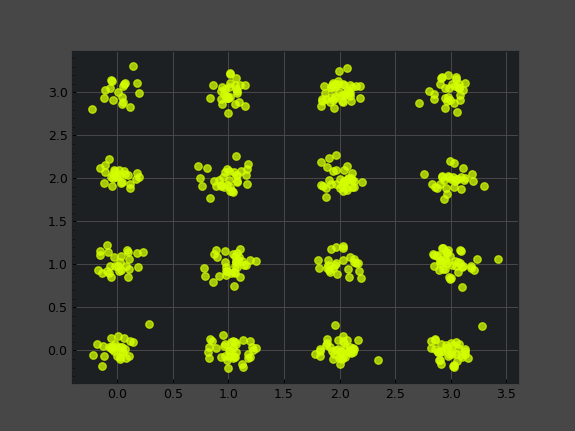

In [7]:
%matplotlib notebook
samples = distribution.get_samples(500)
fig, ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1], marker='o', ls='', alpha=0.75)
plt.show()
#plt.savefig('../log_mog_tf/run_326/figures/target_distribution.pdf', dpi=400, bbox_inches='tight')

### GMM separated along diagonal

In [30]:
x_dim = 2
sigma = 0.02
centers = 1
means = np.zeros((x_dim, x_dim), dtype=np.float32)
for i in range(x_dim):
    means[i::x_dim, i] = centers
cov_mtx = sigma * np.eye(x_dim).astype(np.float32)
covs = np.array([cov_mtx] * x_dim).astype(np.float32)
dist_arr = distribution_arr(x_dim, 2)
gmm_dist = GMM(means, covs, dist_arr)

gmm_mus = np.array(gmm_dist.mus)
gmm_diffs = gmm_mus[1:] - gmm_mus[:-1, :]
gmm_distances = [np.sqrt(np.dot(d, d.T)) for d in gmm_diffs]
gmm_distances

[1.4142135]

<IPython.core.display.Javascript object>


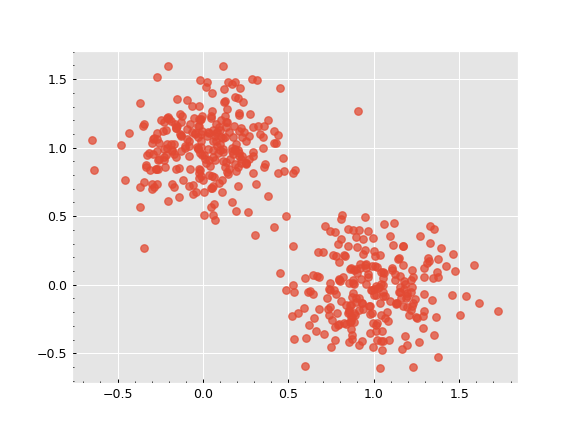

In [29]:
gmm_samples = gmm_dist.get_samples(500)
fig, ax = plt.subplots()
ax.plot(gmm_samples[:,0], gmm_samples[:,1], marker='o', ls='', alpha=0.75)
plt.show()

### Create GMM model for training with L2HMC

In [27]:
#x_dim = 2
#num_distributions = 6
#sigma = 0.005

#MEANS = np.zeros((X_DIM, X_DIM), dtype=np.float32)
#CENTERS = np.sqrt(2)  # center of Gaussian
#for i in range(NUM_DISTRIBUTIONS):
#    MEANS[i::NUM_DISTRIBUTIONS, i] = CENTERS

#covs, distribution = gen_ring(r=1.0, var=sigma, nb_mixtures=num_distributions)
#means = distribution.mus

params = {                          # default parameter values
    'x_dim': x_dim,
    'num_distributions': num_distributions,
    'means': means,
    'sigma': 0.05,
    'small_pi': 2E-16,
    'scale': 0.1,
    'num_samples': 200,
    'lr_init': 1e-3,
    'lr_decay_steps': 1000,
    'lr_decay_rate': 0.96, 'eps': 0.5,
    'temp_init': 20,
    'annealing_steps': 200,
    'annealing_rate': 0.98,
    #'train_trajectory_length': 15,
    #'test_trajectory_length': 2000,
    'num_training_steps': 30000,
    'tunneling_rate_steps': 1000,
    'save_steps': 1000,
    'logging_steps': 100
}

## Build / Train model

In [10]:
tf.reset_default_graph()

In [8]:
#%pdb
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#kwargs = {'radius': 1.0, 'sigma': 0.01, 'num_distributions': 6}
params = {}
model = GaussianMixtureModel(params, 
                             config=config,
                             log_dir='../../log_mog_tf/run_376/',
                             covs=_sigmas,
                             distribution=distribution)
                             #**kwargs)
                             #log_dir='../log_mog_tf/run_22_diag_271/')
                             #log_dir='../log_mog_tf/run64/')

Loading from previous parameters in from: ../../log_mog_tf/run_376/run_info/
################################################################################
Model parameters:
x_dim: 2

num_distributions: 16

eps: 0.5

scale: 0.1

num_samples: 200

sigma: 0.05

small_pi: 2e-16

lr_init: 0.001

temp_init: 20

annealing_steps: 200

annealing_factor: 0.98

num_training_steps: 30000

tunneling_rate_steps: 1000

lr_decay_steps: 1000

lr_decay_rate: 0.96

logging_steps: 100

save_steps: 1000

arrangement: axes

radius: 1.0

temp: 16.34145613775094

_annealing_steps_init: 200

_tunneling_rate_steps_init: 1000

log_dir: ../../log_mog_tf/run_376/

info_dir: ../../log_mog_tf/run_376/run_info/

figs_dir: ../../log_mog_tf/run_376/figures/

annealing_rate: 0.98

trajectory_length: 2

################################################################################




In [9]:
model._restore_model()

Restoring previous model from: /Users/saforem2/ANL/l2hmc/log_mog_tf/run_376/model.ckpt-2327
INFO:tensorflow:Restoring parameters from /Users/saforem2/ANL/l2hmc/log_mog_tf/run_376/model.ckpt-2327
Model restored.



## Train model

Restoring previous model from: /Users/saforem2/ANL/l2hmc/log_mog_tf/run_376/model.ckpt-2327
INFO:tensorflow:Restoring parameters from /Users/saforem2/ANL/l2hmc/log_mog_tf/run_376/model.ckpt-2327
Model restored.

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 2400/22328   16.01     -345.1       0.9484      0.0009216     0.4832          2      
 2500/22328   16.01     -387.7       0.9498      0.0009216     0.4831          2      
 2600/22328   15.69      -368         0.939      0.0009216     0.4823          2      
 2700/22328   15.69     -351.3        0.934      0.0009216     0.4804          2      
 2800/22328   15.38     -360.2       0.9494      0.0009216     0.4805          2      
 2900/22328   15.38     -350.6       0.9433      0.0009216     0.4798          2      
---

<IPython.core.display.Javascript object>


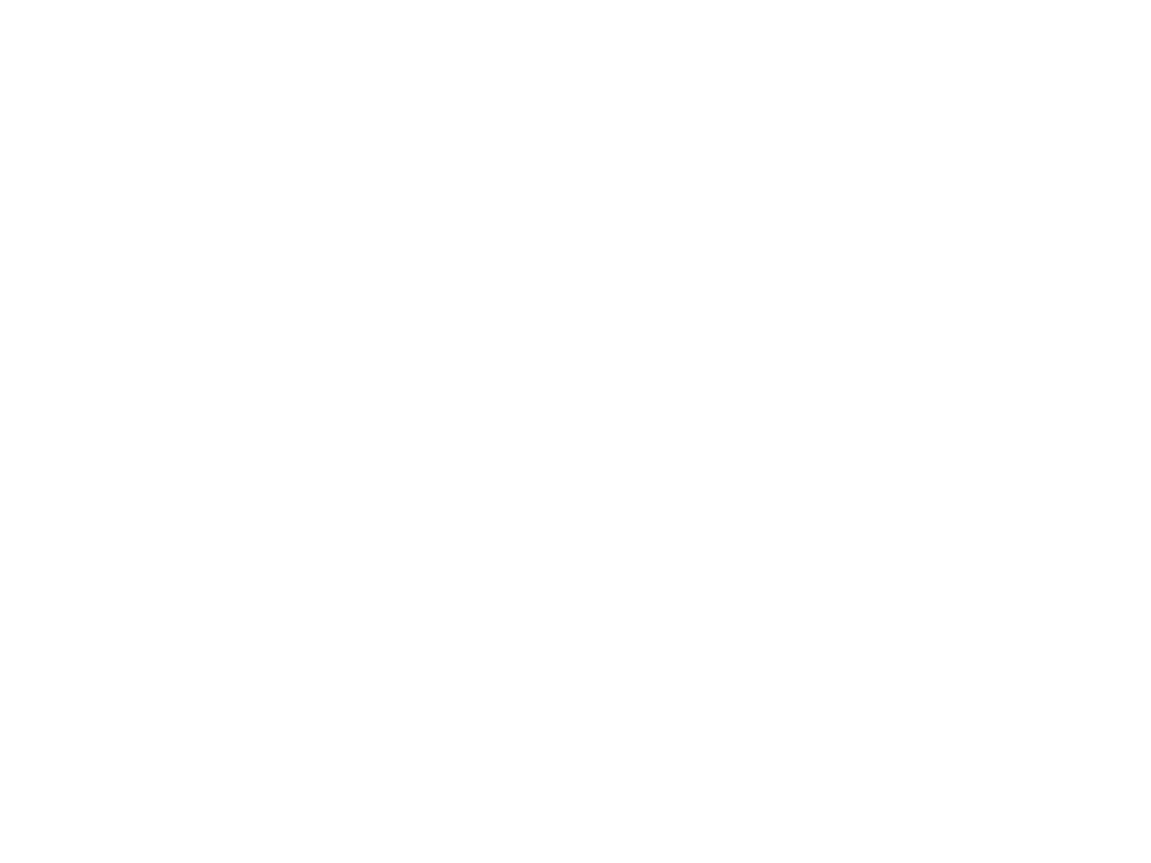

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


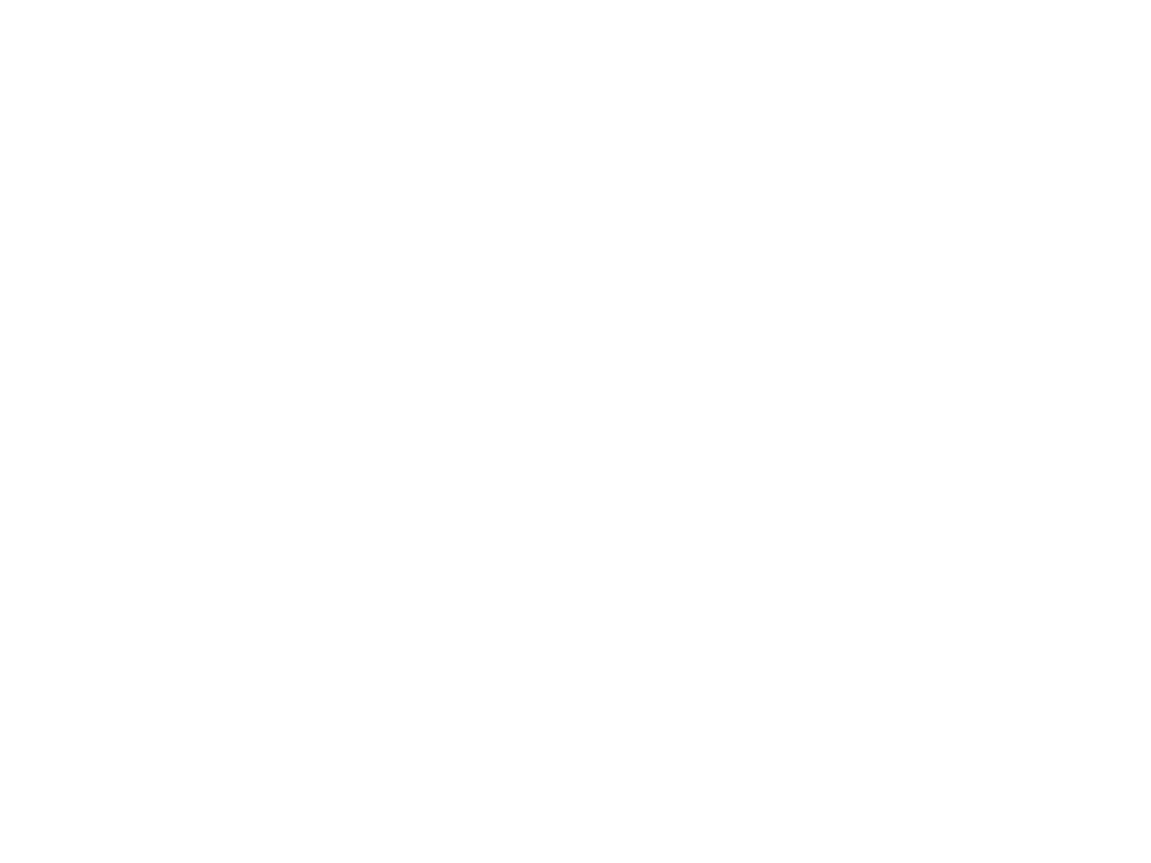

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


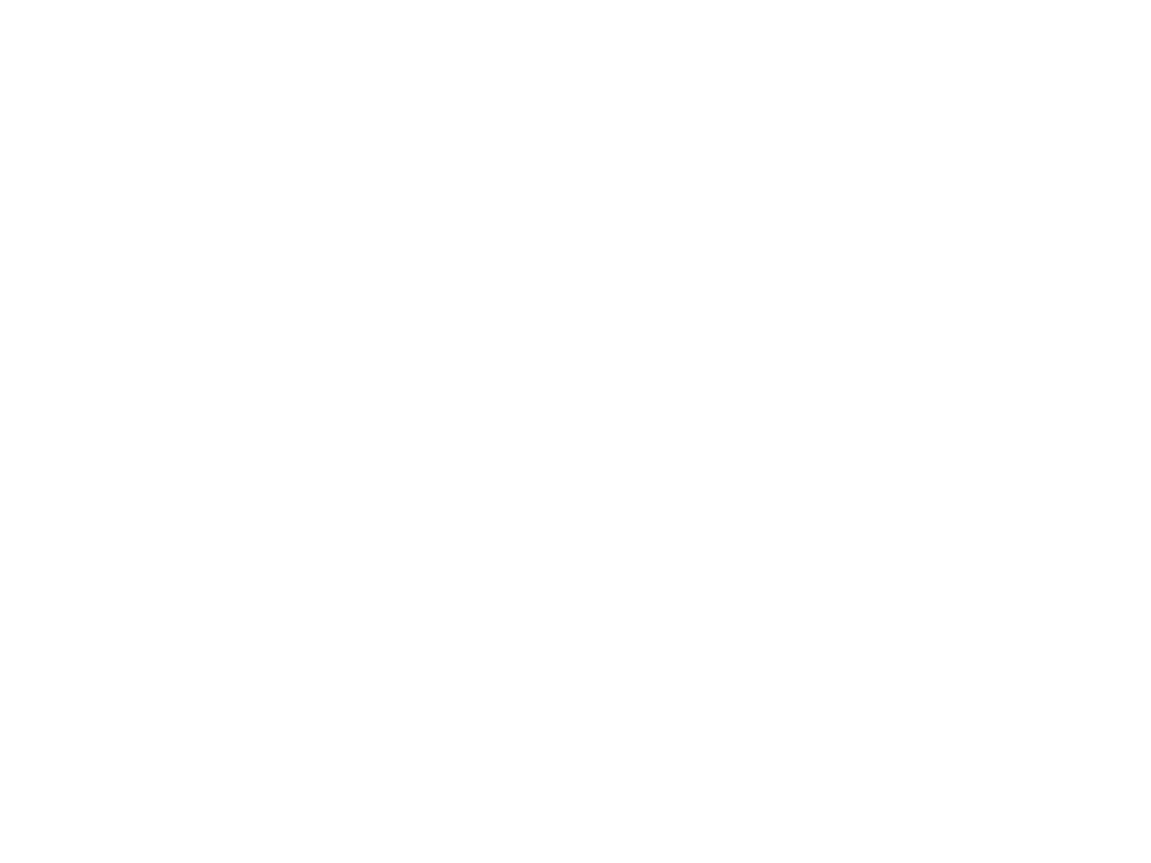

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


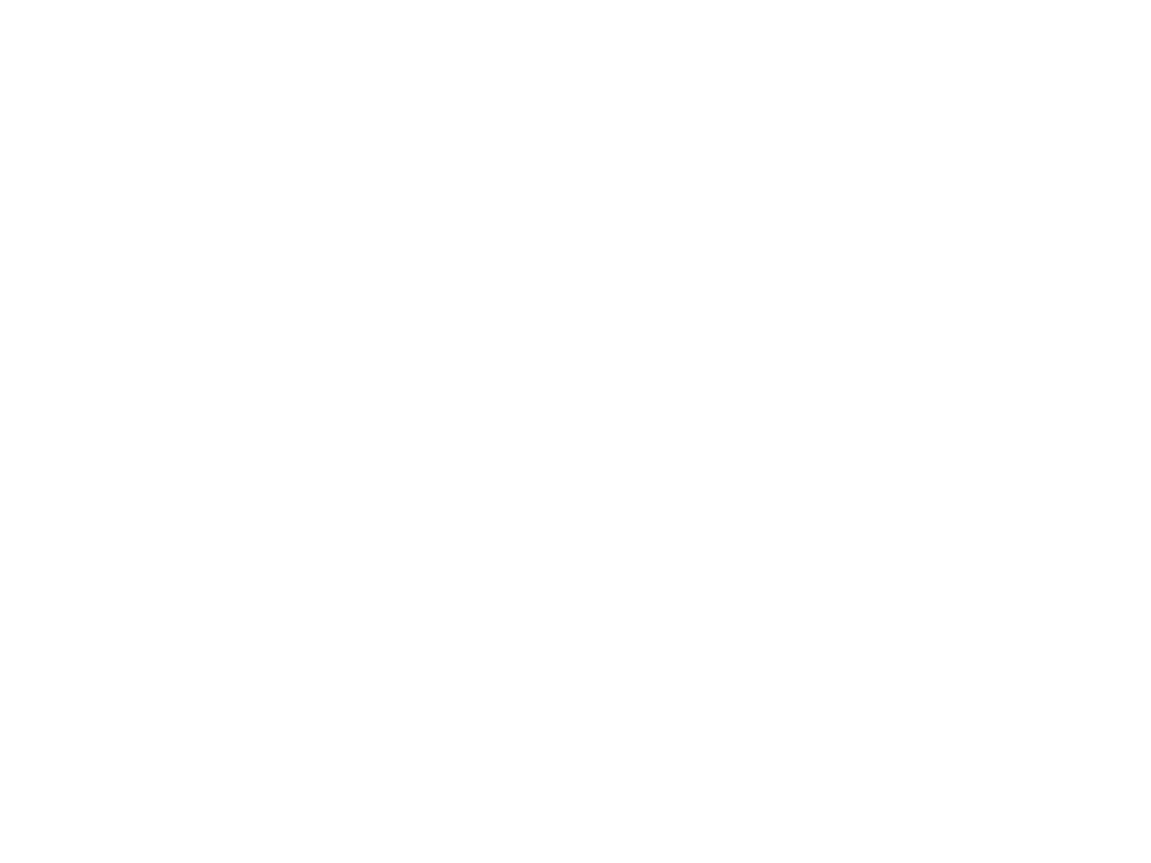

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


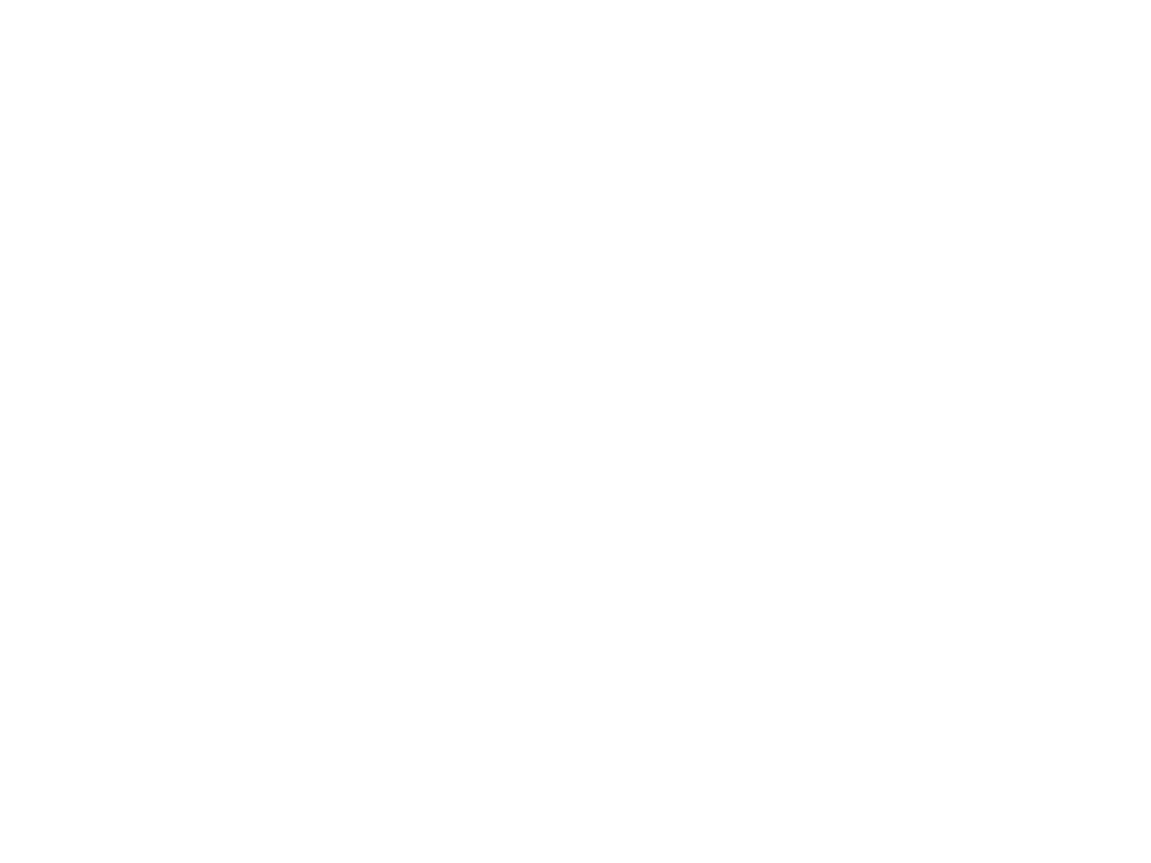

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 3000/22328   15.07      -353        0.9406      0.0008847     0.4793          2      
 3100/22328   15.07     -377.8       0.9552      0.0008847     0.4791          2      
 3200/22328   14.77      -347        0.8738      0.0008847     0.4793          2      
 3300/22328   14.77     -370.2       0.9515      0.0008847     0.4787          2      
 3400/22328   14.48     -340.8       0.9243      0.0008847     0.4784          2      
 3500/22328   14.48     -367.7       0.9497      0.0008847     0.4774          2      
 3600/22328   14.19     -361.5       0.9445      0.0008847     0.4769          2      
 3700/22328   14.19      -375        0.9468      0.000

<IPython.core.display.Javascript object>


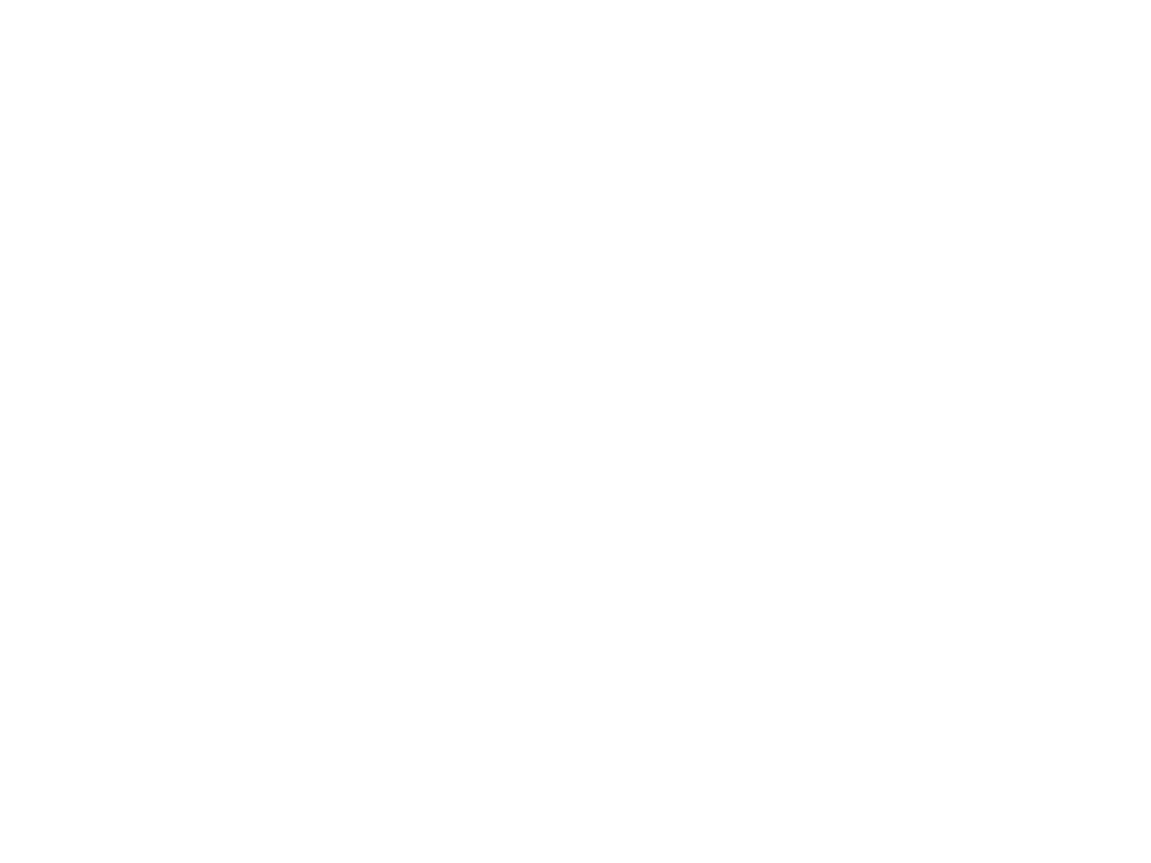

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


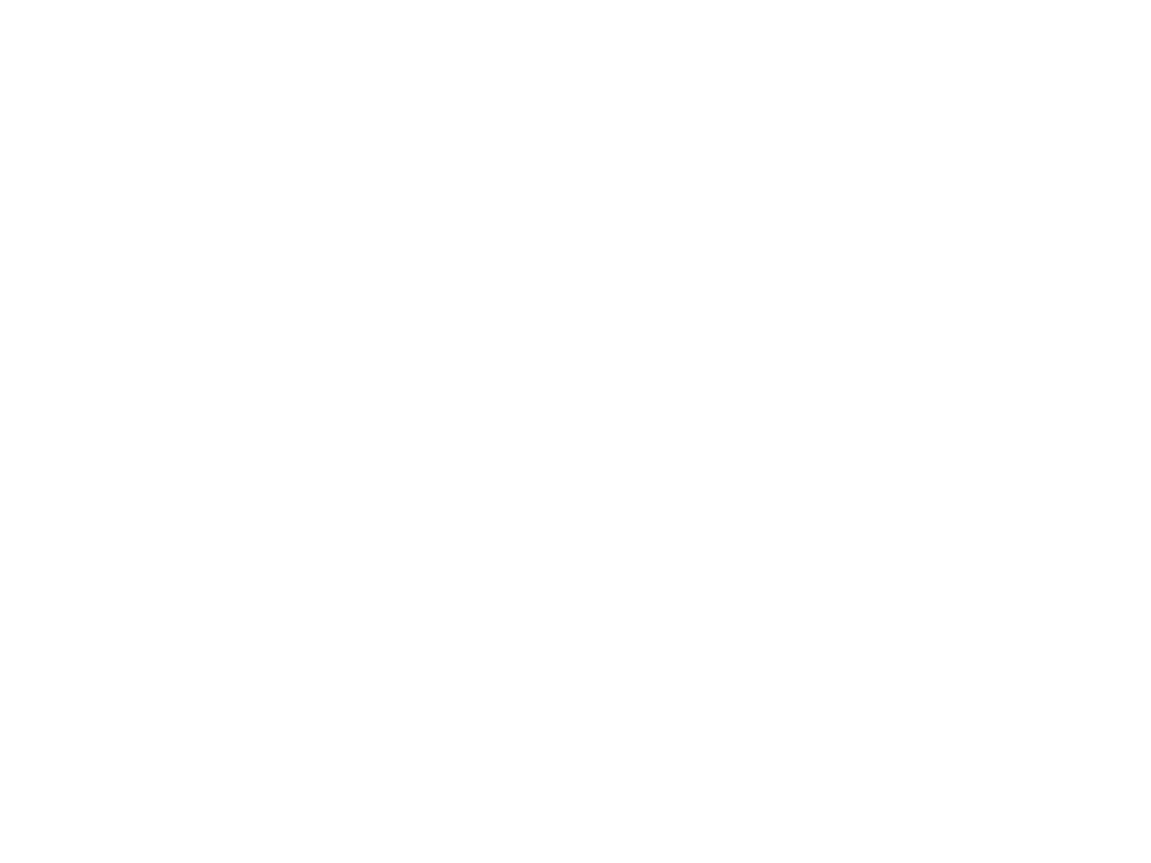

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


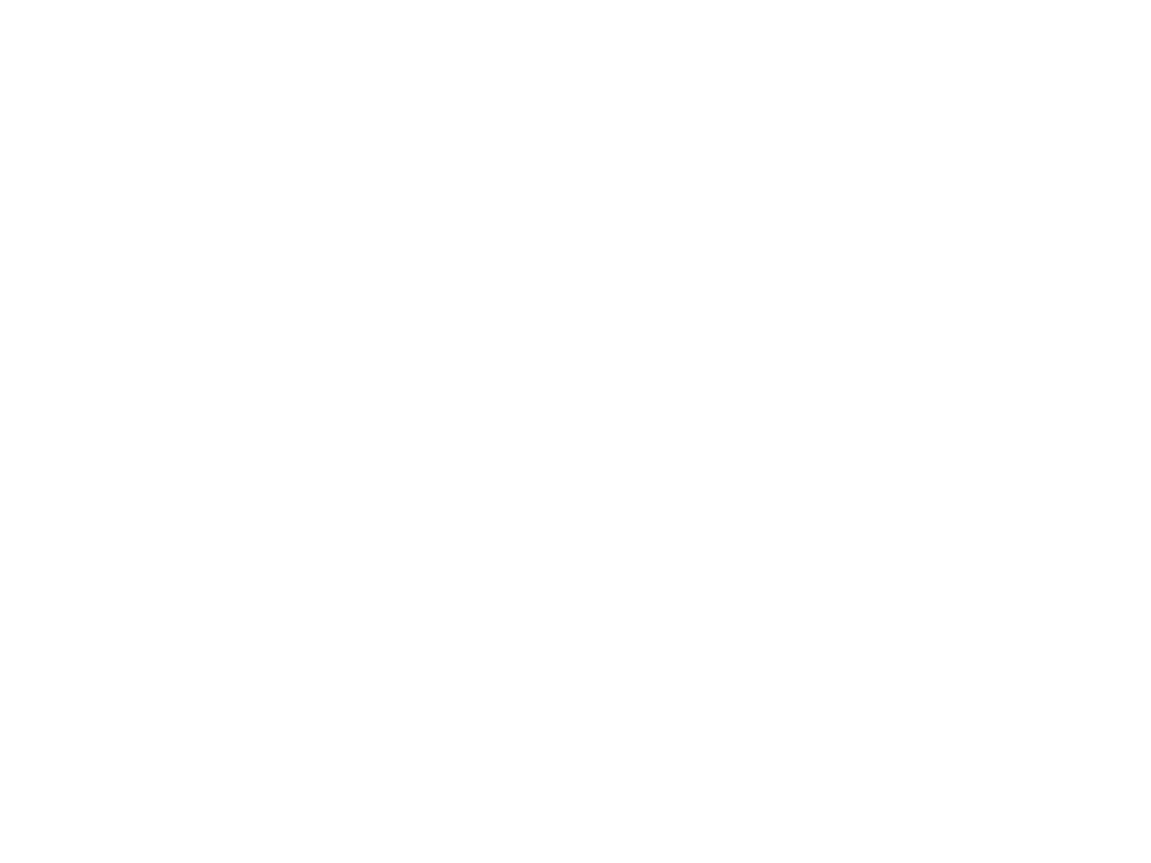

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


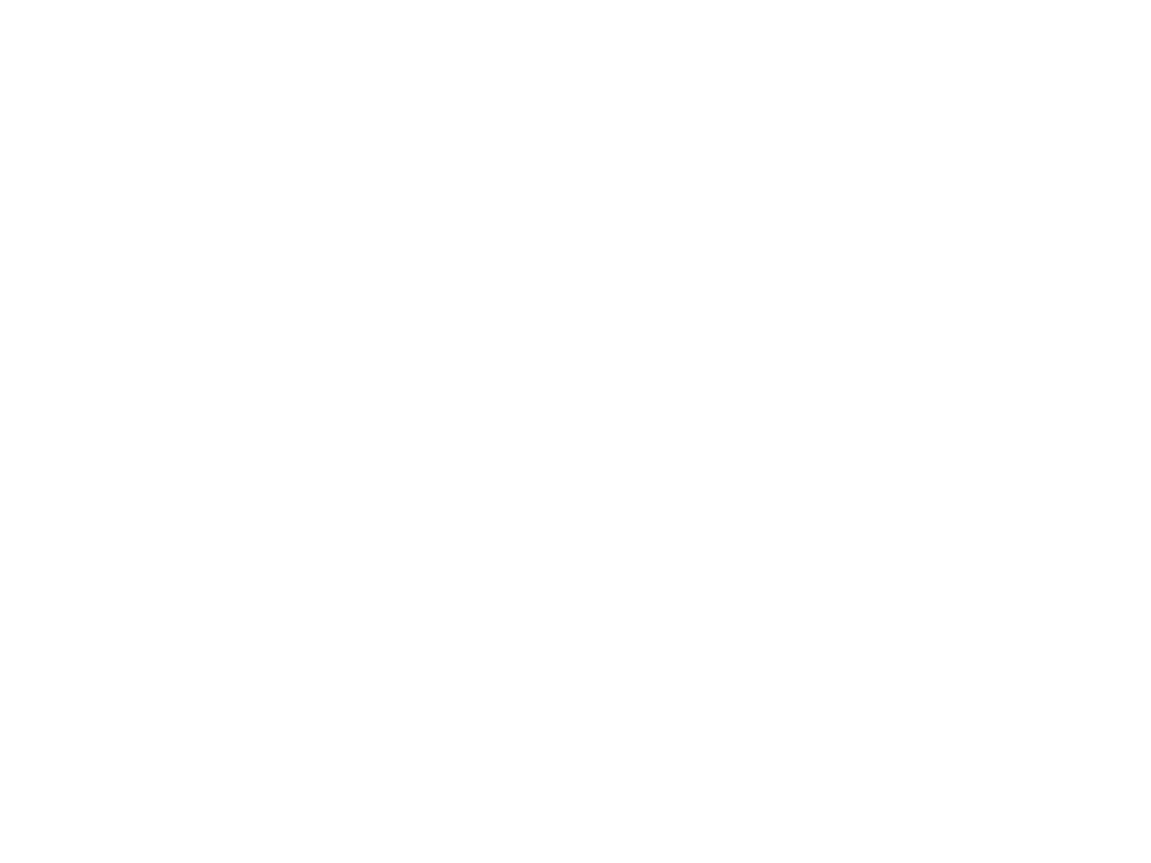

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


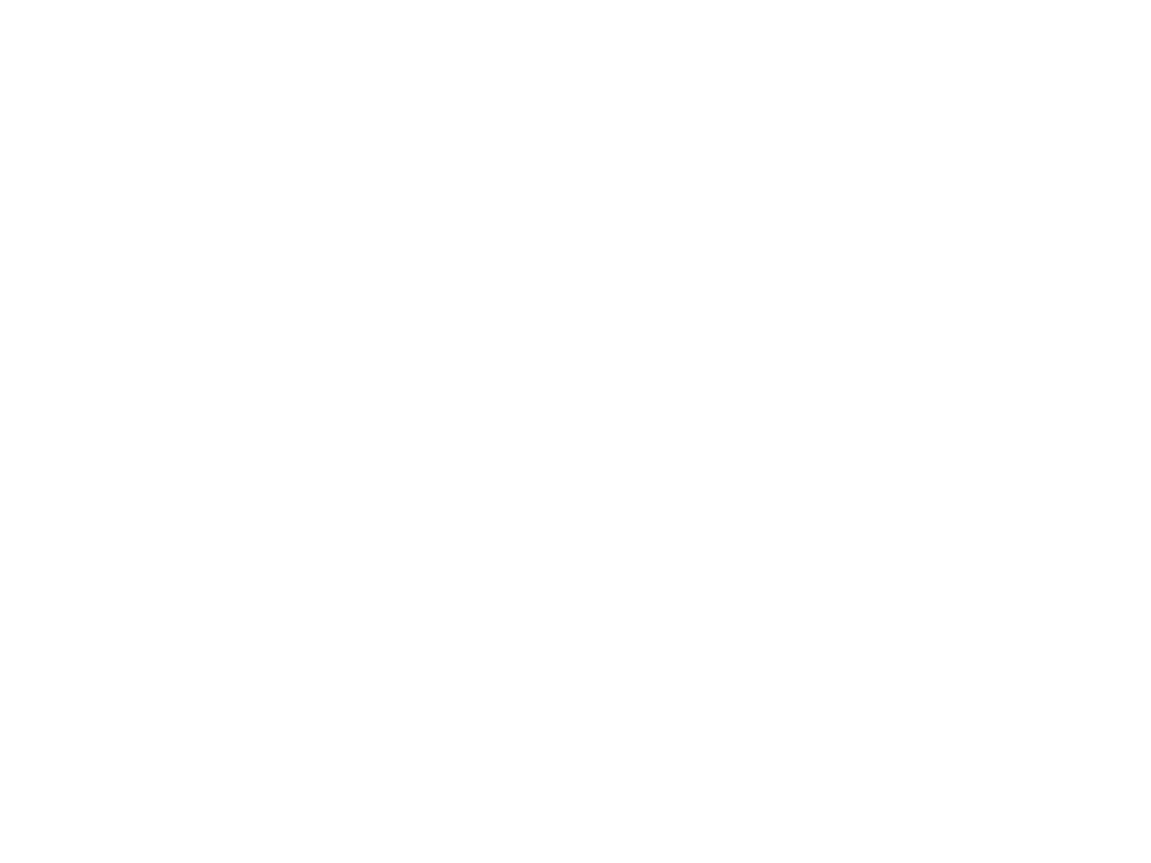

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 4000/22328   13.62     -379.3       0.9436      0.0008493     0.4755          2      
 4100/22328   13.62     -386.1       0.9724      0.0008493     0.4743          2      
 4200/22328   13.35     -398.1       0.9615      0.0008493     0.4734          2      
 4300/22328   13.35     -367.8       0.9499      0.0008493     0.4738          2      
 4400/22328   13.09     -386.7       0.9573      0.0008493     0.4725          2      
 4500/22328   13.09     -380.1       0.9646      0.0008493     0.4722          2      
 4600/22328   12.82     -395.7        0.955      0.0008493     0.4714          2      
 4700/22328   12.82     -364.4       0.9626      0.000

<IPython.core.display.Javascript object>


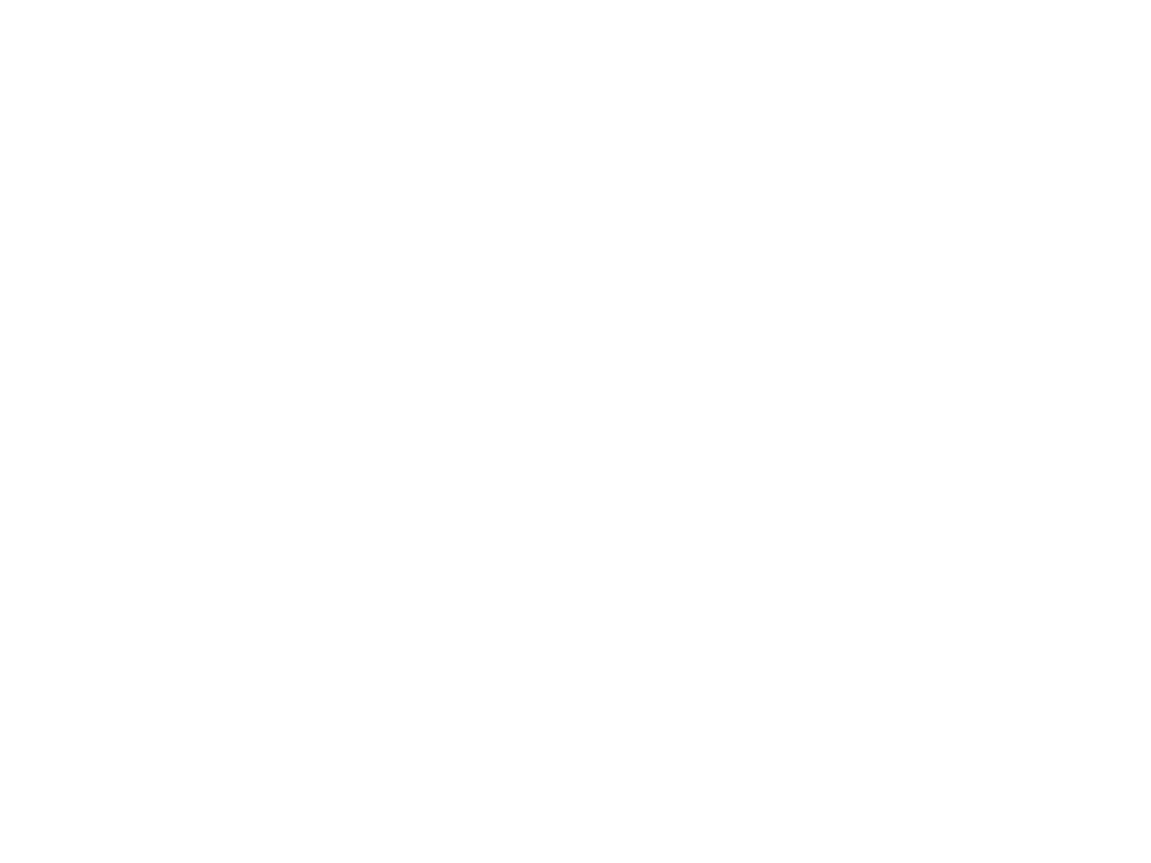

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


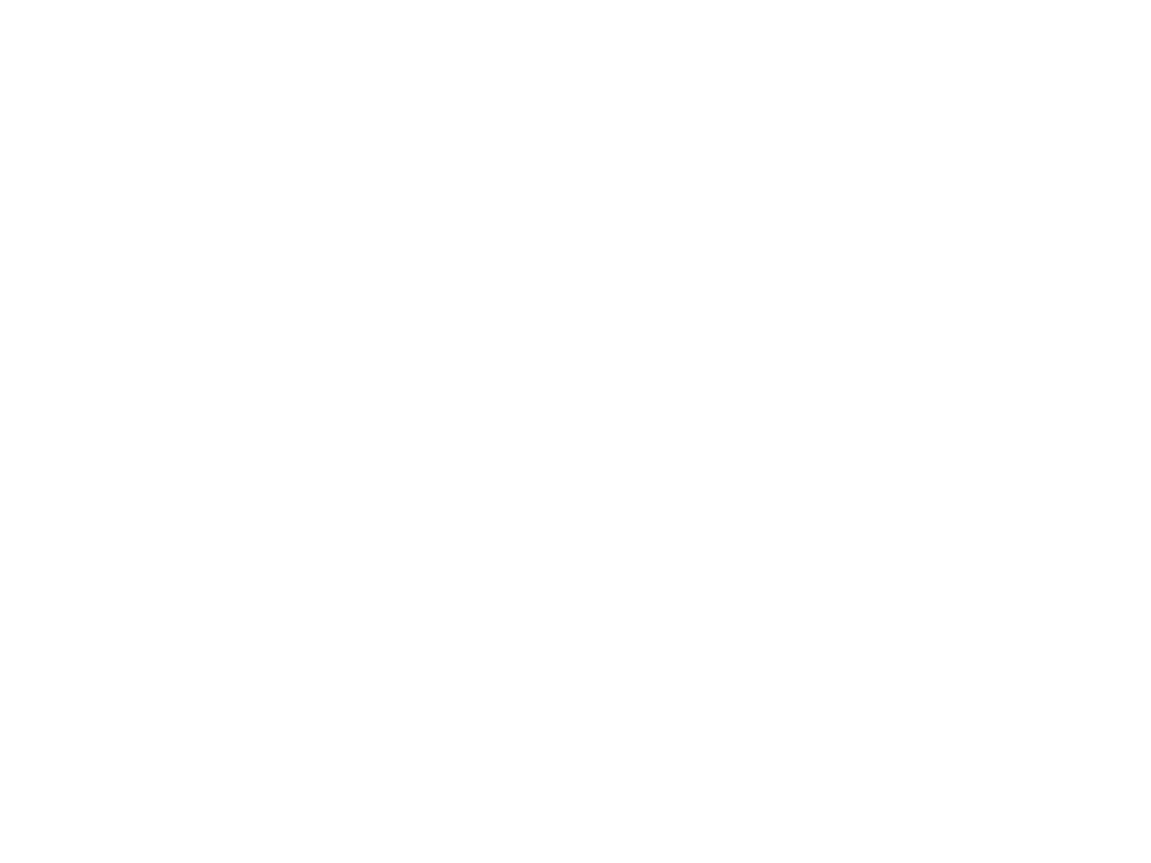

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


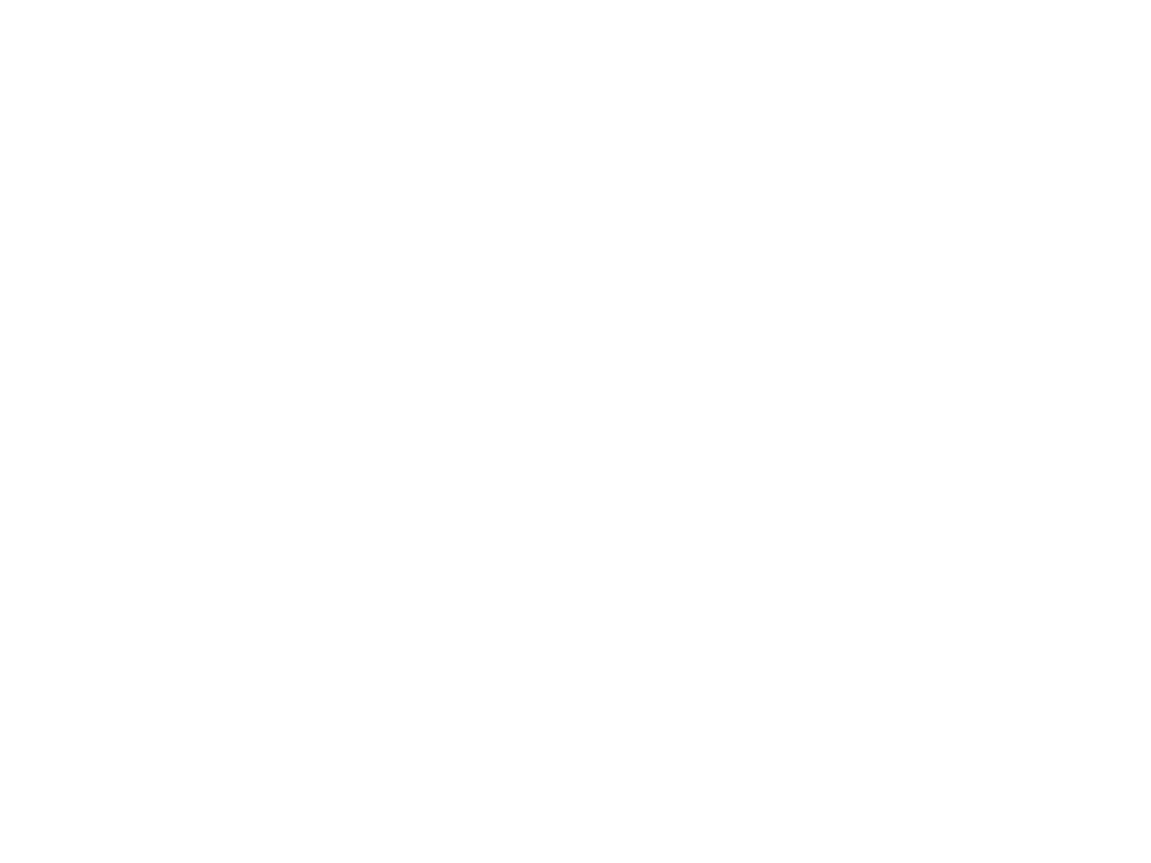

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


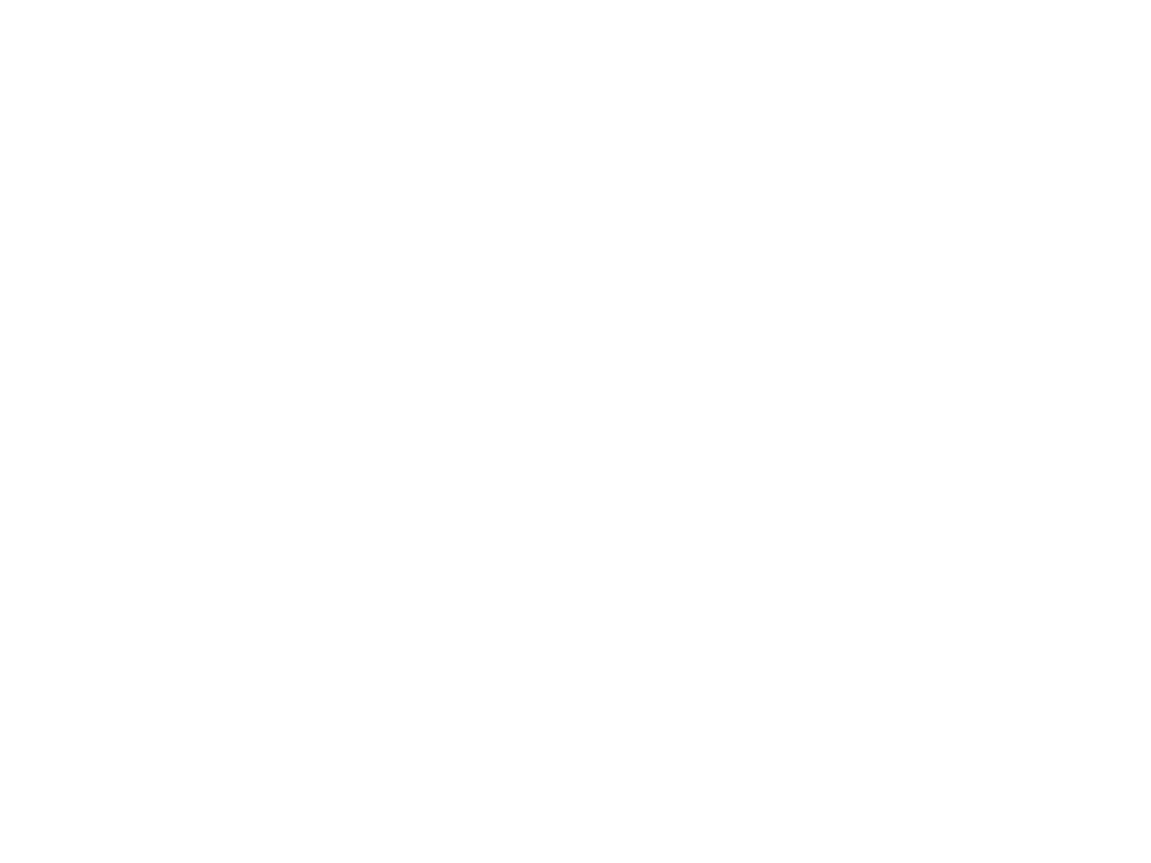

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


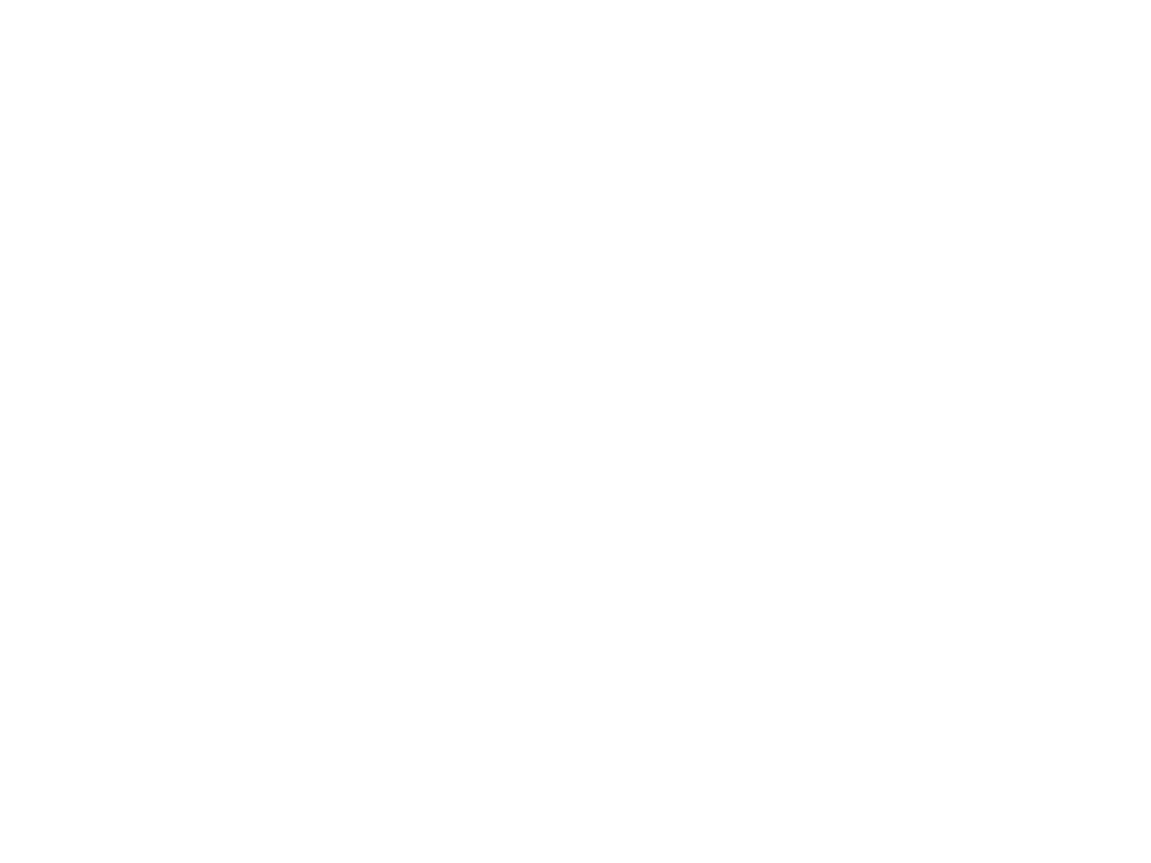

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 5000/22328   12.32     -390.5        0.968      0.0008154      0.47           2      
 5100/22328   12.32     -345.8       0.9194      0.0008154     0.4657          2      
 5200/22328   12.07     -349.2       0.9614      0.0008154     0.4672          2      
 5300/22328   12.07     -371.1       0.9499      0.0008154     0.4677          2      
 5400/22328   11.83     -359.4       0.9587      0.0008154     0.4679          2      
 5500/22328   11.83     -382.7       0.9612      0.0008154     0.4669          2      
 5600/22328   11.59     -363.3       0.9535      0.0008154     0.4661          2      
 5700/22328   11.59     -338.7       0.9512      0.000

<IPython.core.display.Javascript object>


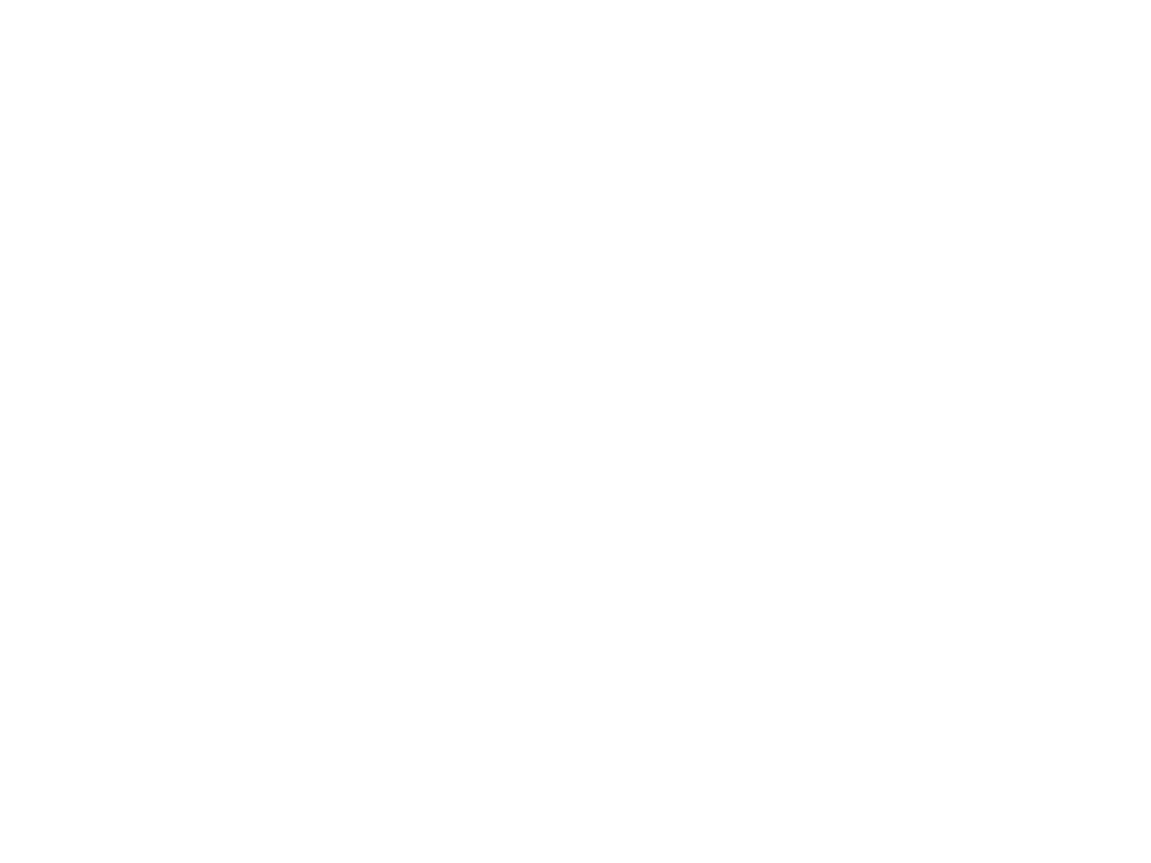

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


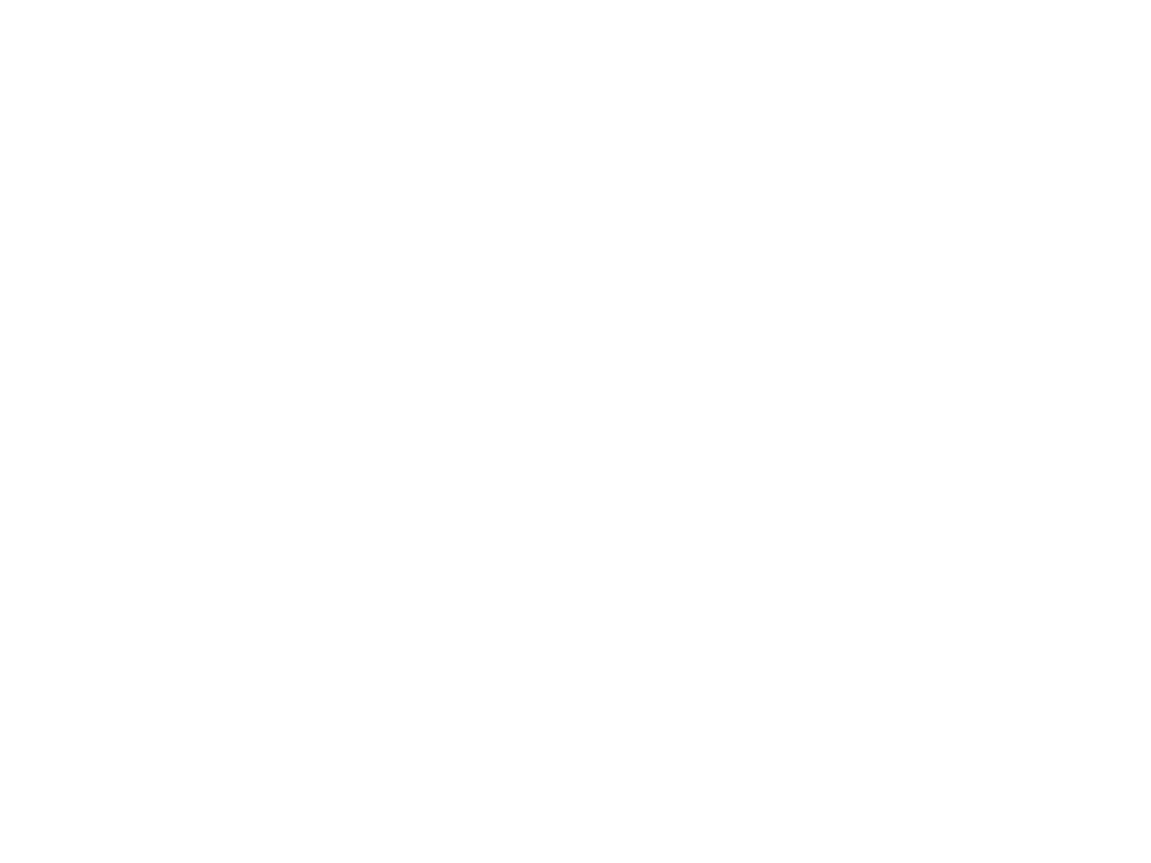

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


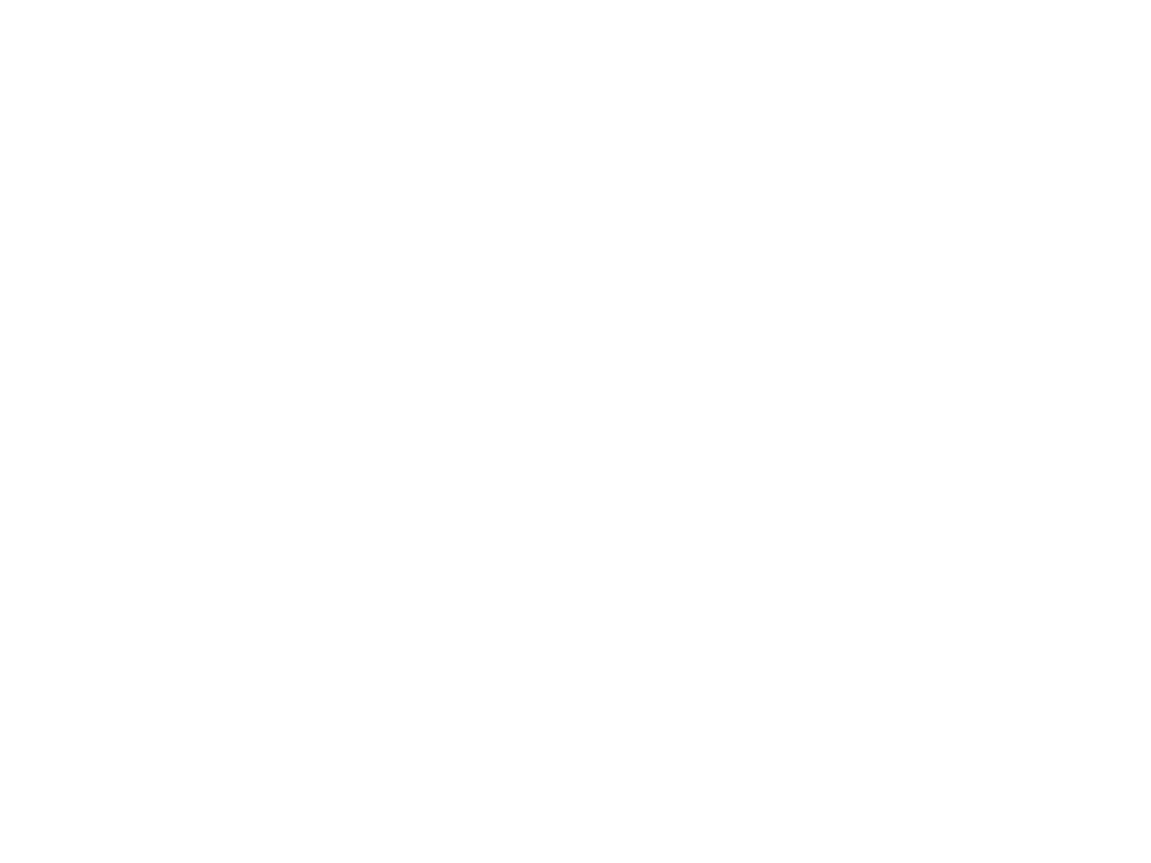

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


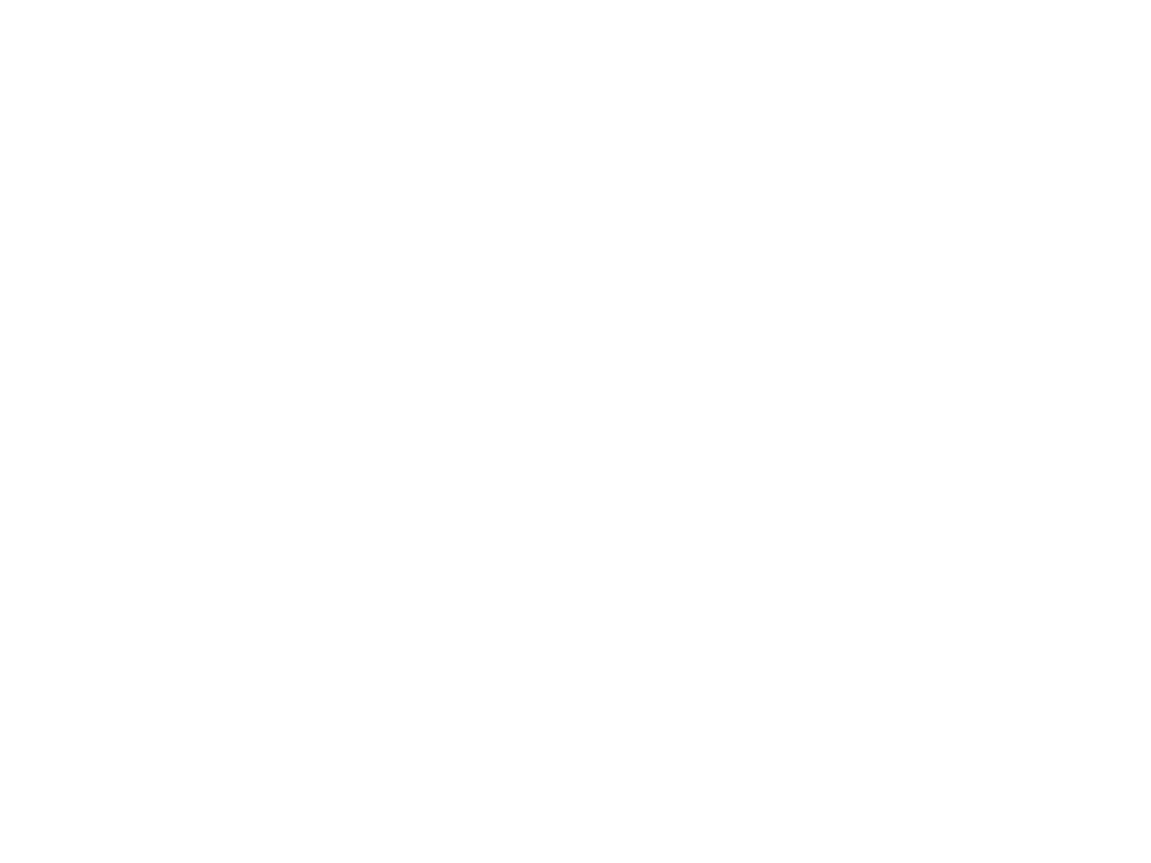

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


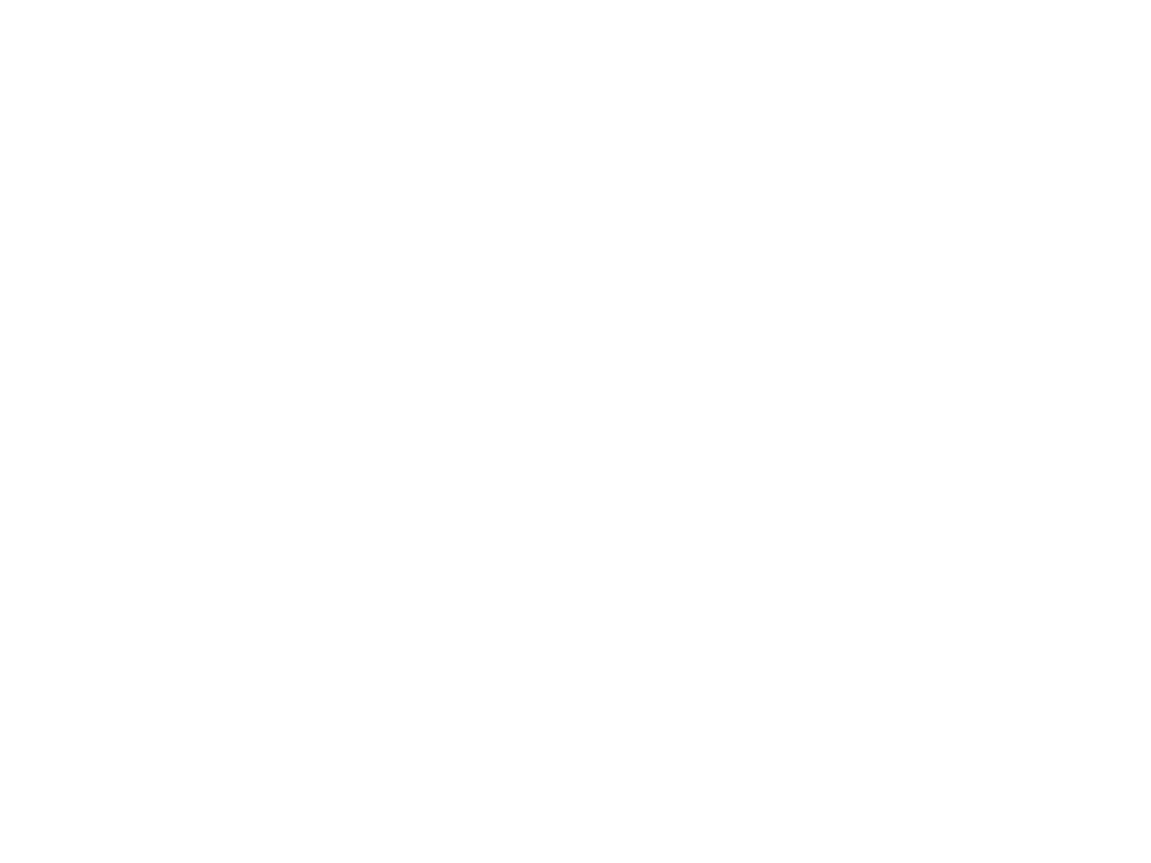

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 6000/22328   11.13      -357        0.9474      0.0007828     0.4655          2      
 6100/22328   11.13     -367.2       0.9681      0.0007828     0.4653          2      
 6200/22328   10.91     -375.4       0.9437      0.0007828     0.4644          2      
 6300/22328   10.91     -380.5       0.9533      0.0007828      0.464          2      
 6400/22328   10.69     -358.5       0.9645      0.0007828     0.4651          2      
 6500/22328   10.69     -350.2       0.9474      0.0007828     0.4638          2      
 6600/22328   10.48     -382.4       0.9651      0.0007828     0.4633          2      
 6700/22328   10.48     -344.9       0.9496      0.000

<IPython.core.display.Javascript object>


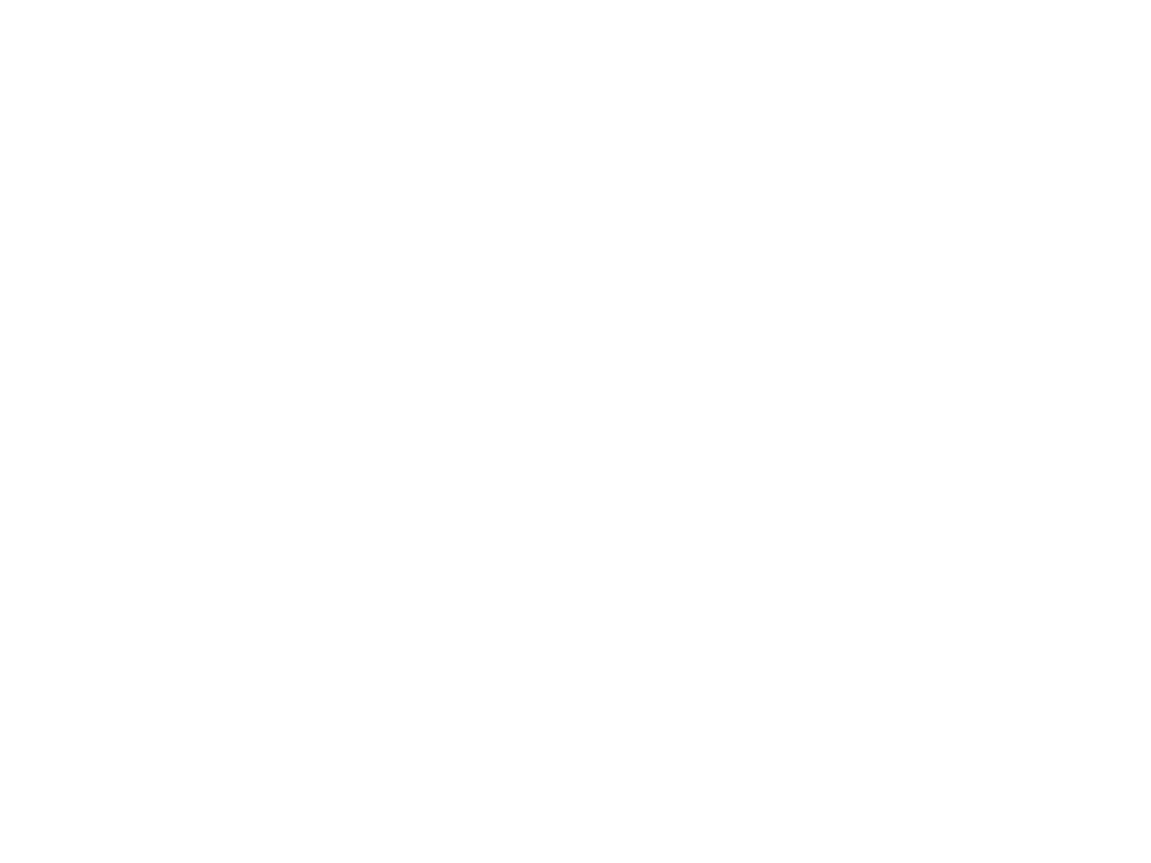

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


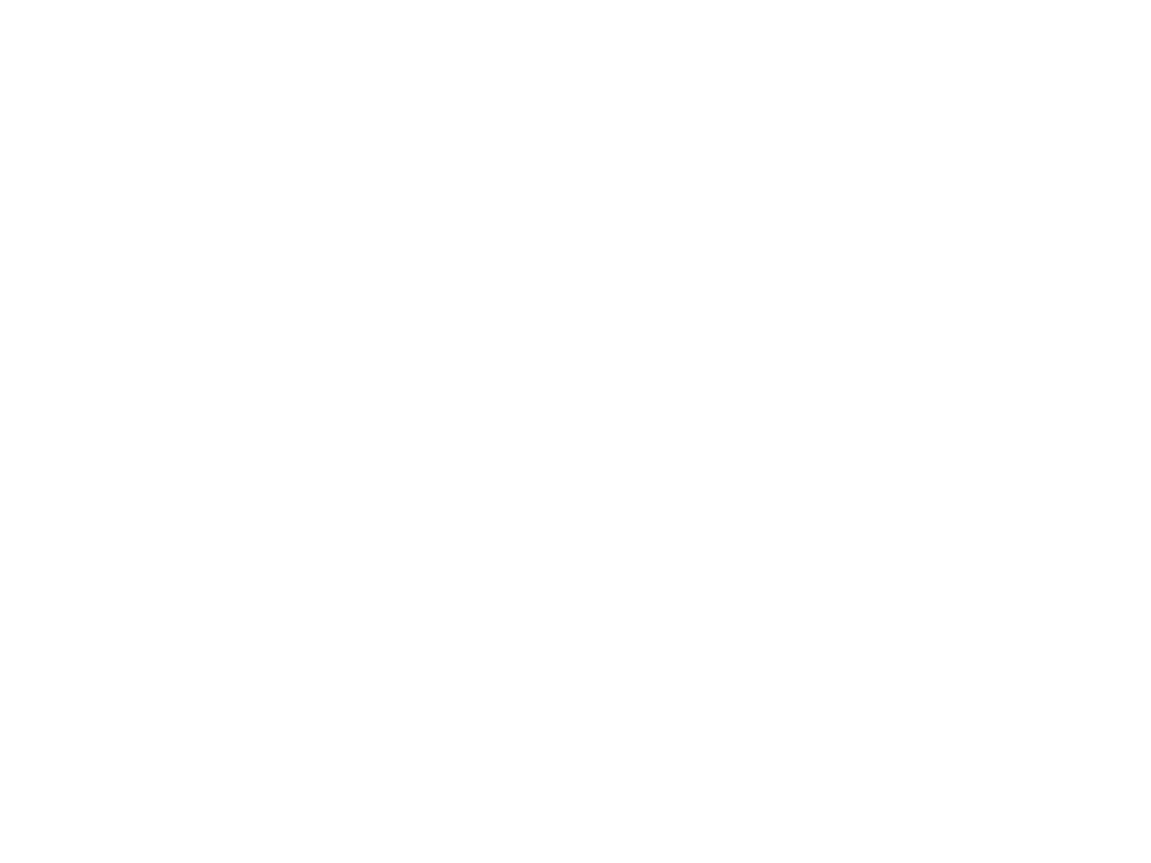

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


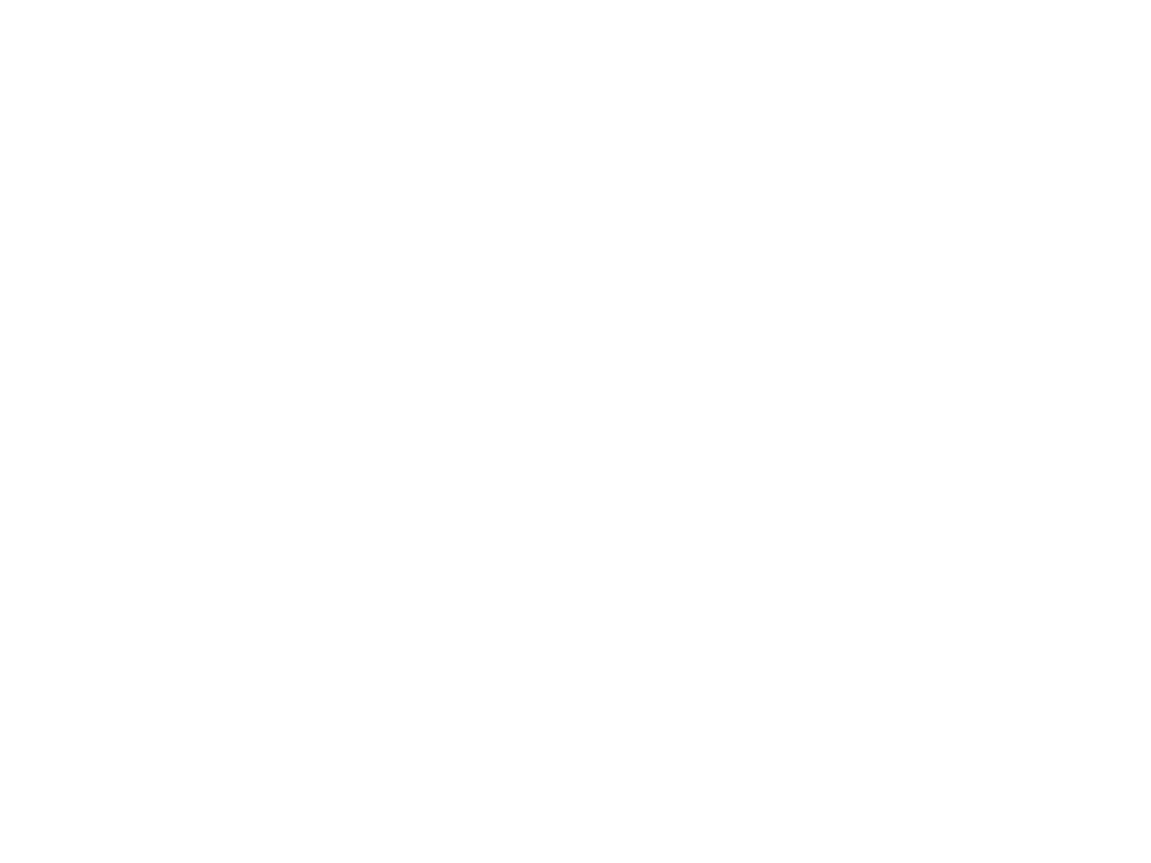

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


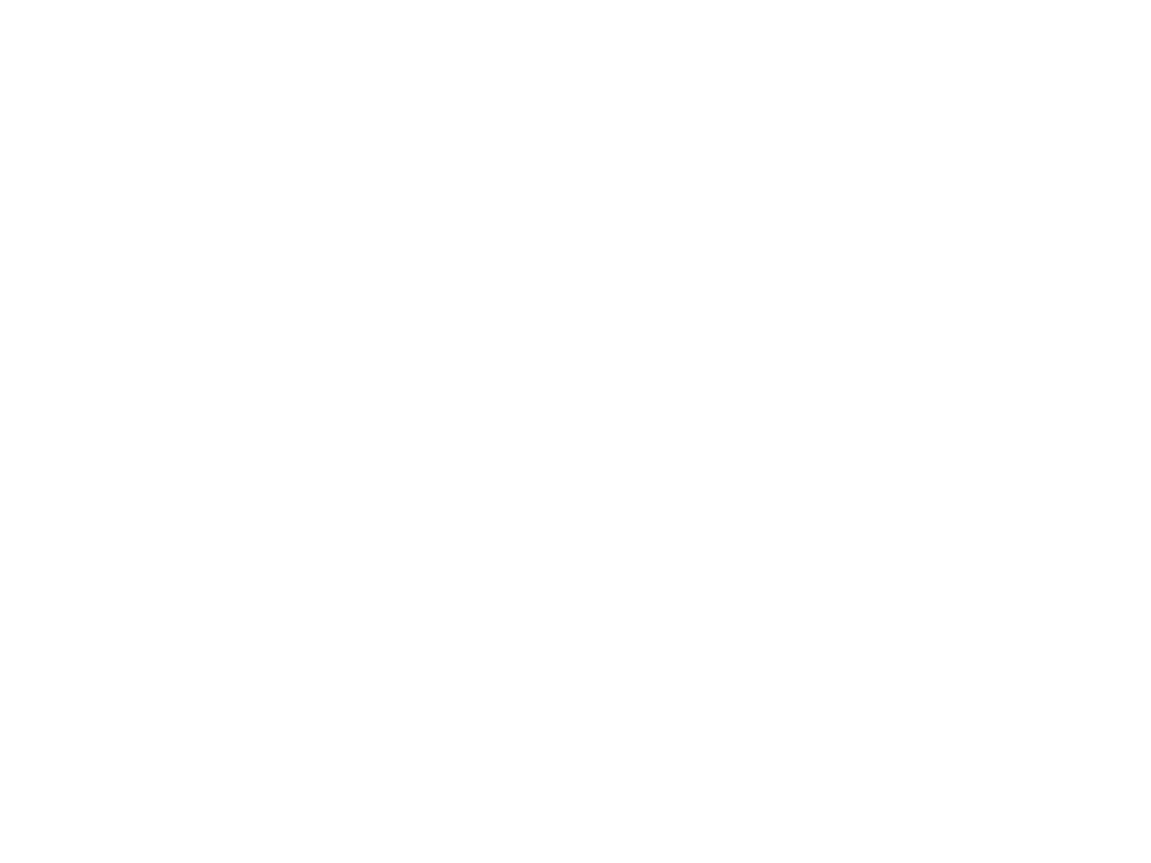

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


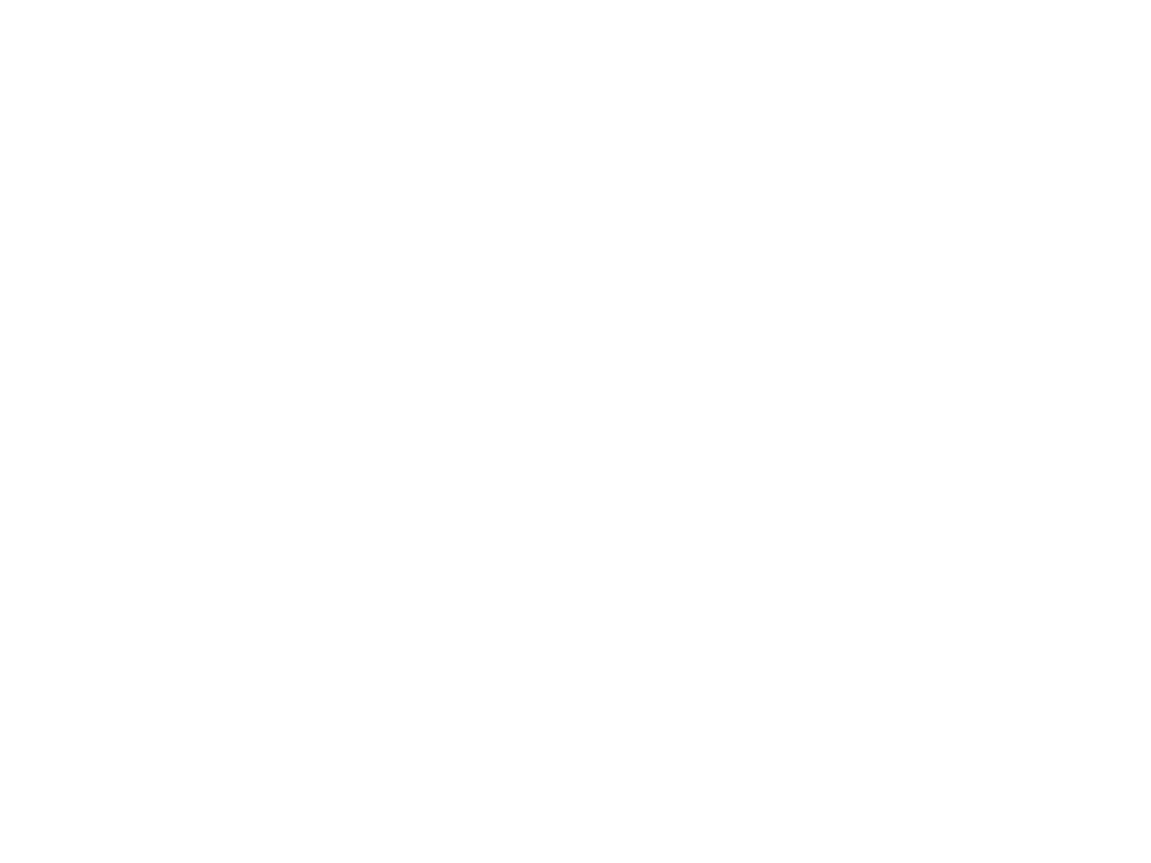

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 7000/22328   10.06     -380.1       0.9571      0.0007514     0.4624          2      
 7100/22328   10.06     -376.2       0.9677      0.0007514     0.4622          2      
 7200/22328   9.861     -357.4       0.9374      0.0007514     0.4605          2      
 7300/22328   9.861     -360.8       0.9172      0.0007514     0.4621          2      
 7400/22328   9.664     -377.6       0.9497      0.0007514     0.4607          2      
 7500/22328   9.664     -350.5       0.9591      0.0007514     0.4601          2      
 7600/22328   9.471     -341.5       0.9643      0.0007514     0.4601          2      
 7700/22328   9.471     -379.9       0.9678      0.000

<IPython.core.display.Javascript object>


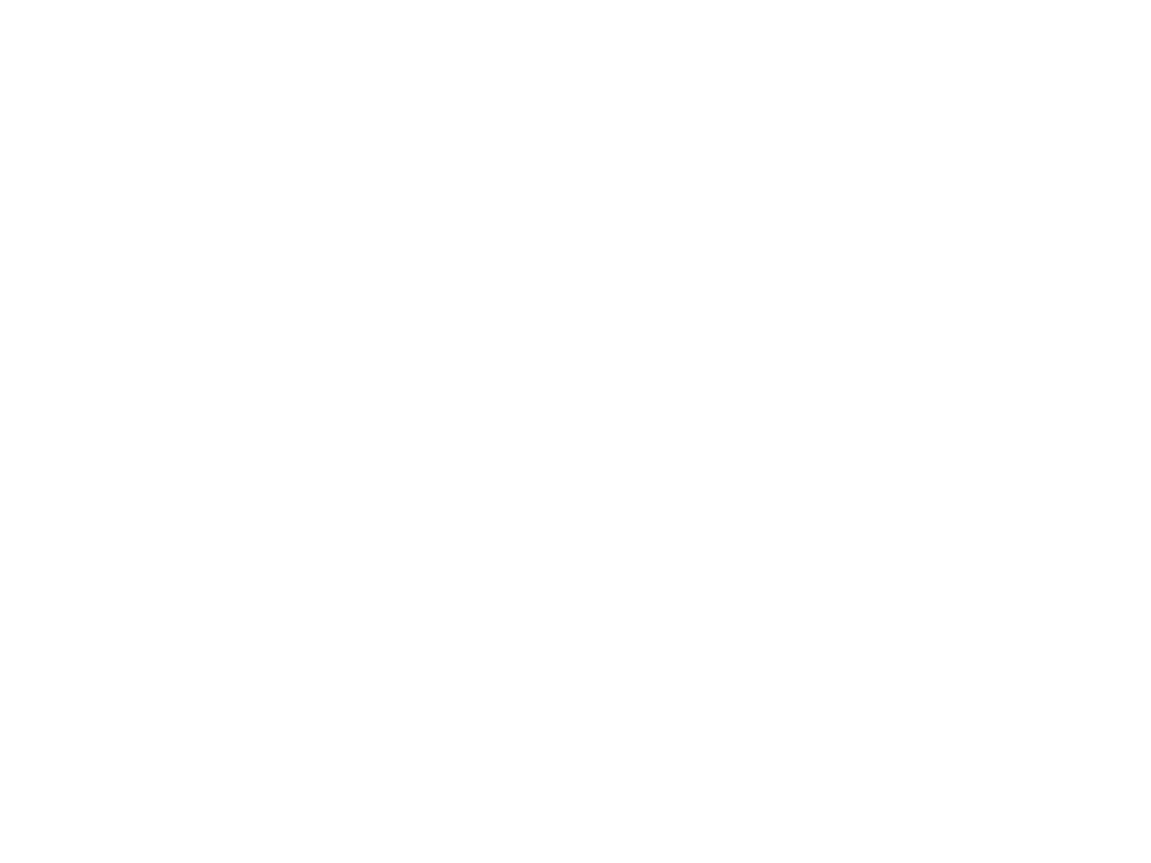

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


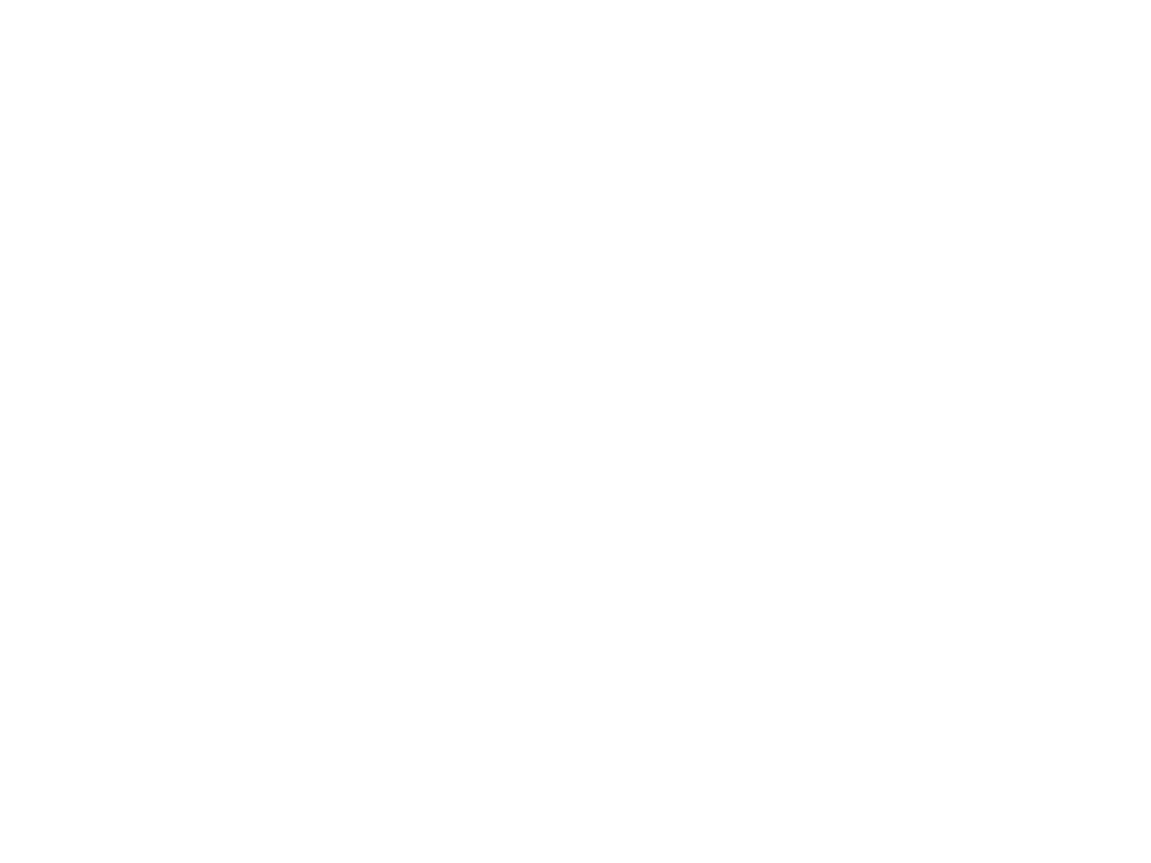

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


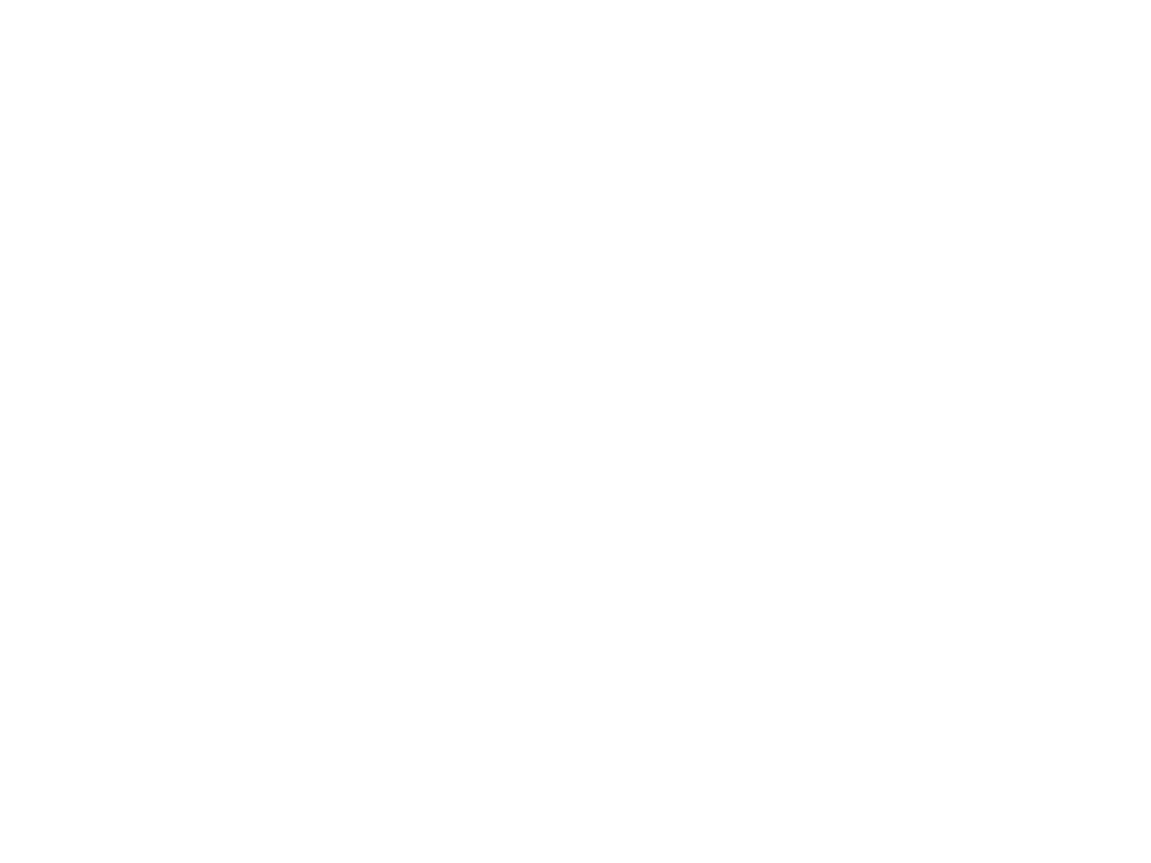

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


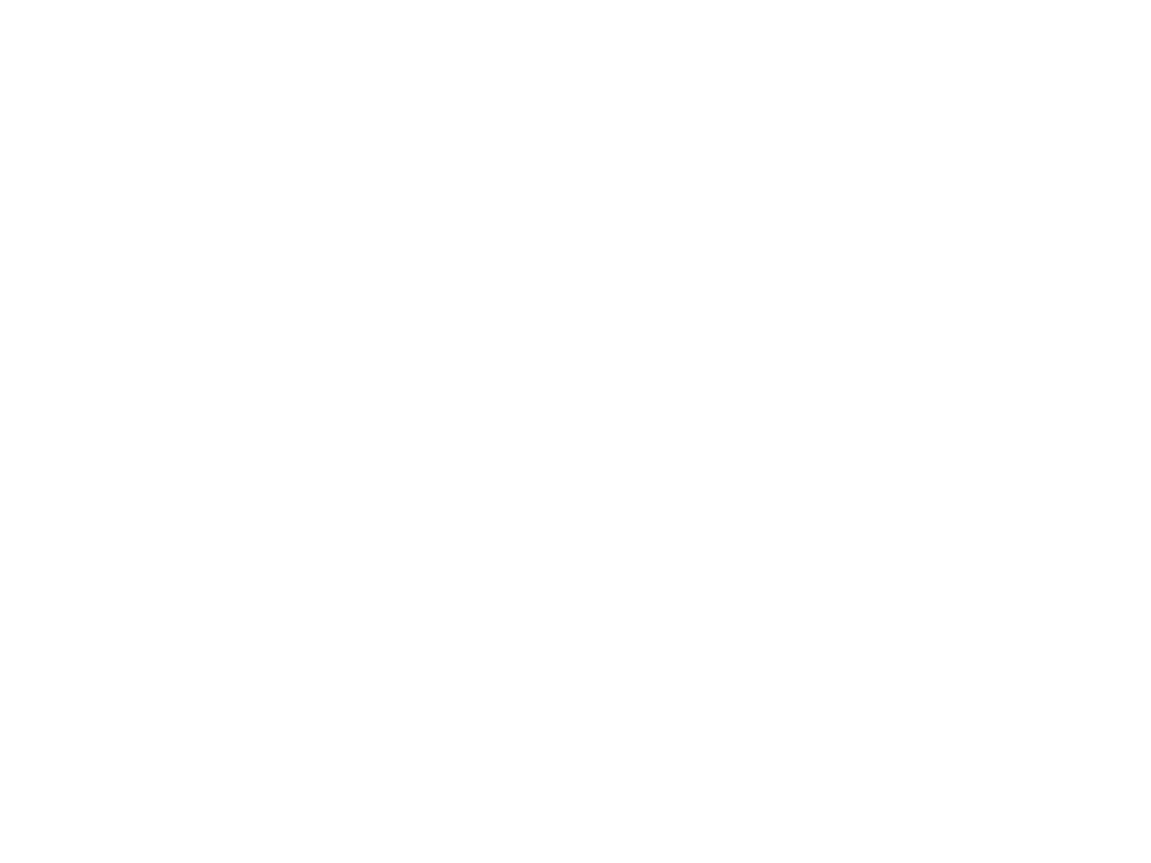

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


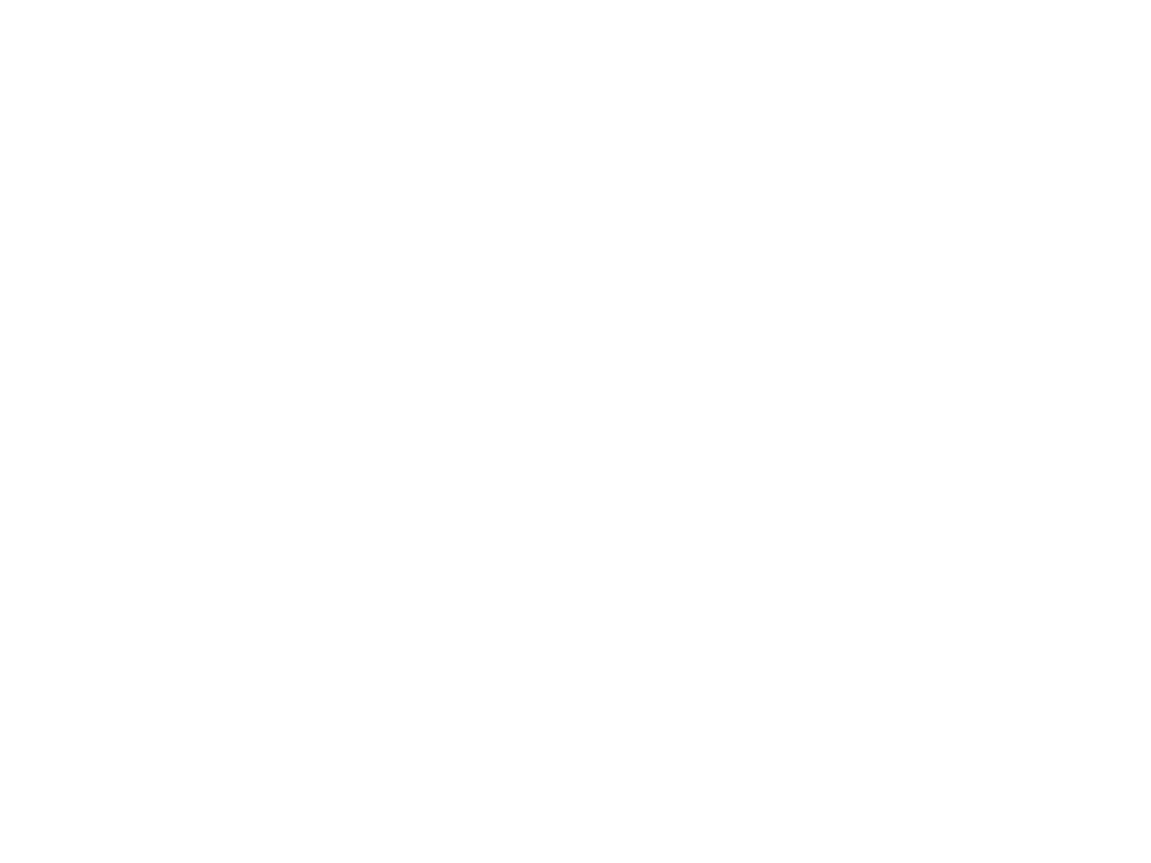

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 8000/22328   9.096     -359.2        0.967      0.0007214     0.4585          2      
 8100/22328   9.096     -367.4       0.9661      0.0007214     0.4577          2      
 8200/22328   8.914     -365.4       0.9528      0.0007214     0.4581          2      
 8300/22328   8.914     -329.7       0.9465      0.0007214     0.4577          2      
 8400/22328   8.736     -355.3       0.9482      0.0007214     0.4576          2      
 8500/22328   8.736     -342.6       0.9111      0.0007214      0.458          2      
 8600/22328   8.561     -358.9       0.9544      0.0007214     0.4569          2      
 8700/22328   8.561     -371.5       0.9256      0.000

<IPython.core.display.Javascript object>


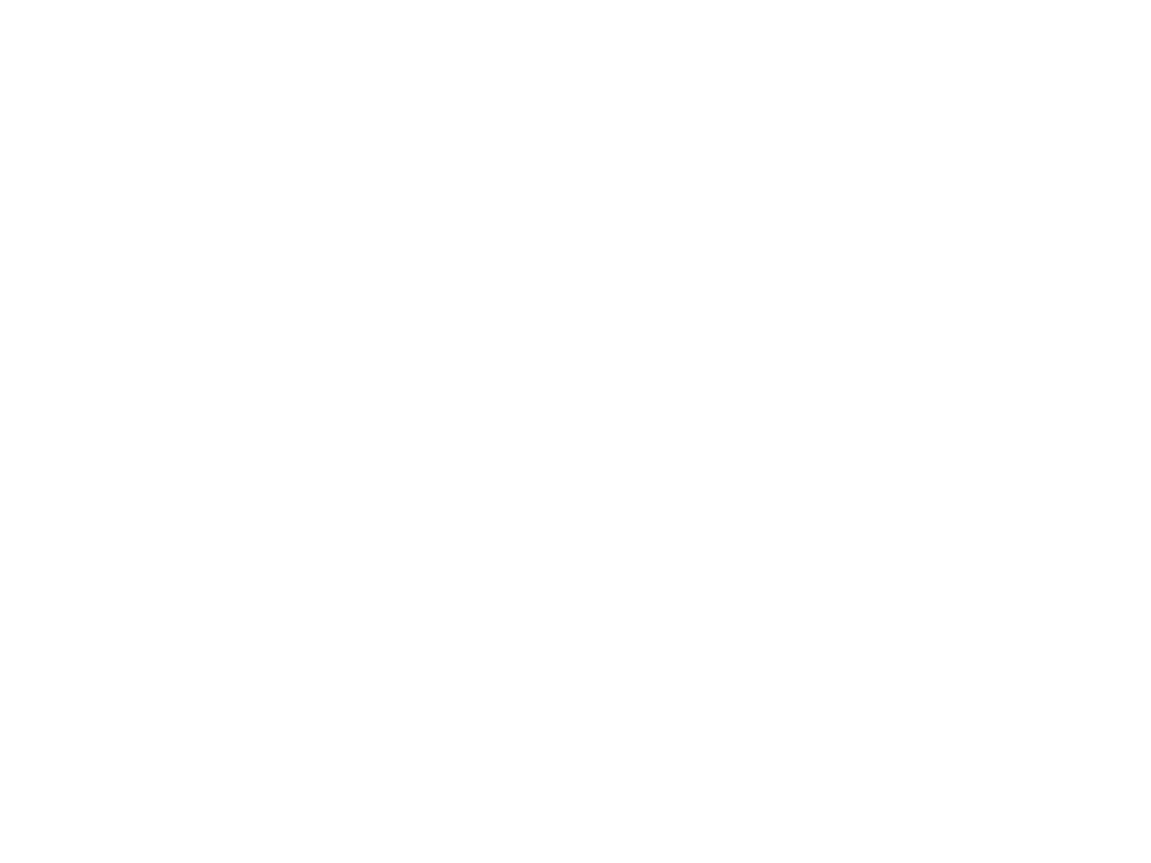

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


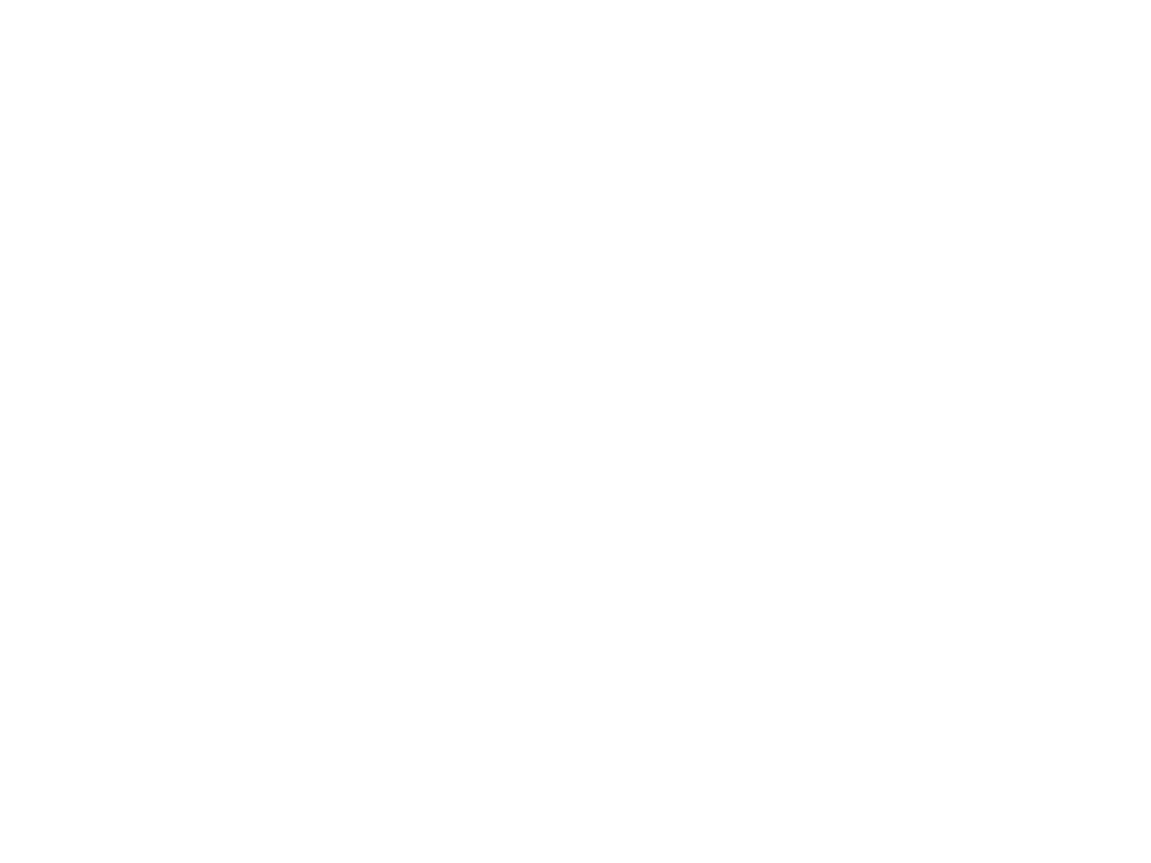

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


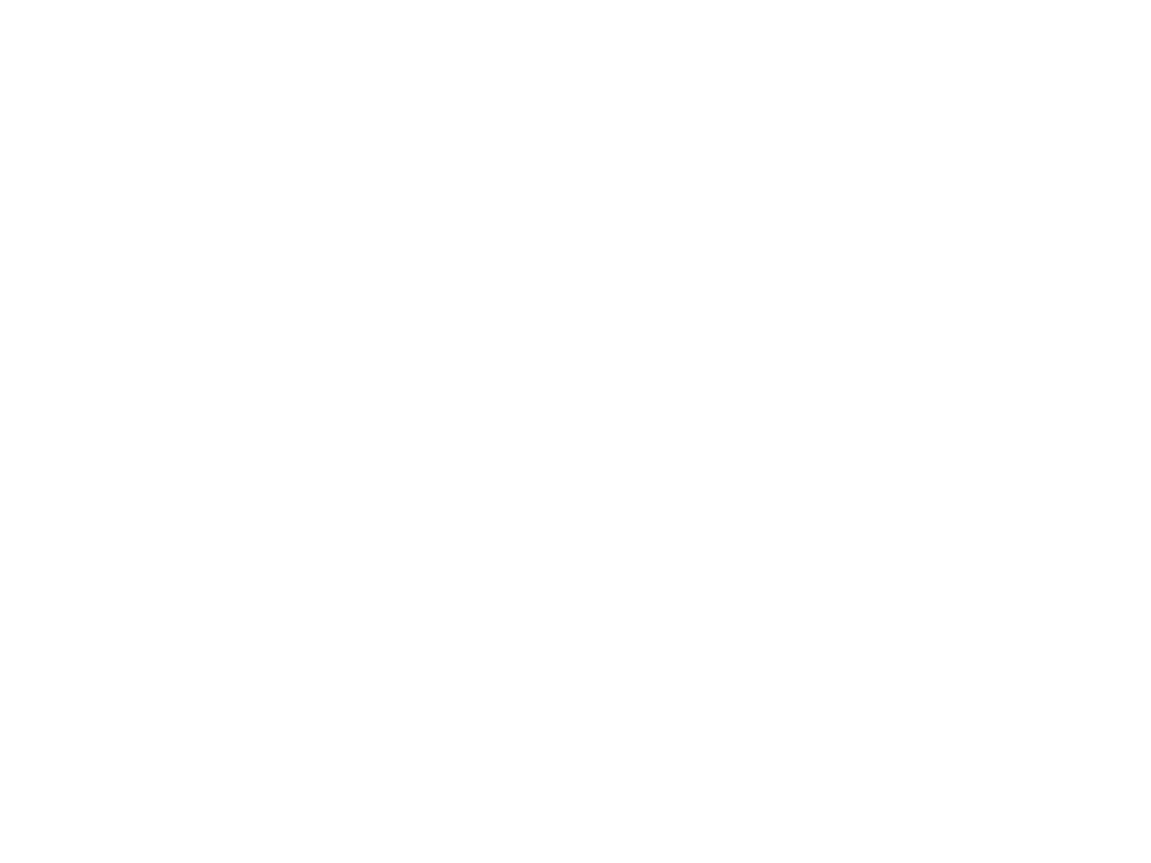

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


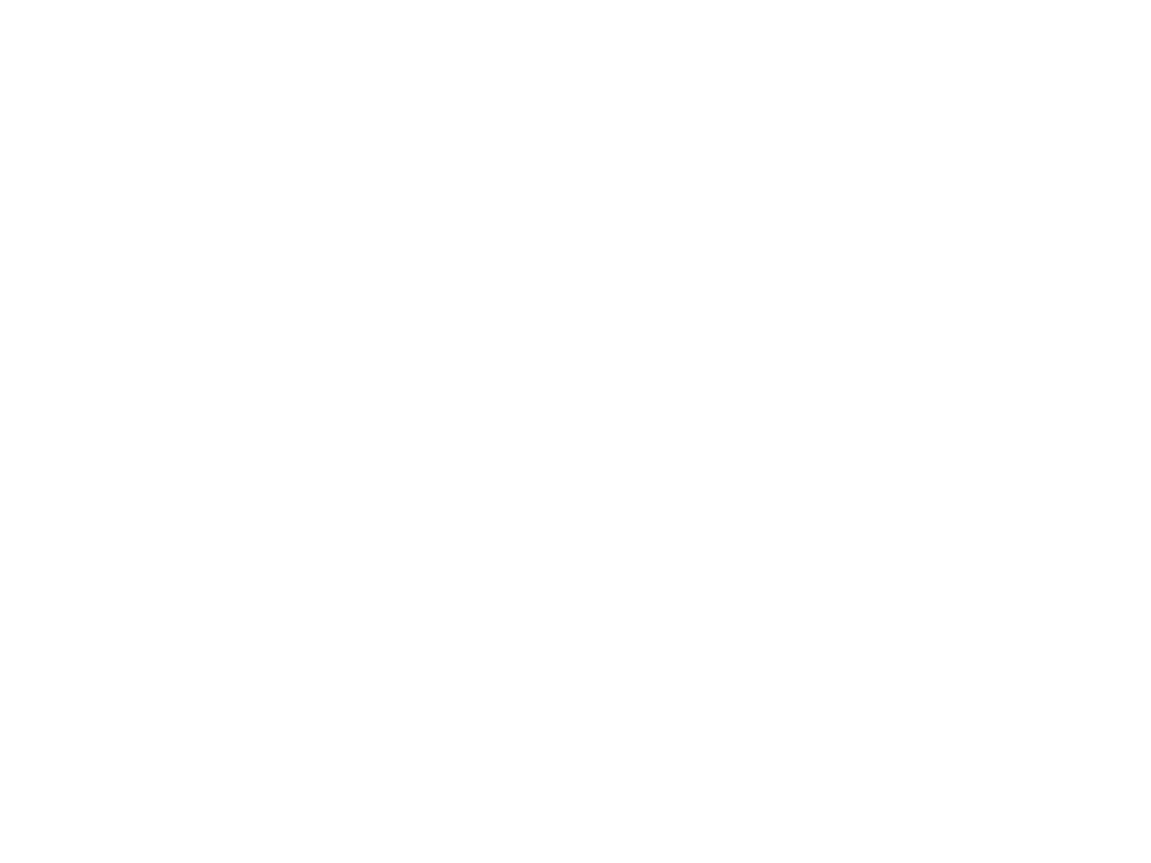

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


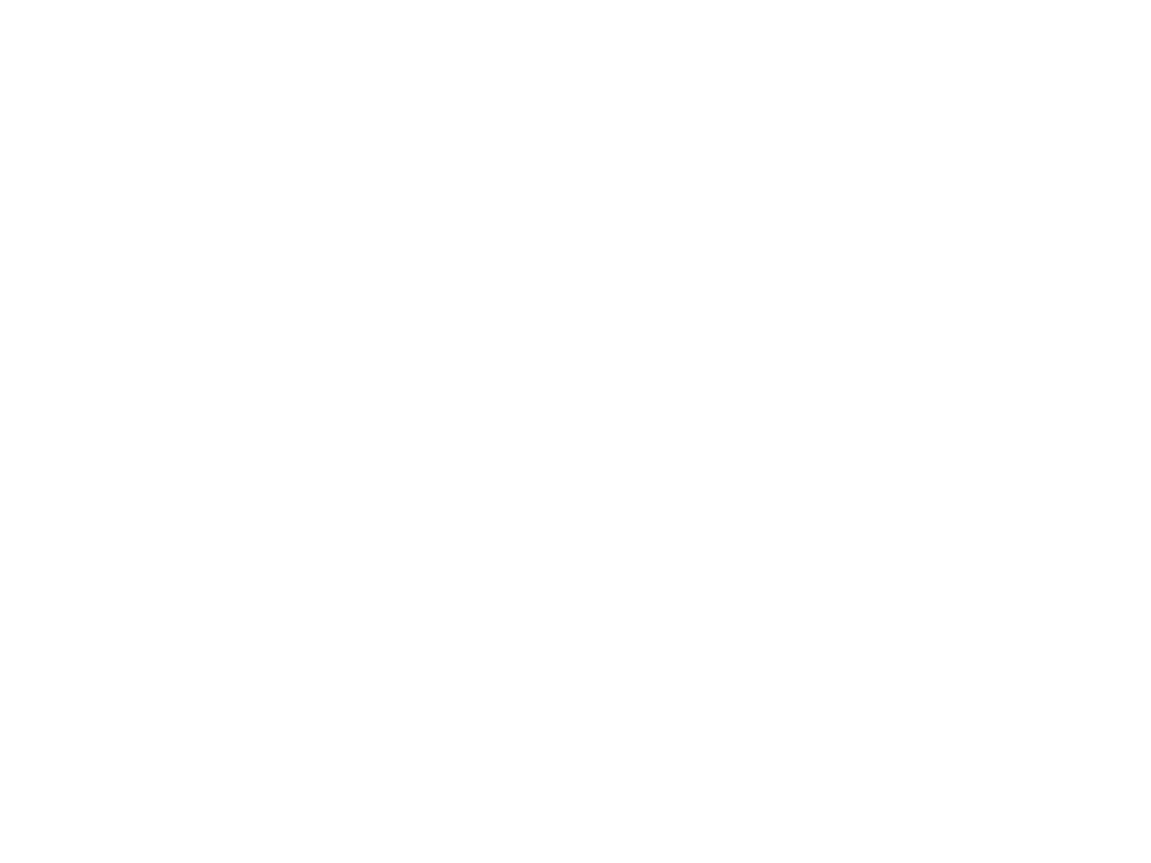

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf

Tunneling rate decreased.
Change in tunneling rate (temp = 1): -0.04121356806657227
Change in tunneling rate (temp = 8.39): 0.00018203277388439965
Slowing down annealing schedule and resetting temperature.
Annealing steps: 200 --> 220
Temperature: 8.39 --> 8.39

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
 9000/22328    8.39     -361.8       0.9502      0.0006925     0.4548          2      
 9100/22328   8.222     -367.7       0.9578      0.0006925     0.4546          2      
 9200/22328   8.222     -343.5       0.9644      0.0006925     0.4548          2      
 9300/22328   8.058      -351        0.9451      0.0006925      0.455          2      
 9400/22328   8.058     -346.3       0.9598      0.

<IPython.core.display.Javascript object>


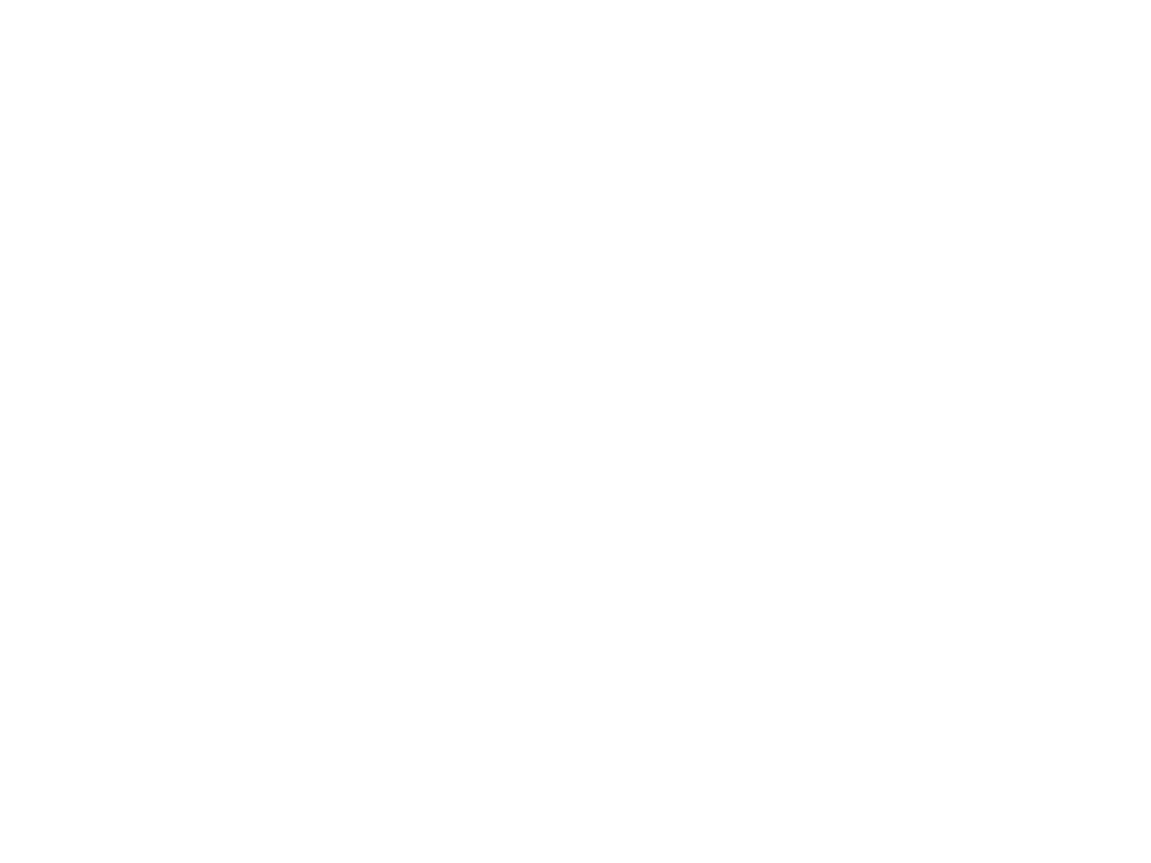

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


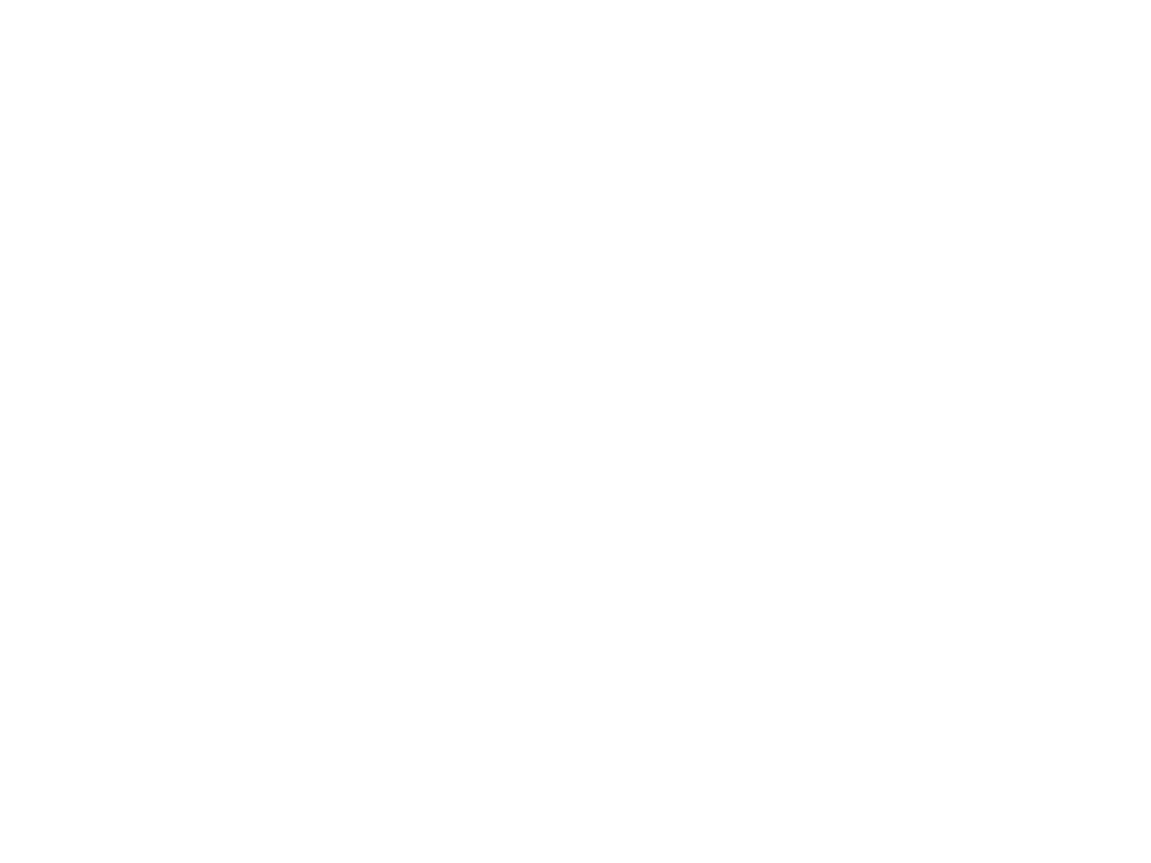

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


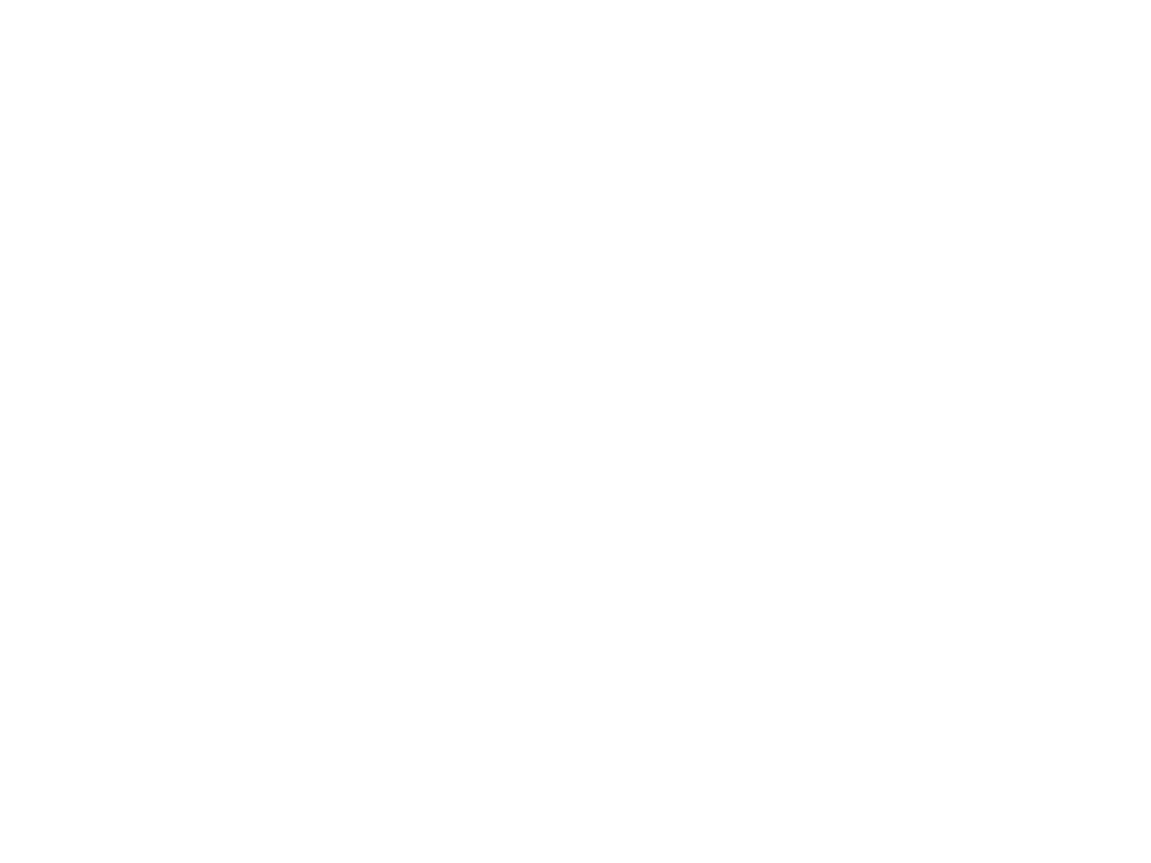

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


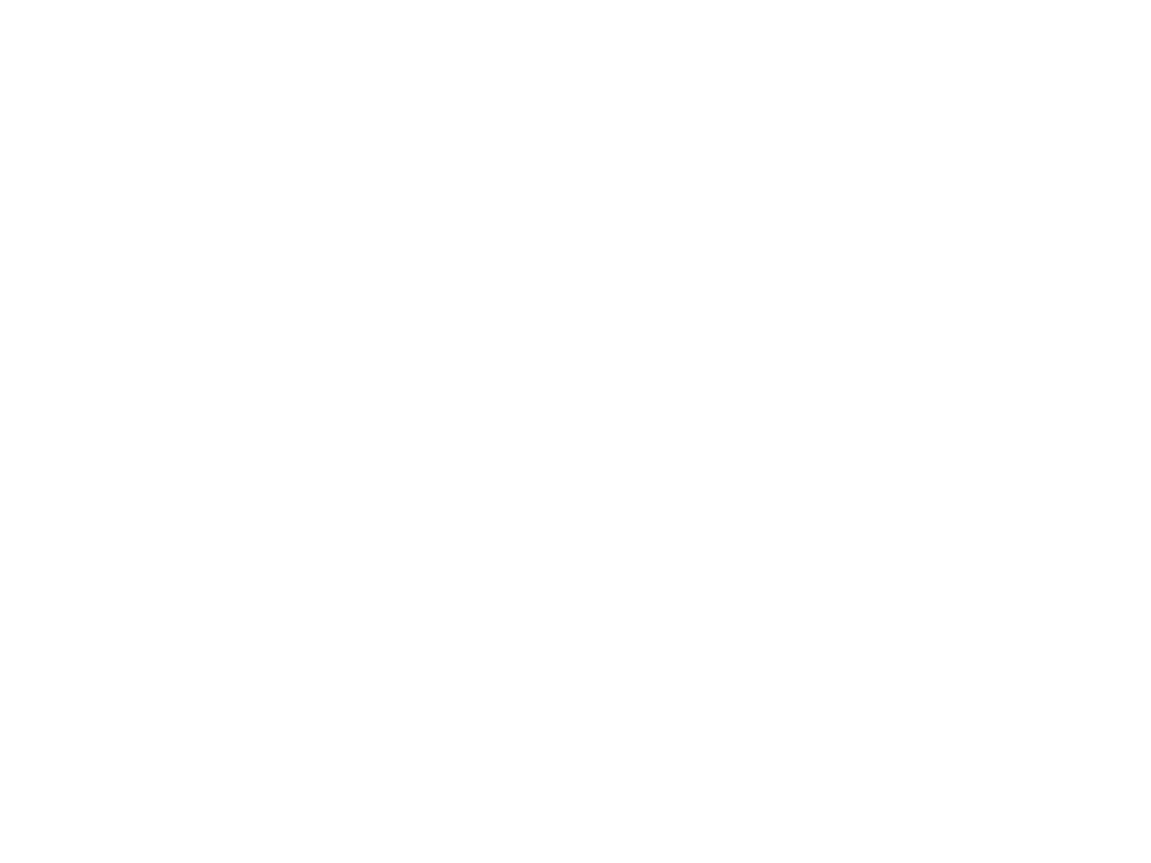

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


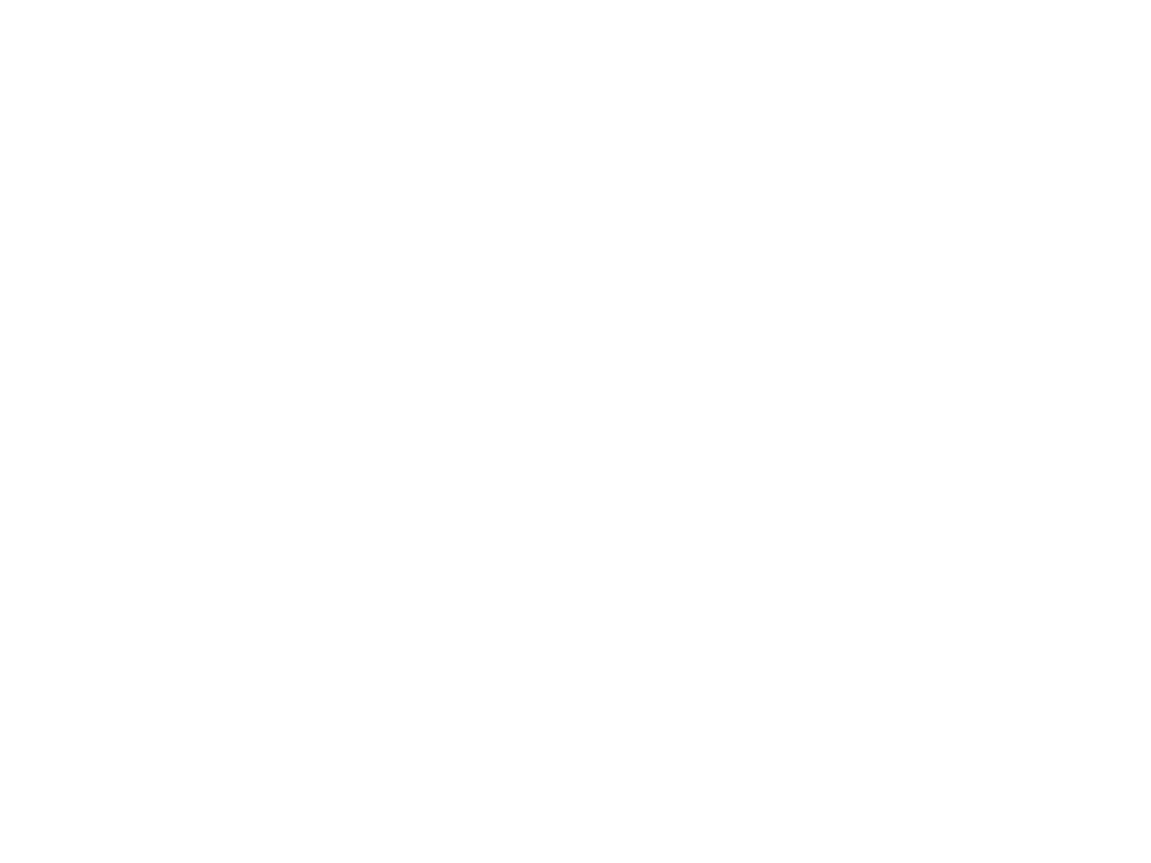

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
10000/22328   7.584     -352.8       0.9336      0.0006648     0.4501          2      
10100/22328   7.584     -347.2       0.9533      0.0006648     0.4498          2      
10200/22328   7.432     -327.5       0.9423      0.0006648     0.4495          2      
10300/22328   7.432     -342.2       0.9483      0.0006648     0.4503          2      
10400/22328   7.283     -357.8        0.943      0.0006648     0.4494          2      
10500/22328   7.283     -363.2       0.9543      0.0006648     0.4493          2      
10600/22328   7.138     -339.8       0.9561      0.0006648     0.4499          2      
10700/22328   7.138     -374.7       0.9475      0.000

<IPython.core.display.Javascript object>


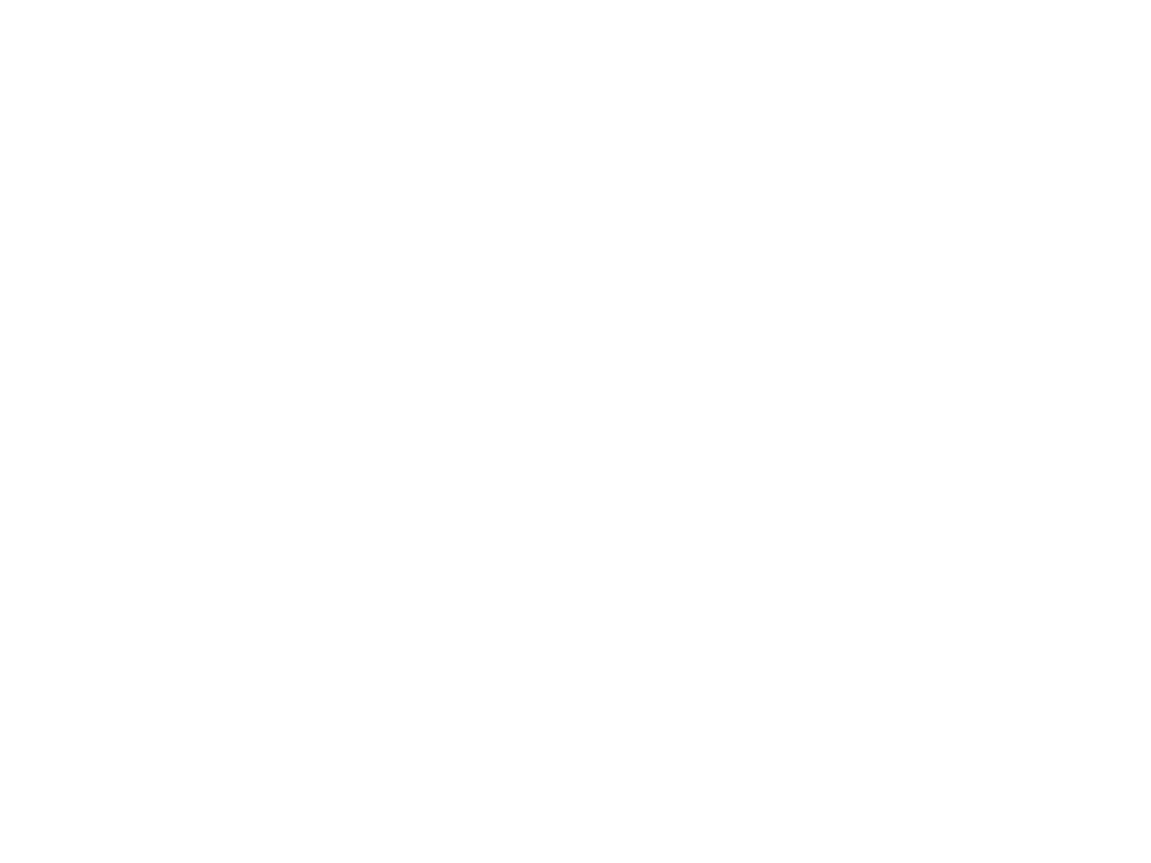

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


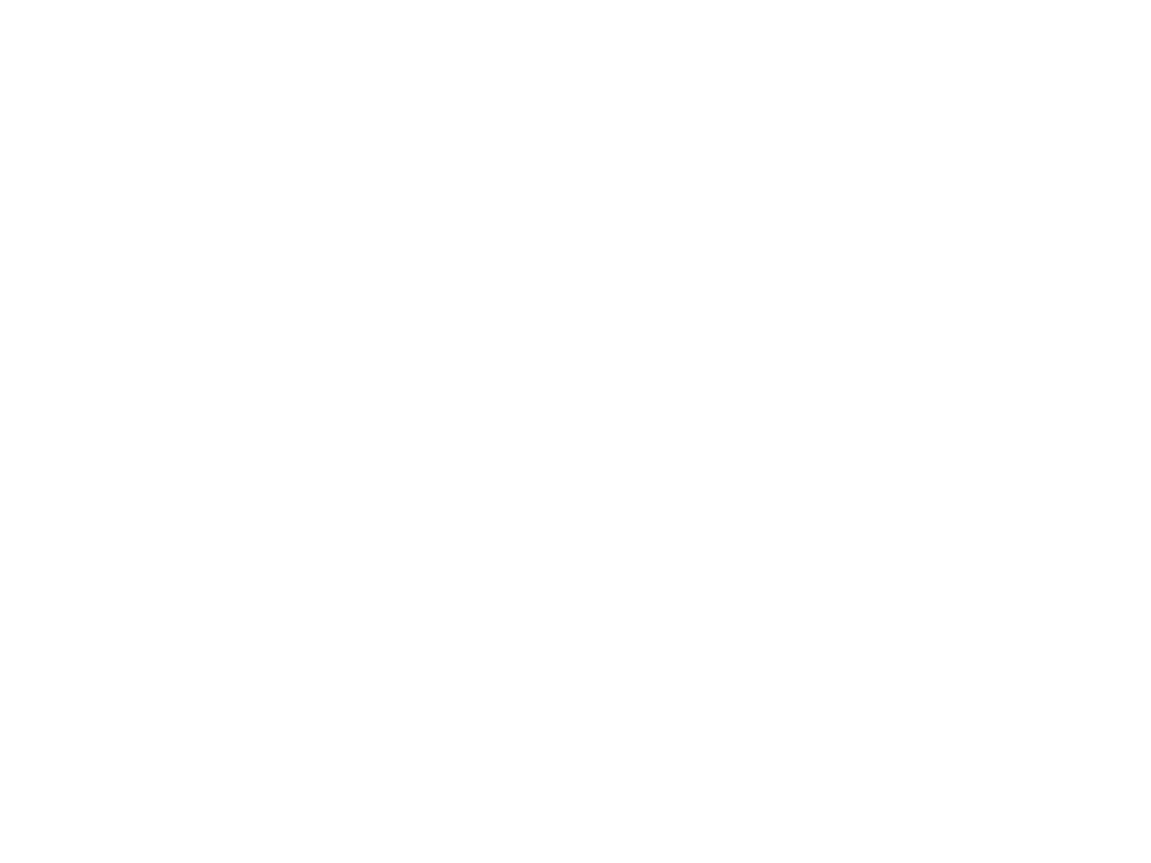

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


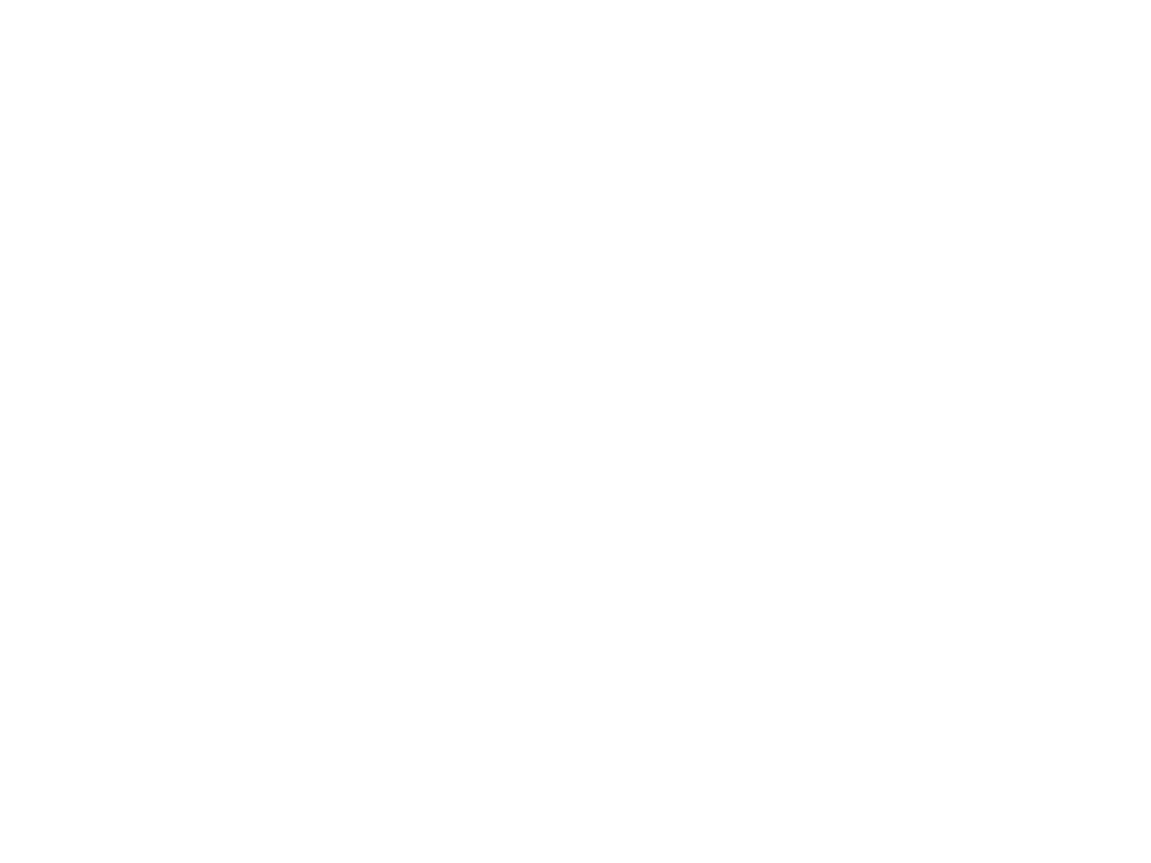

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


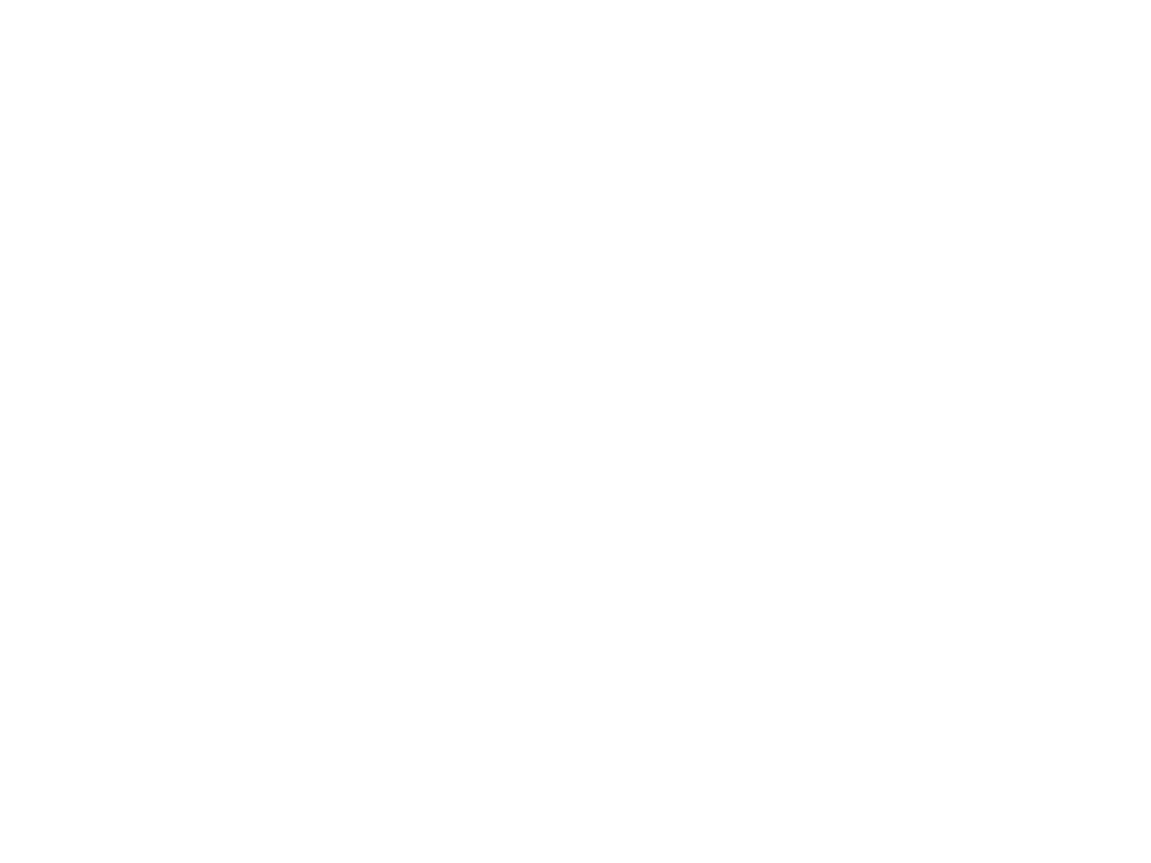

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


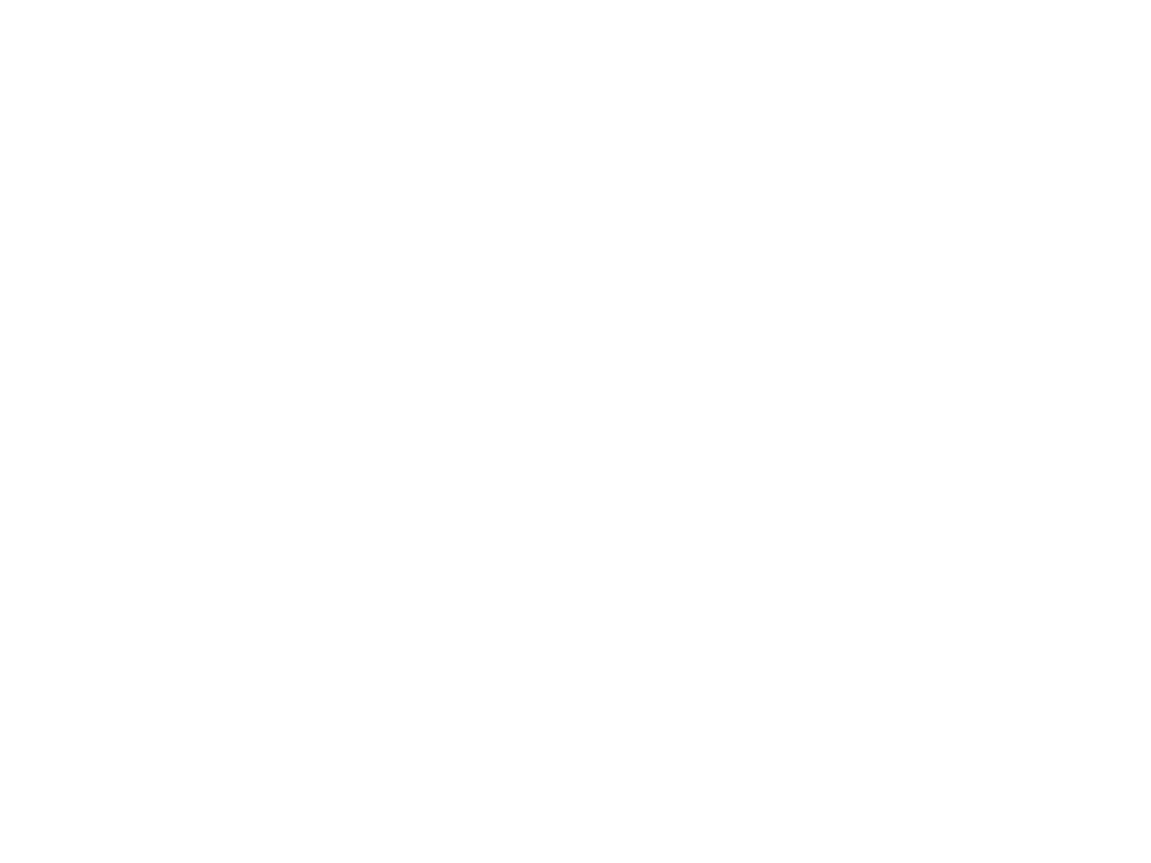

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
11000/22328   6.855     -344.1       0.9372      0.0006382     0.4487          2      
11100/22328   6.855     -314.5       0.8308      0.0006382     0.4478          2      
11200/22328   6.855     -343.1       0.9421      0.0006382     0.4475          2      
11300/22328   6.718     -354.4       0.9621      0.0006382     0.4472          2      
11400/22328   6.718      -290        0.7885      0.0006382     0.4464          2      
11500/22328   6.584     -363.7       0.9451      0.0006382     0.4447          2      
11600/22328   6.584     -350.5       0.9405      0.0006382     0.4453          2      
11700/22328   6.452     -328.5       0.9515      0.000

<IPython.core.display.Javascript object>


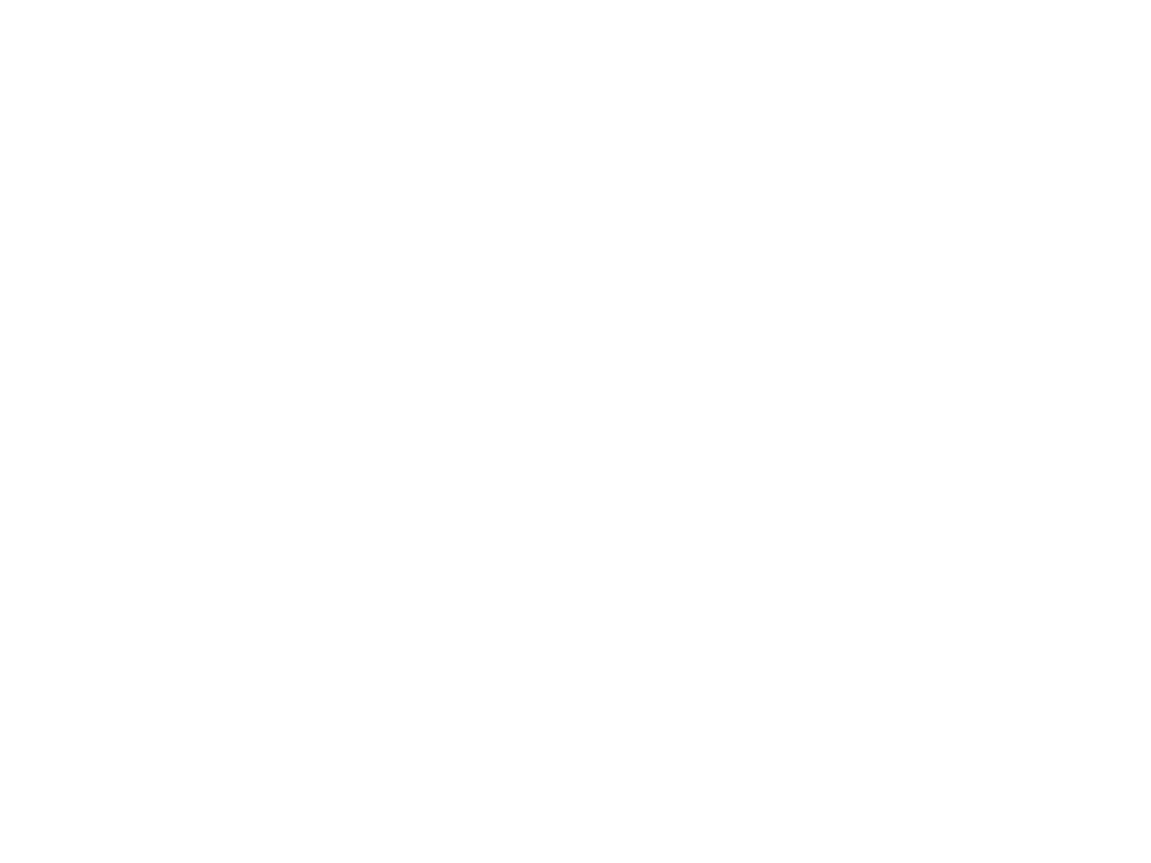

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


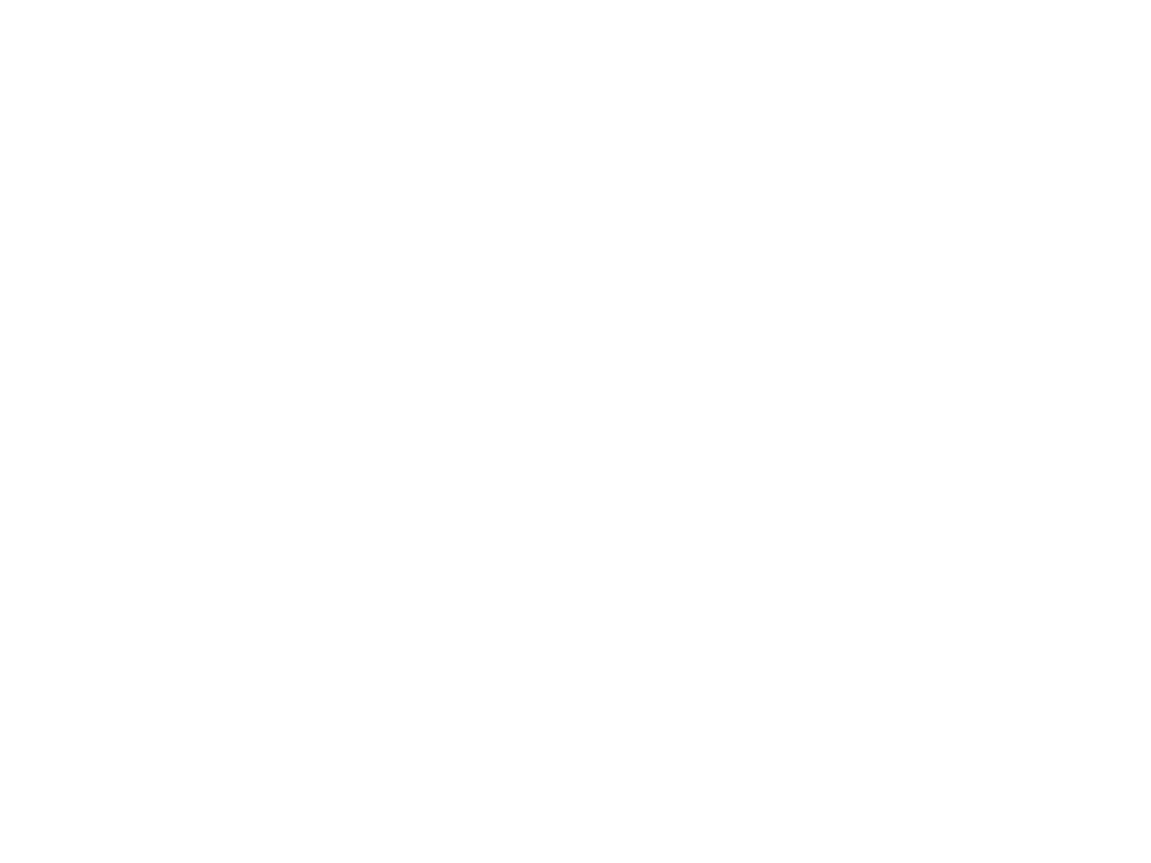

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


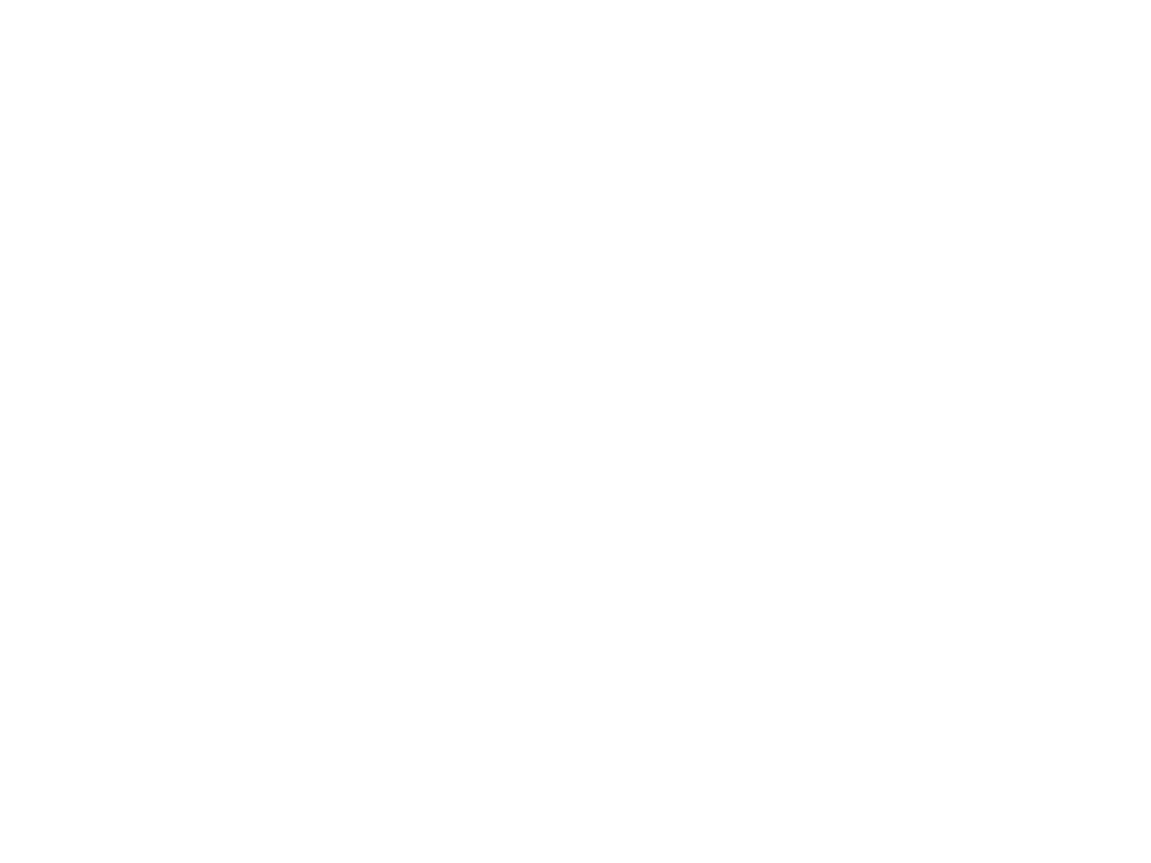

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


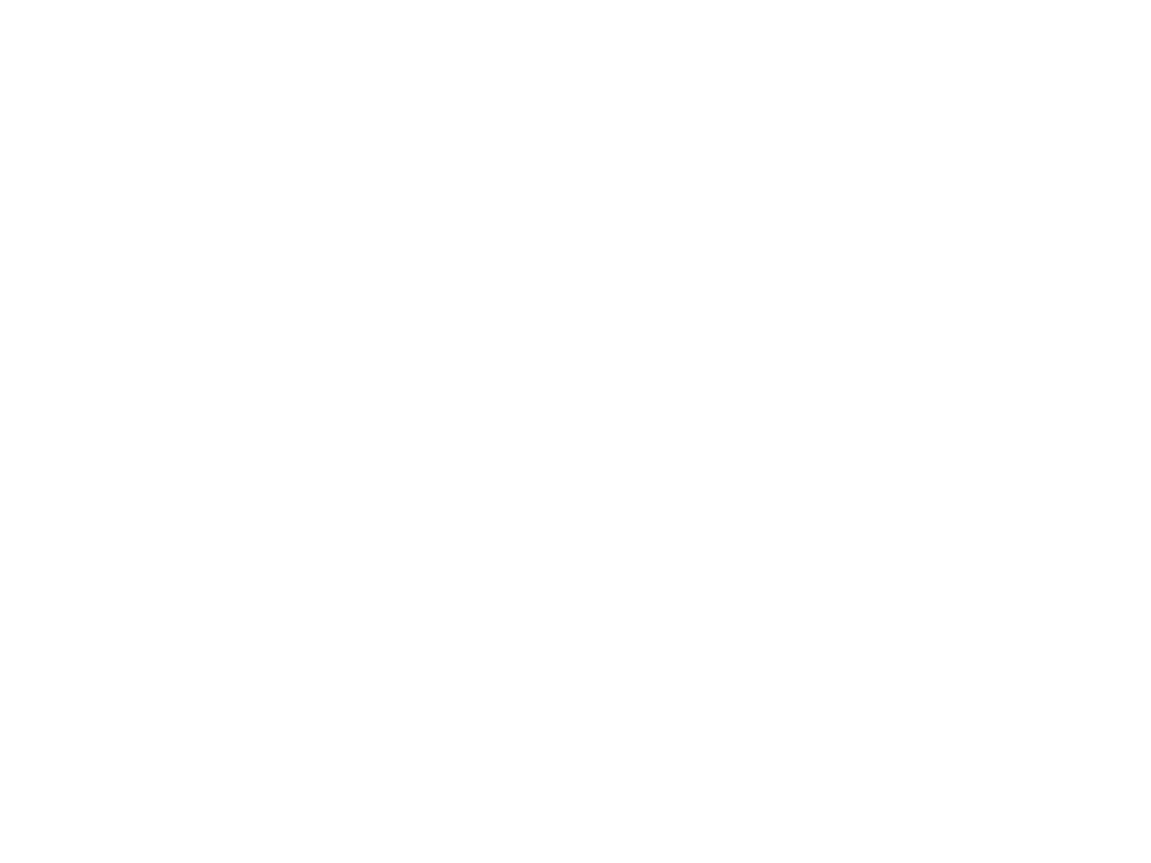

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


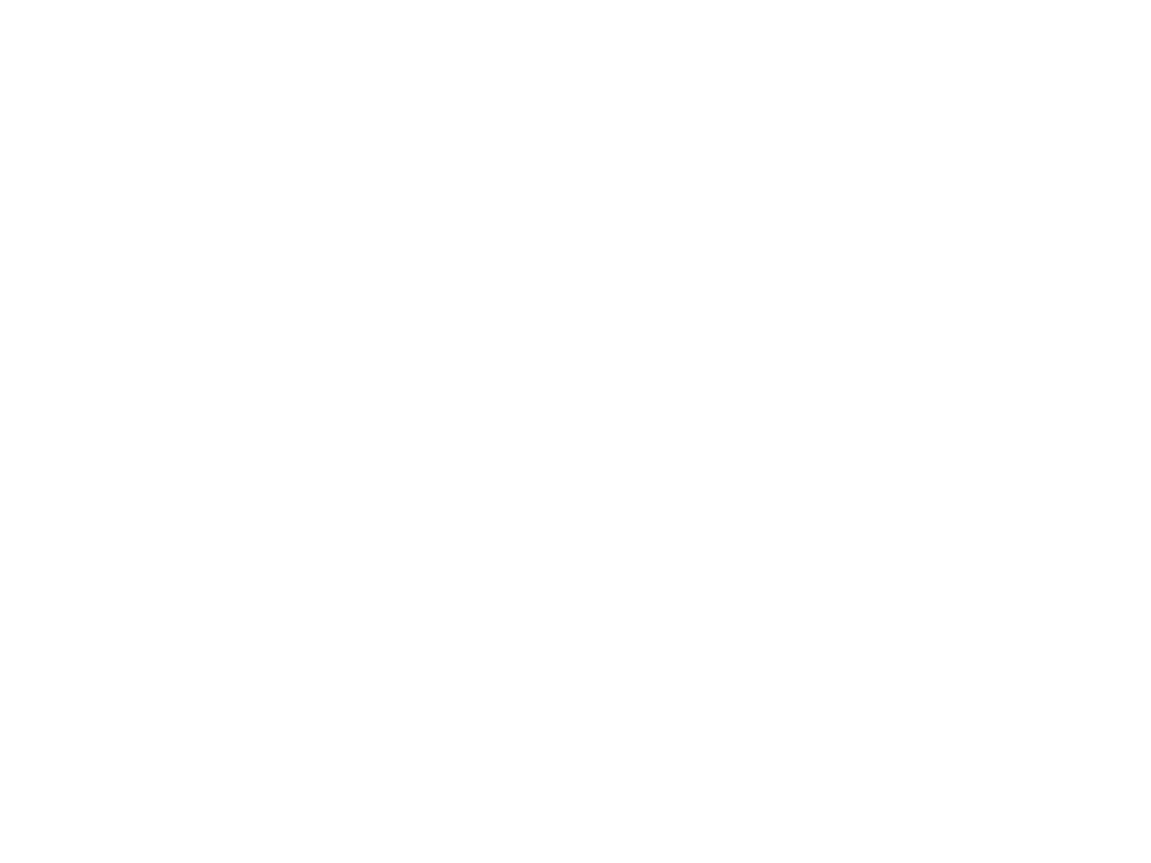

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
12000/22328   6.323     -364.7       0.9312      0.0006127     0.4448          2      
12100/22328   6.196     -334.3       0.9405      0.0006127     0.4434          2      
12200/22328   6.196     -341.6       0.9512      0.0006127     0.4434          2      
12300/22328   6.196     -323.4       0.8614      0.0006127      0.446          2      
12400/22328   6.073     -378.8       0.9453      0.0006127     0.4442          2      
12500/22328   6.073     -345.9       0.9478      0.0006127     0.4436          2      
12600/22328   5.951     -345.3       0.9338      0.0006127     0.4432          2      
12700/22328   5.951     -333.3       0.9465      0.000

<IPython.core.display.Javascript object>


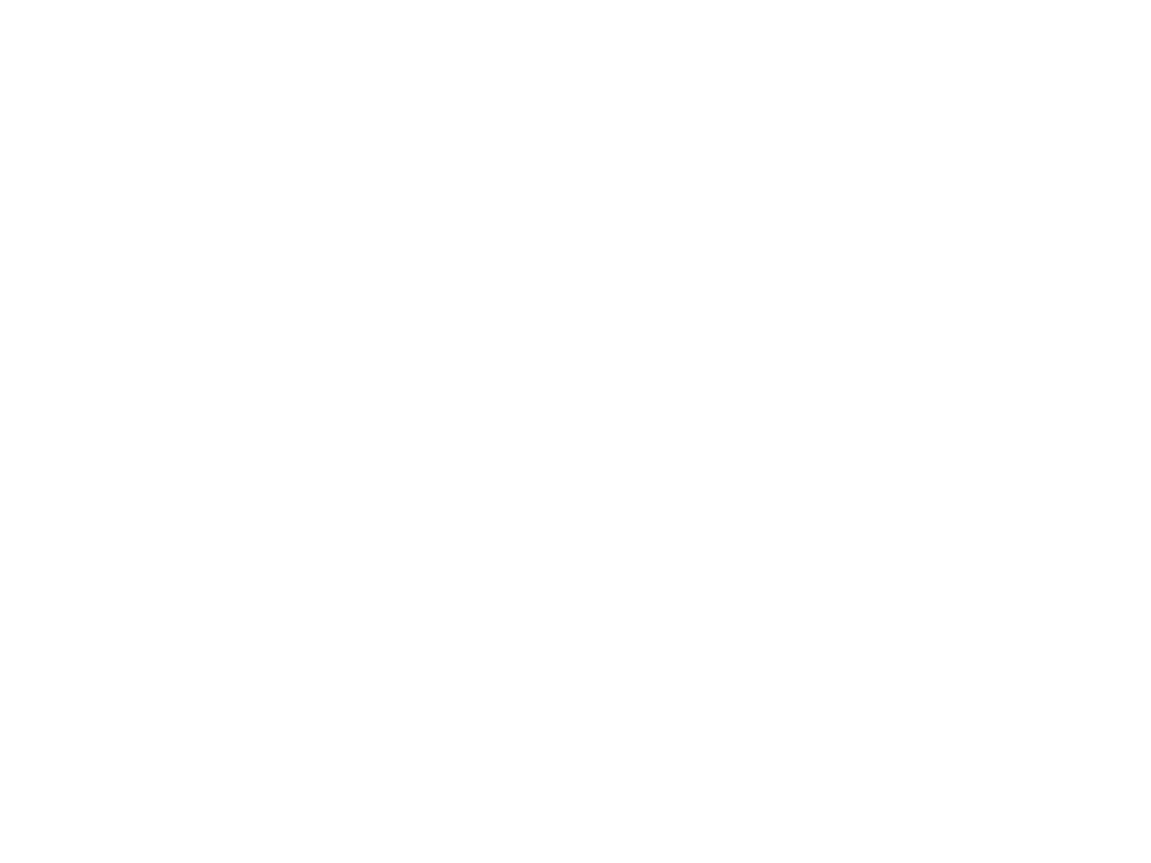

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


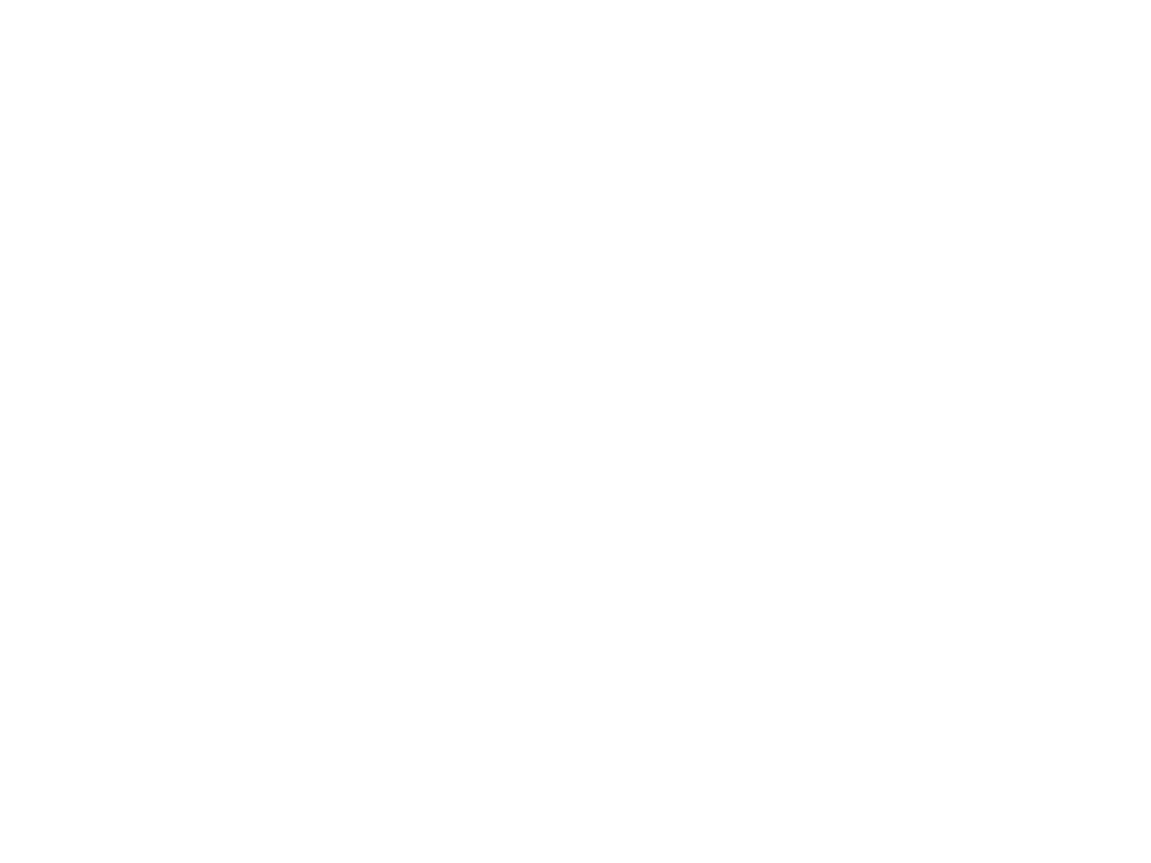

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


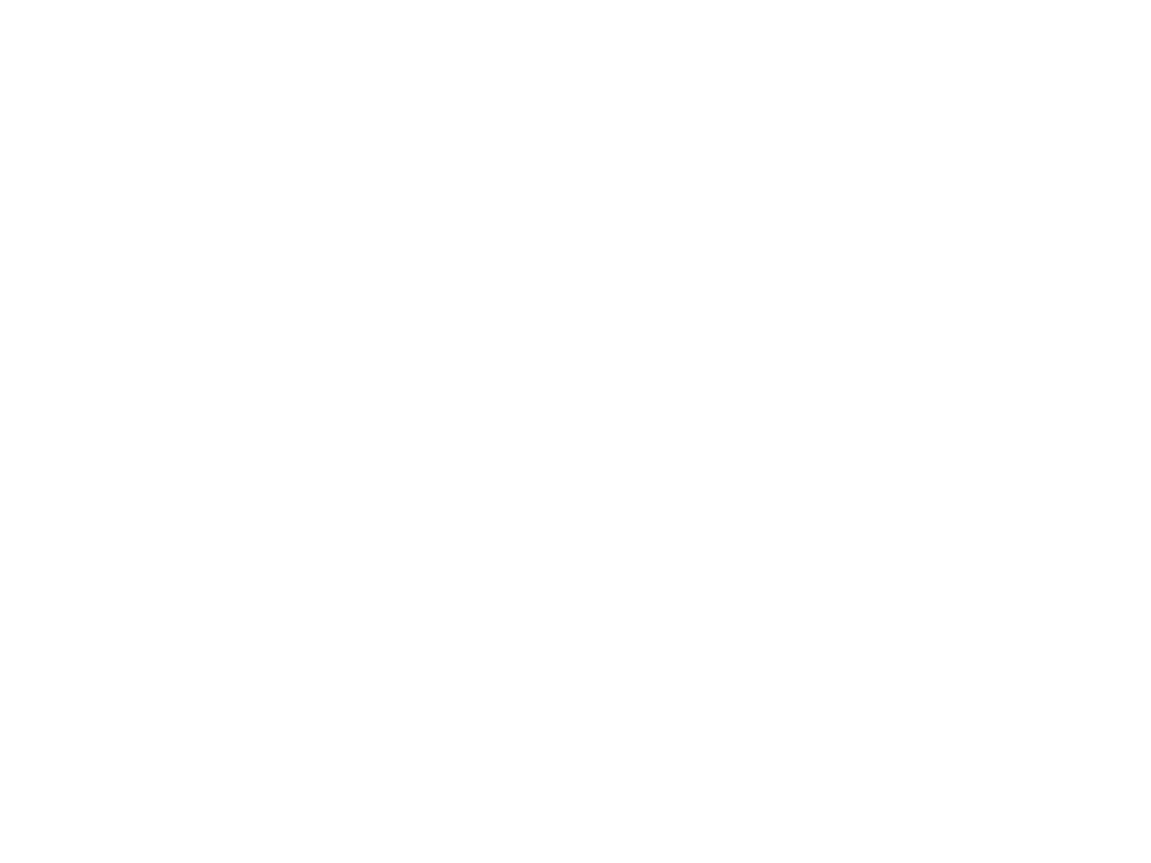

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


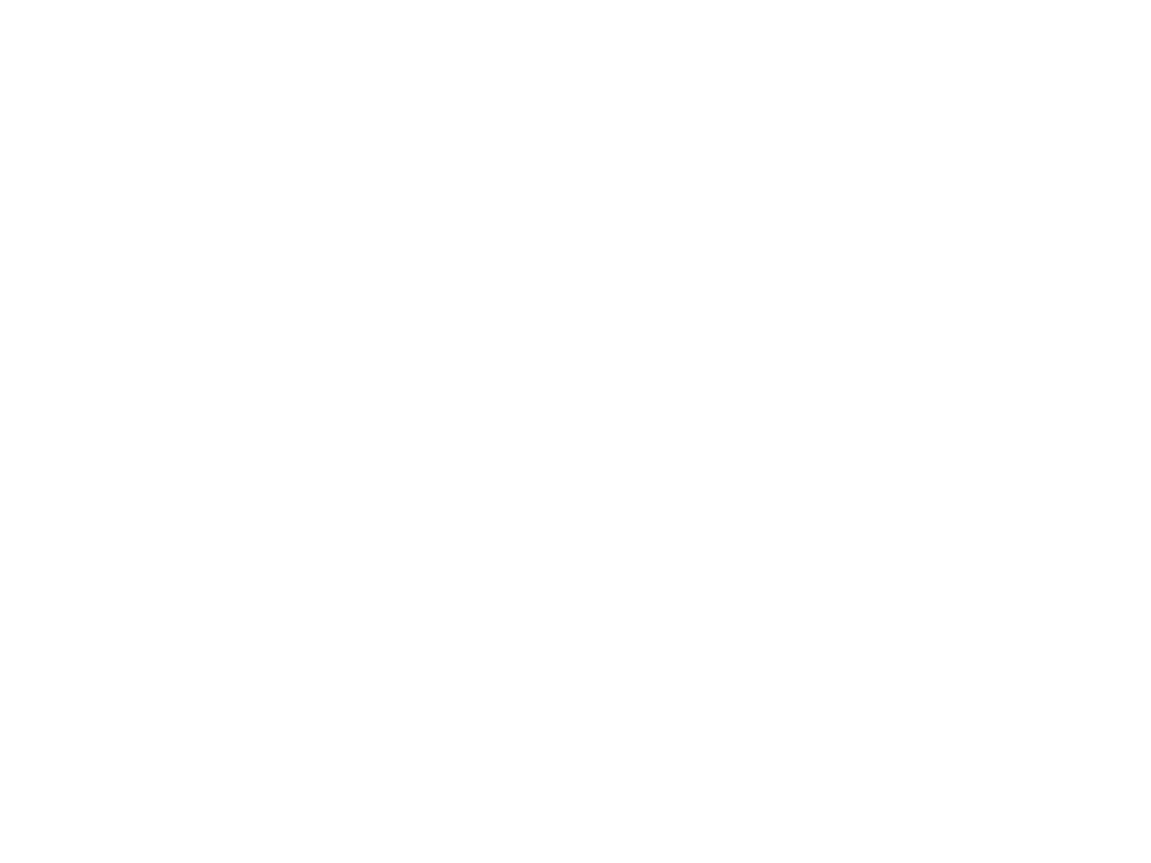

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


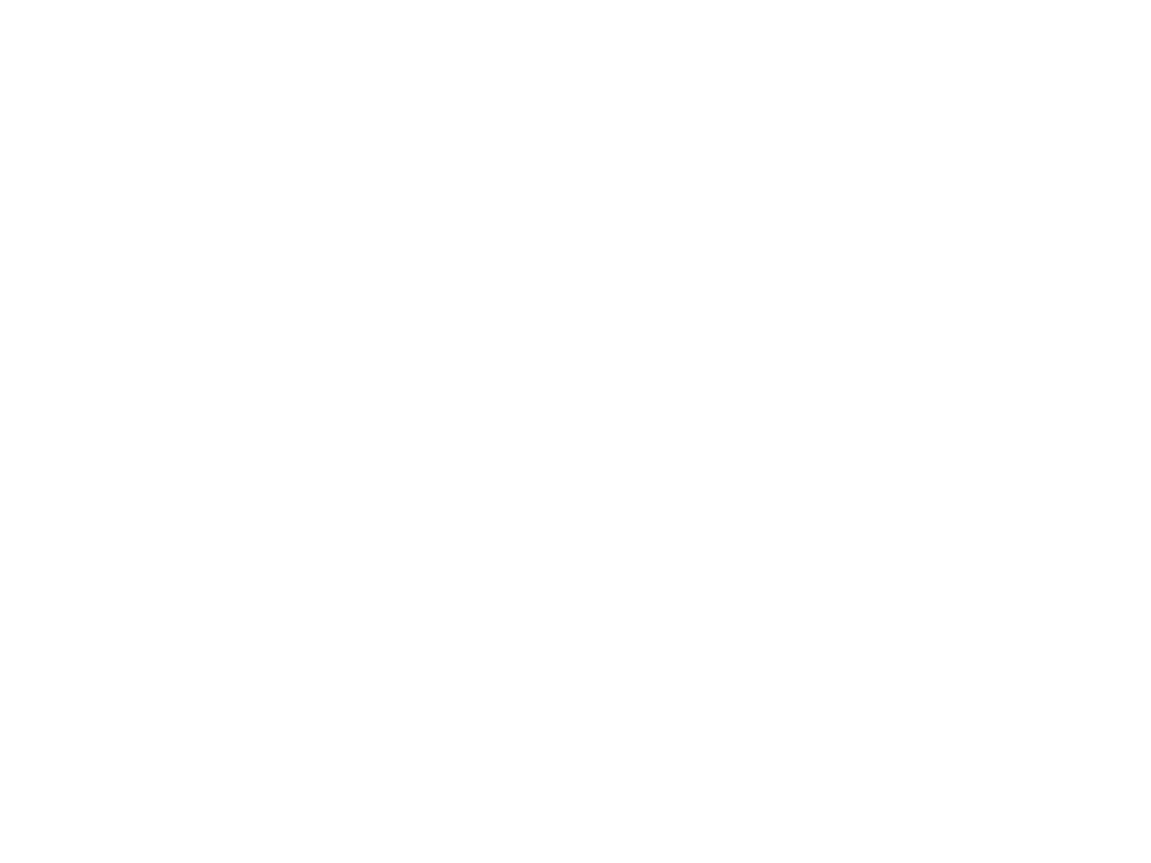

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf

Tunneling rate decreased.
Change in tunneling rate (temp = 1): 0.0032887174705732436
Change in tunneling rate (temp = 5.72): 0.0020855778234676325
Slowing down annealing schedule and resetting temperature.
Annealing steps: 220 --> 242
Temperature: 5.72 --> 5.72

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
13000/22328   5.715     -357.1       0.9379      0.0005882     0.4425          2      
13100/22328   5.601     -350.2       0.9522      0.0005882     0.4425          2      
13200/22328   5.601     -395.8       0.9536      0.0005882     0.4424          2      
13300/22328   5.601     -352.3       0.9081      0.0005882     0.4423          2      
13400/22328   5.489     -366.5       0.9604      0.

<IPython.core.display.Javascript object>


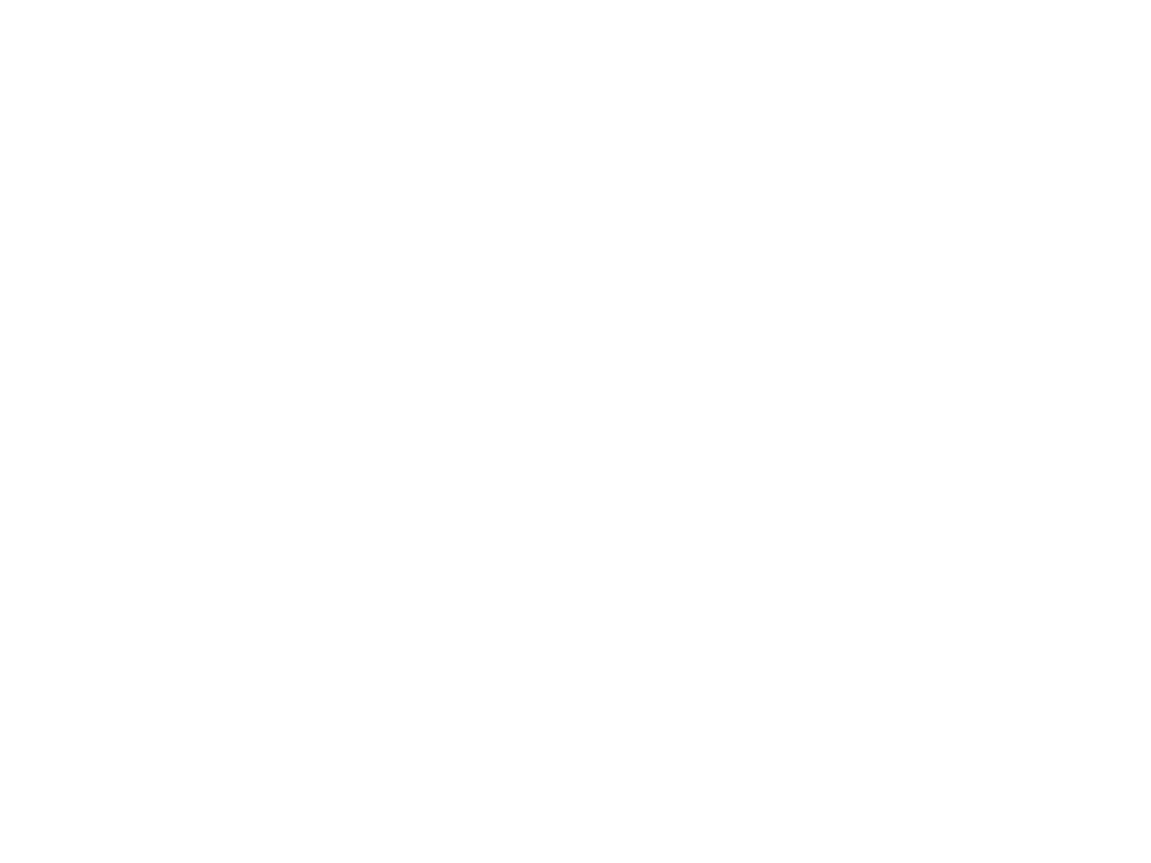

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


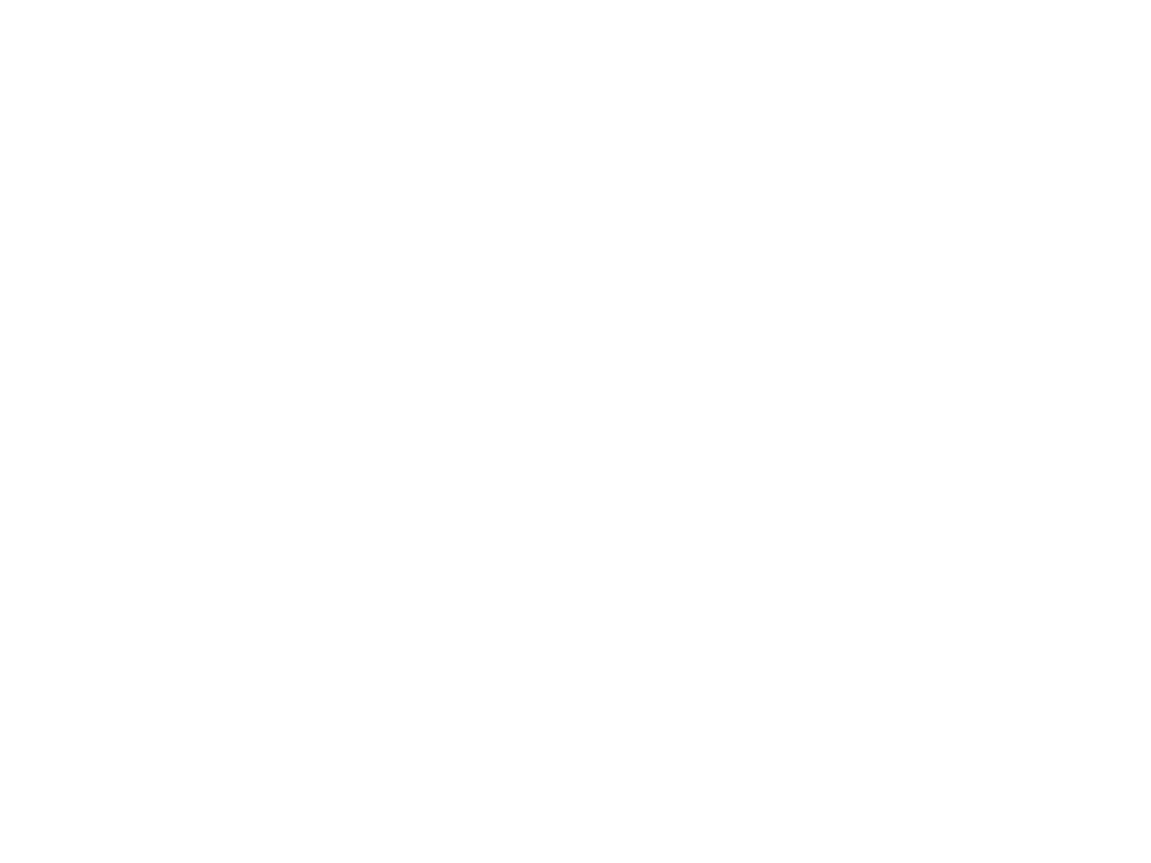

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


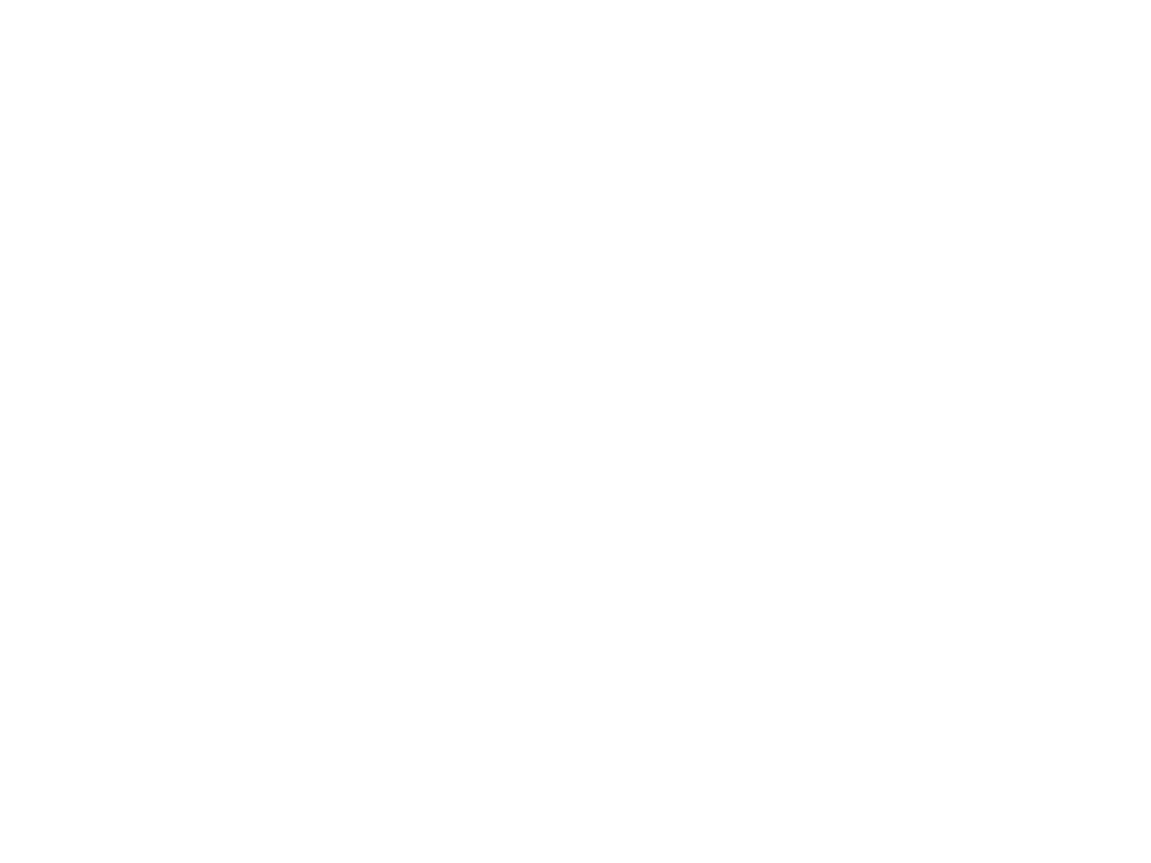

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


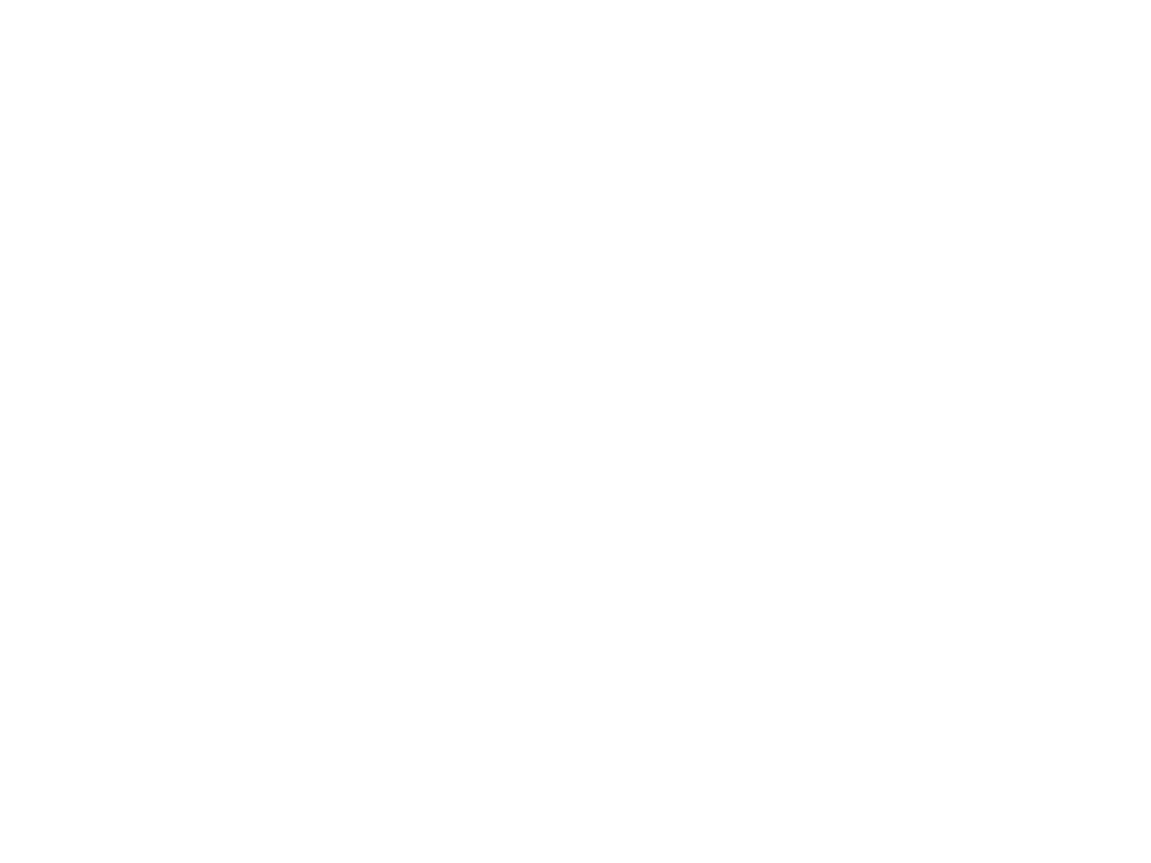

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


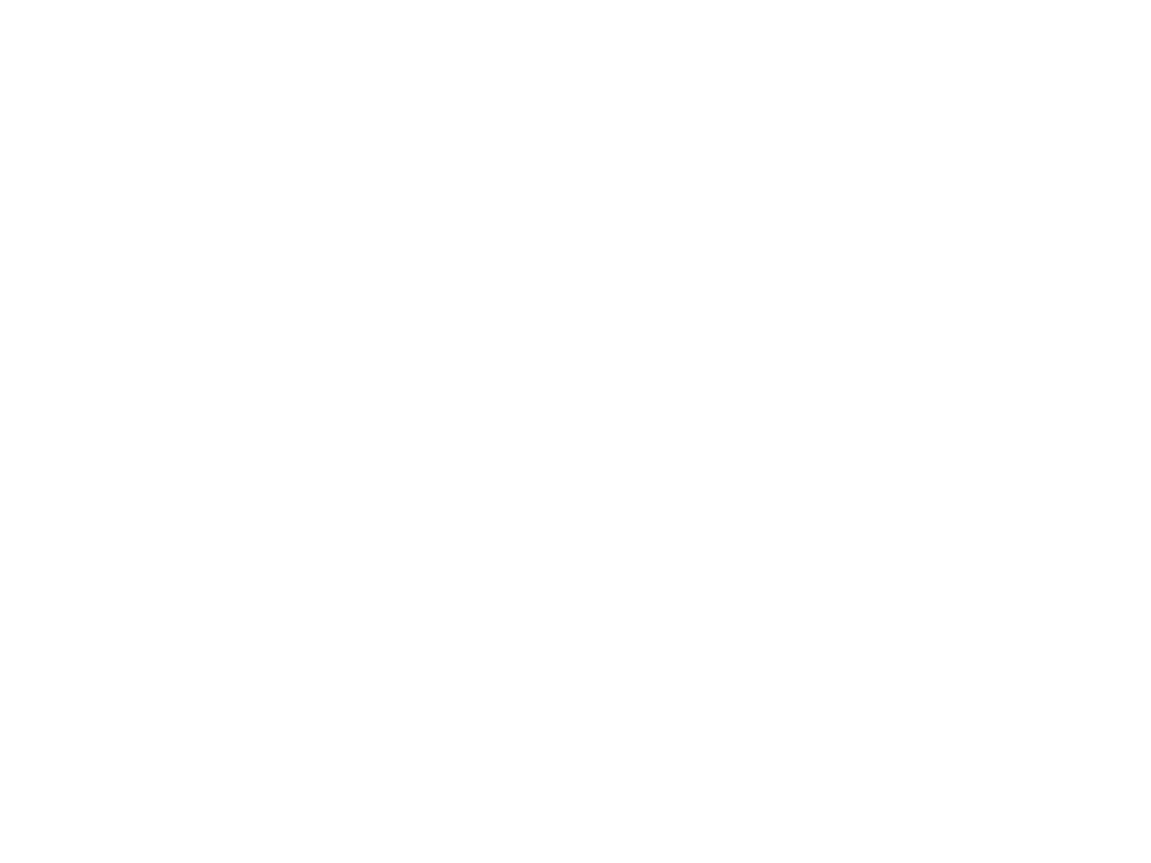

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
14000/22328   5.272     -339.1        0.944      0.0005647     0.4397          2      
14100/22328   5.166     -363.8       0.9251      0.0005647     0.4398          2      
14200/22328   5.166     -353.7       0.9571      0.0005647     0.4392          2      
14300/22328   5.063     -353.5       0.9563      0.0005647      0.439          2      
14400/22328   5.063     -368.1       0.8615      0.0005647     0.4403          2      
14500/22328   5.063     -342.4       0.9308      0.0005647     0.4392          2      
14600/22328   4.962     -347.6       0.9458      0.0005647     0.4385          2      
14700/22328   4.962      -375        0.9483      0.000

<IPython.core.display.Javascript object>


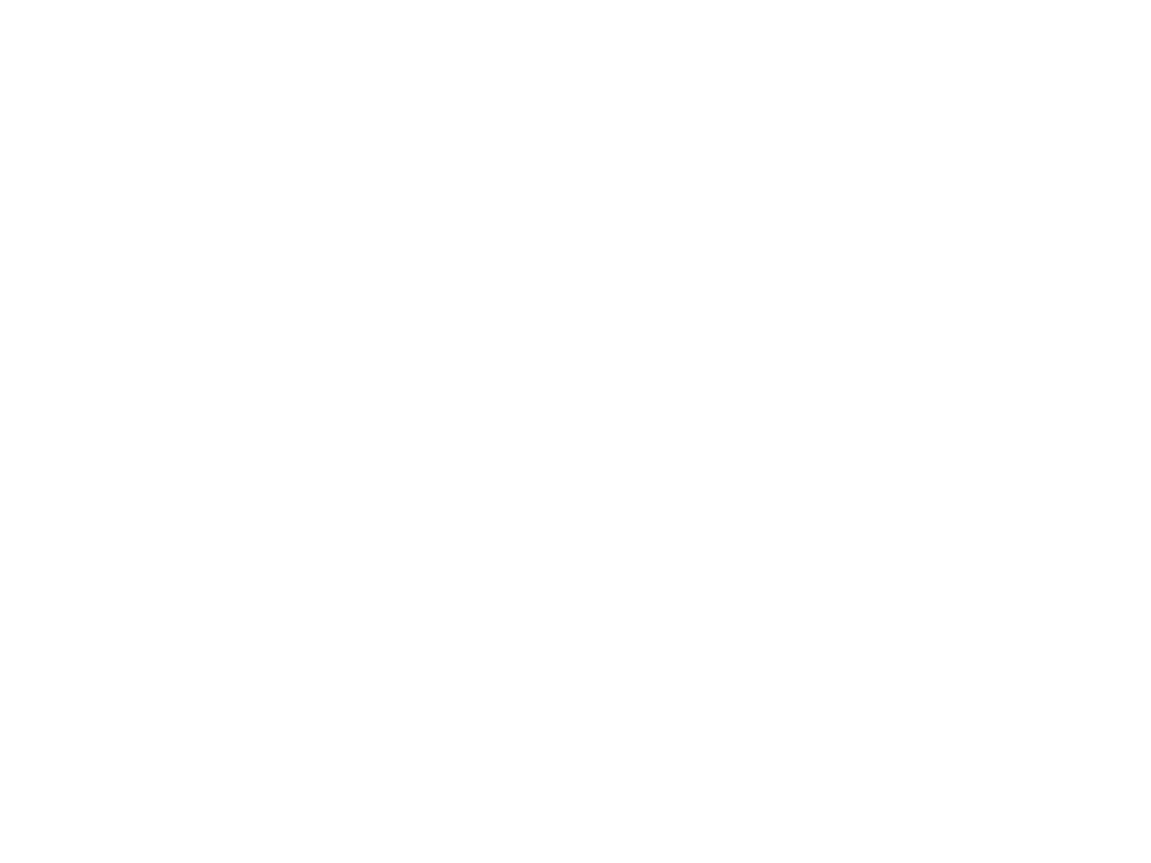

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


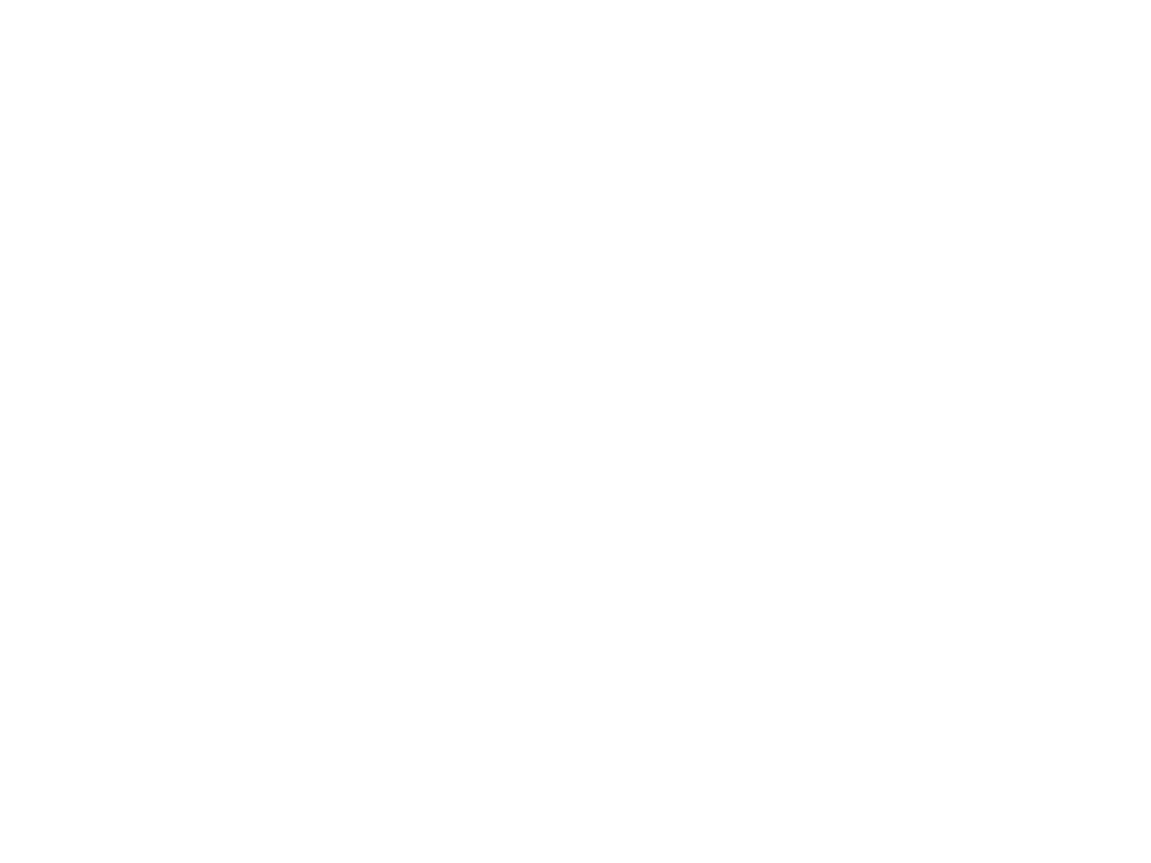

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


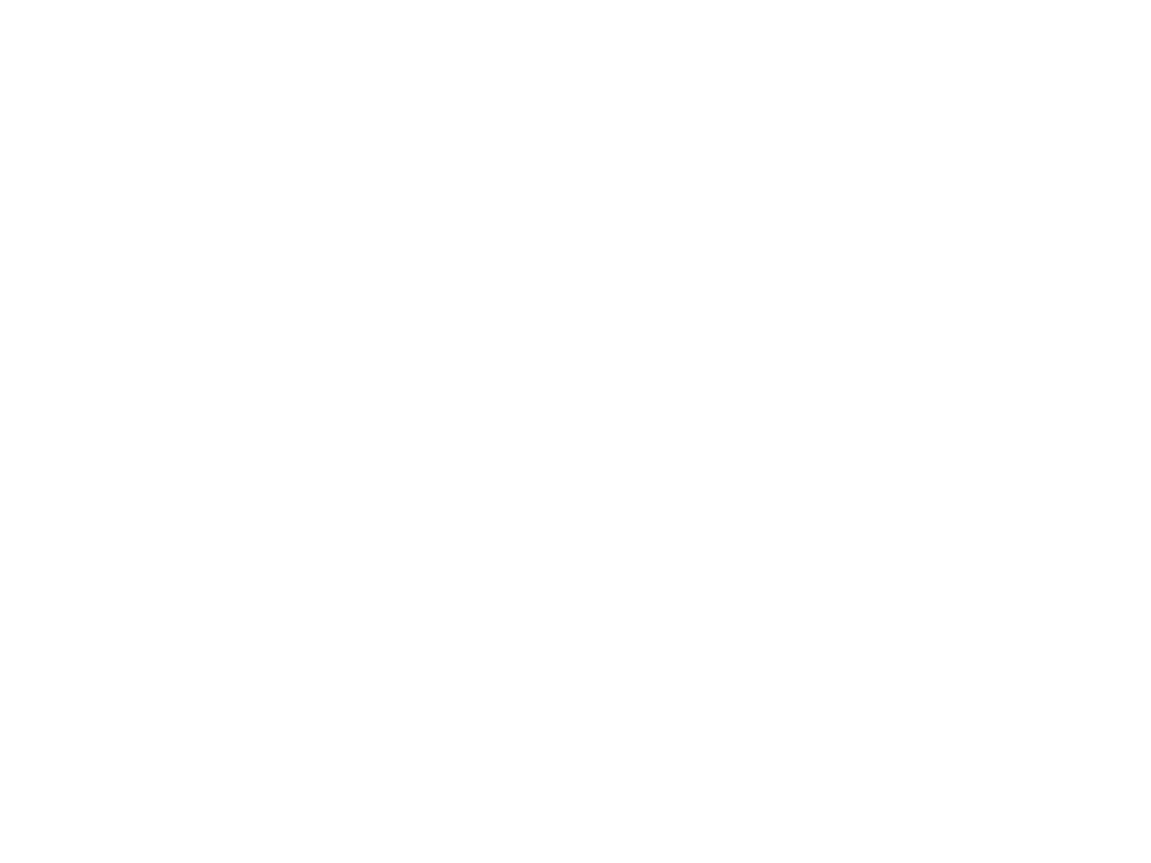

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


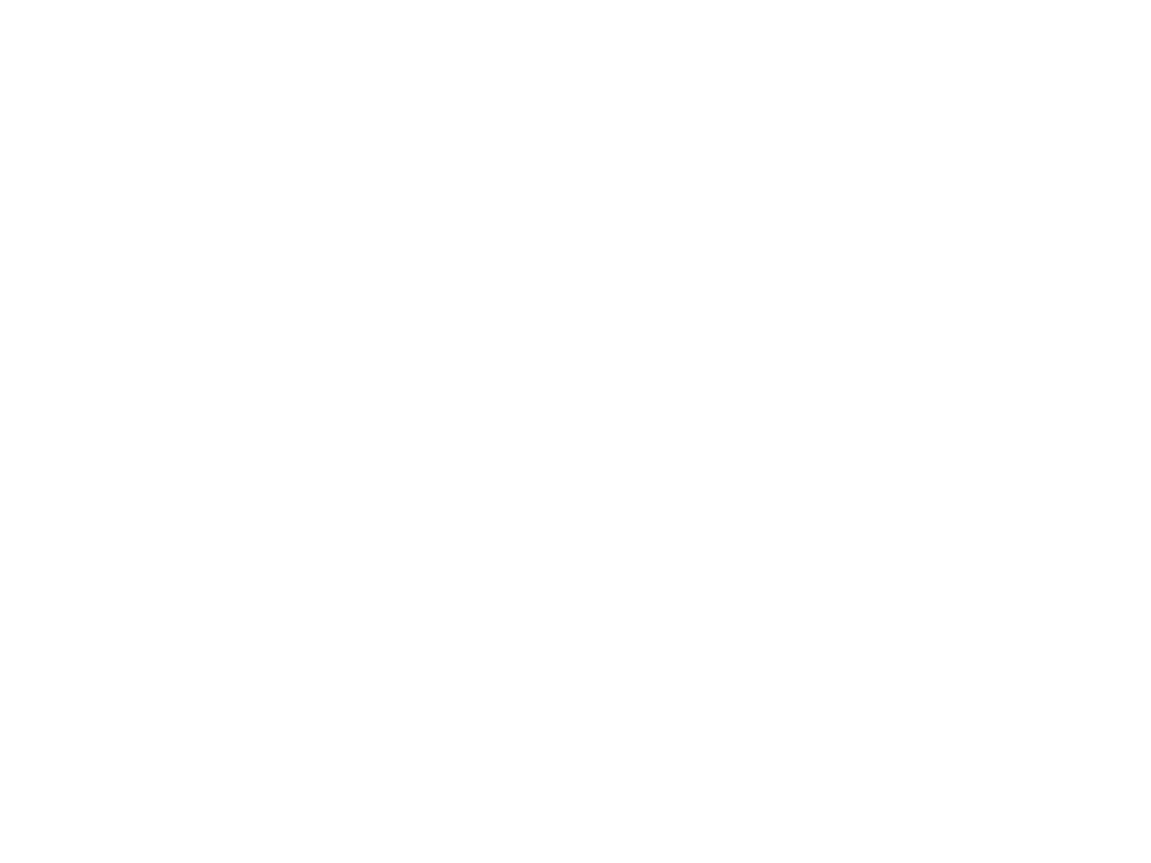

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


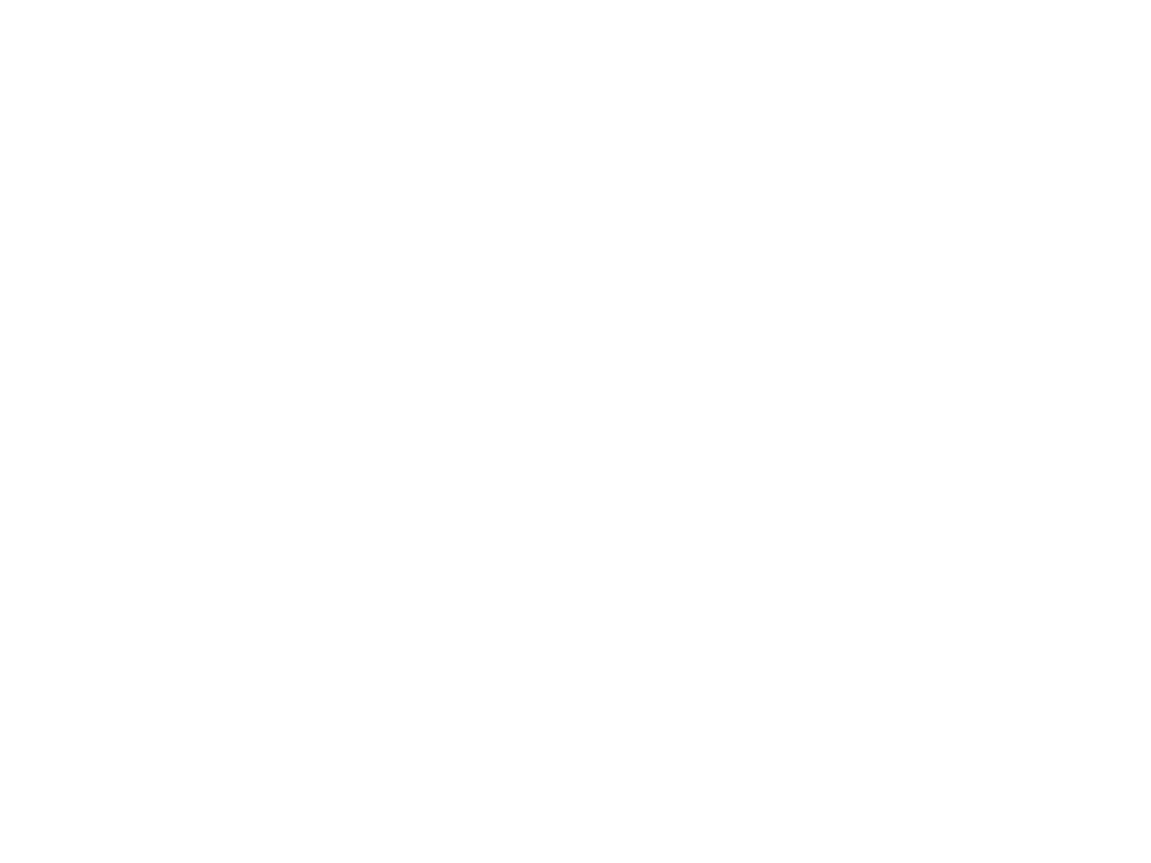

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf

Tunneling rate decreased.
Change in tunneling rate (temp = 1): -0.01189179606097751
Change in tunneling rate (temp = 4.86): 0.02663060863751454
Slowing down annealing schedule and resetting temperature.
Annealing steps: 242 --> 266
Temperature: 4.86 --> 4.86

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
15000/22328   4.862     -356.1        0.91       0.0005421     0.4393          2      
15100/22328   4.862     -350.2       0.9591      0.0005421     0.4381          2      
15200/22328   4.765     -362.2       0.9427      0.0005421     0.4378          2      
15300/22328   4.765     -363.2        0.928      0.0005421     0.4379          2      
15400/22328   4.765     -356.1       0.9447      0.000

<IPython.core.display.Javascript object>


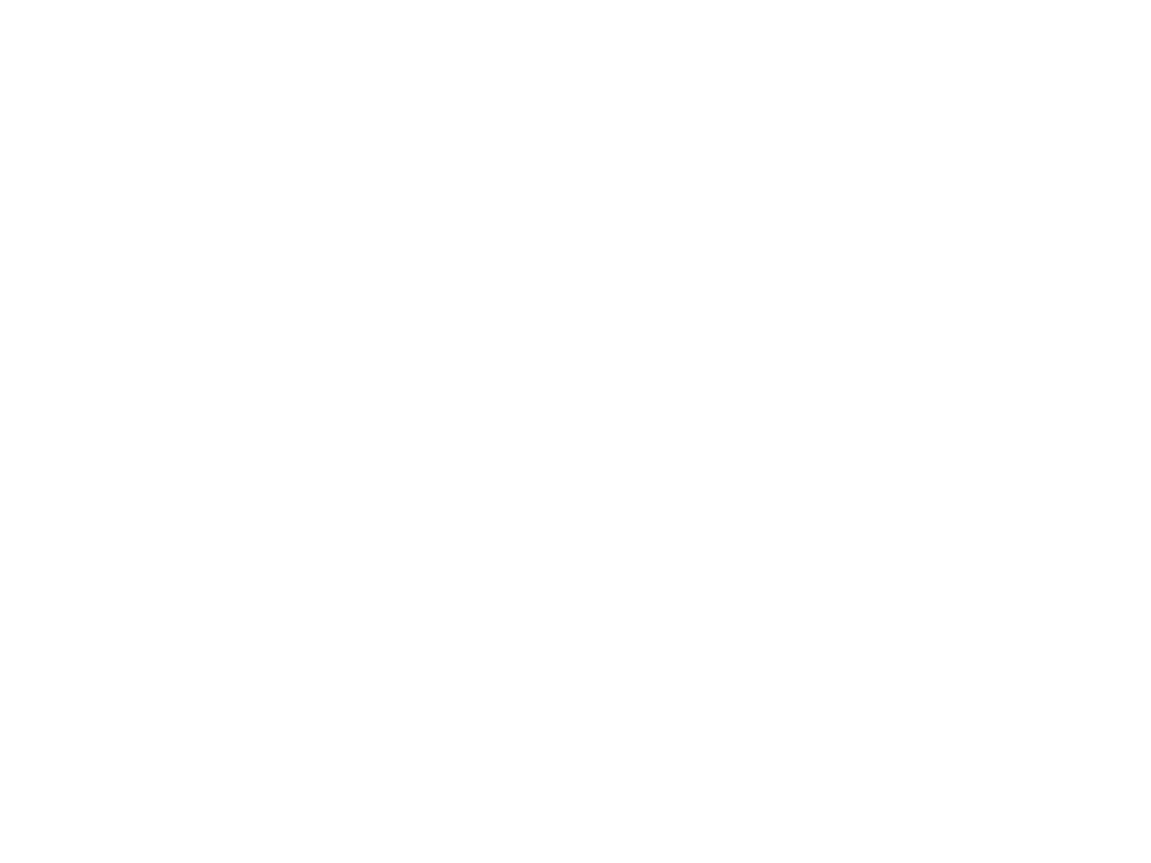

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


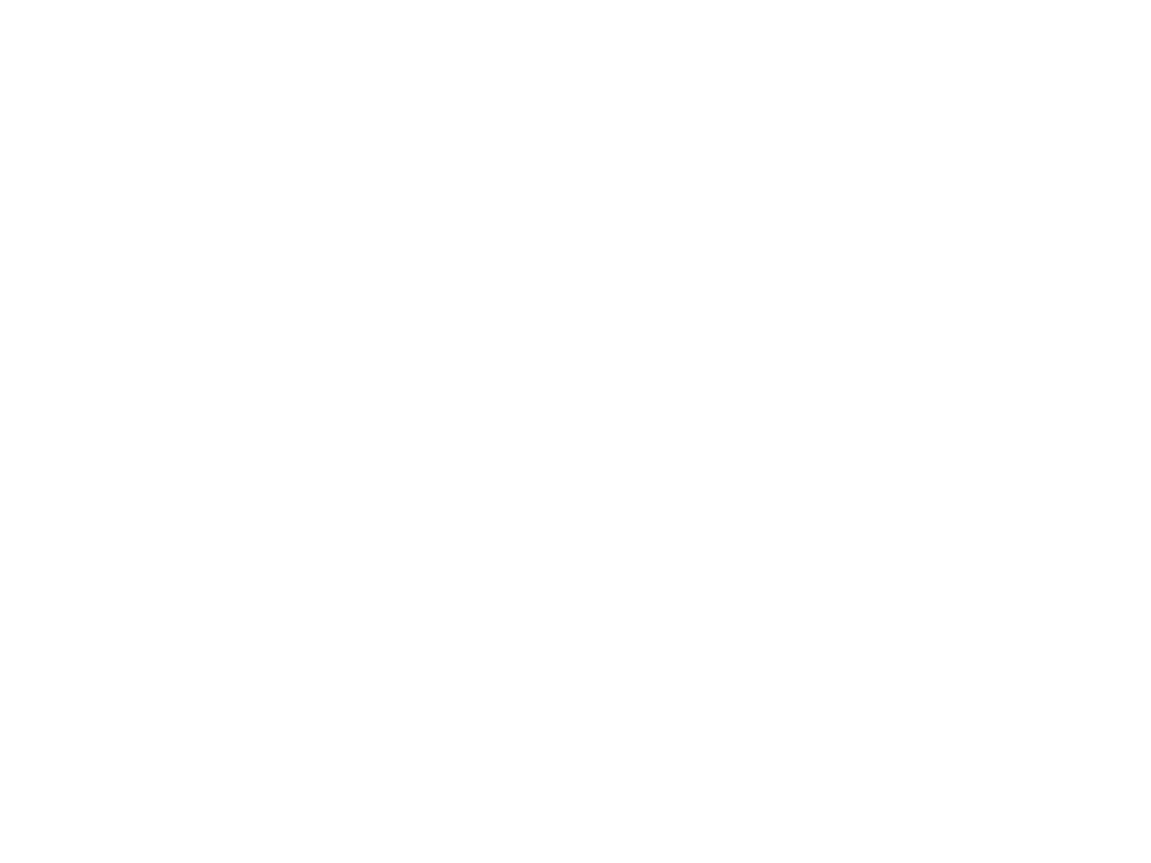

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


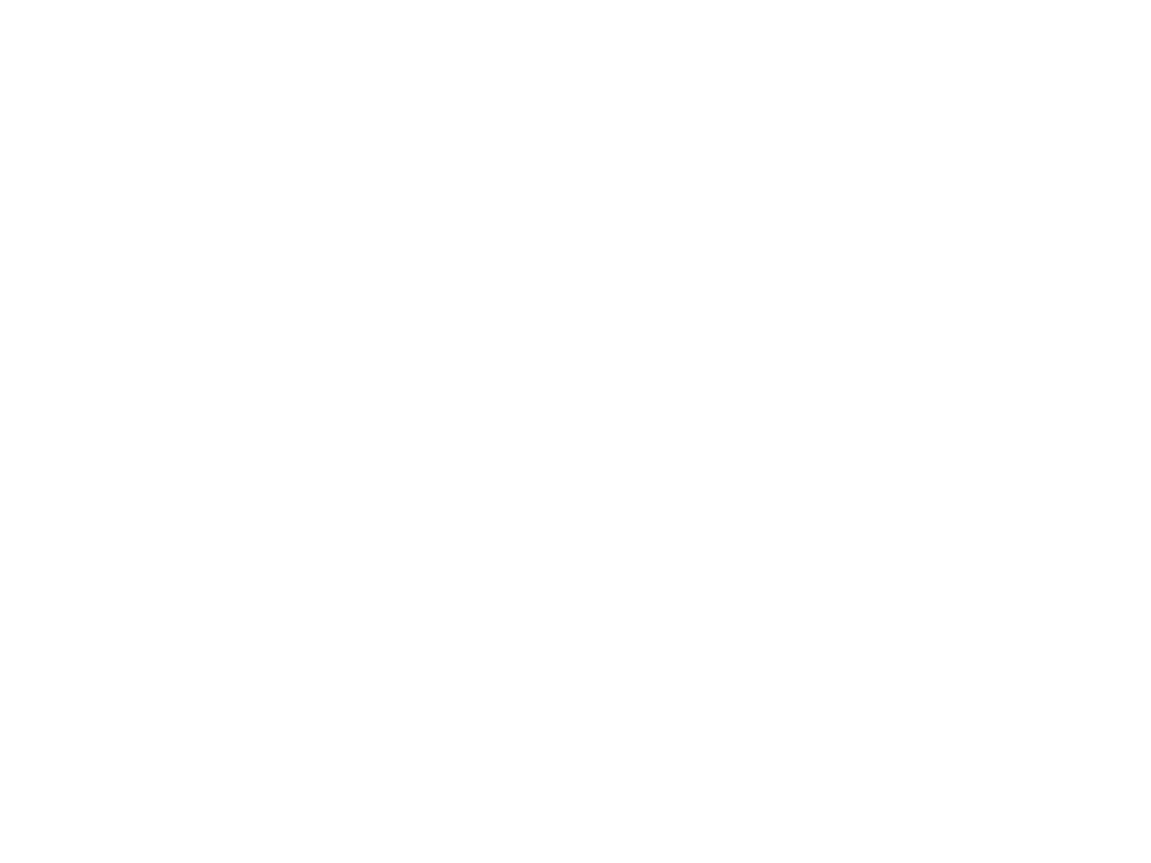

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


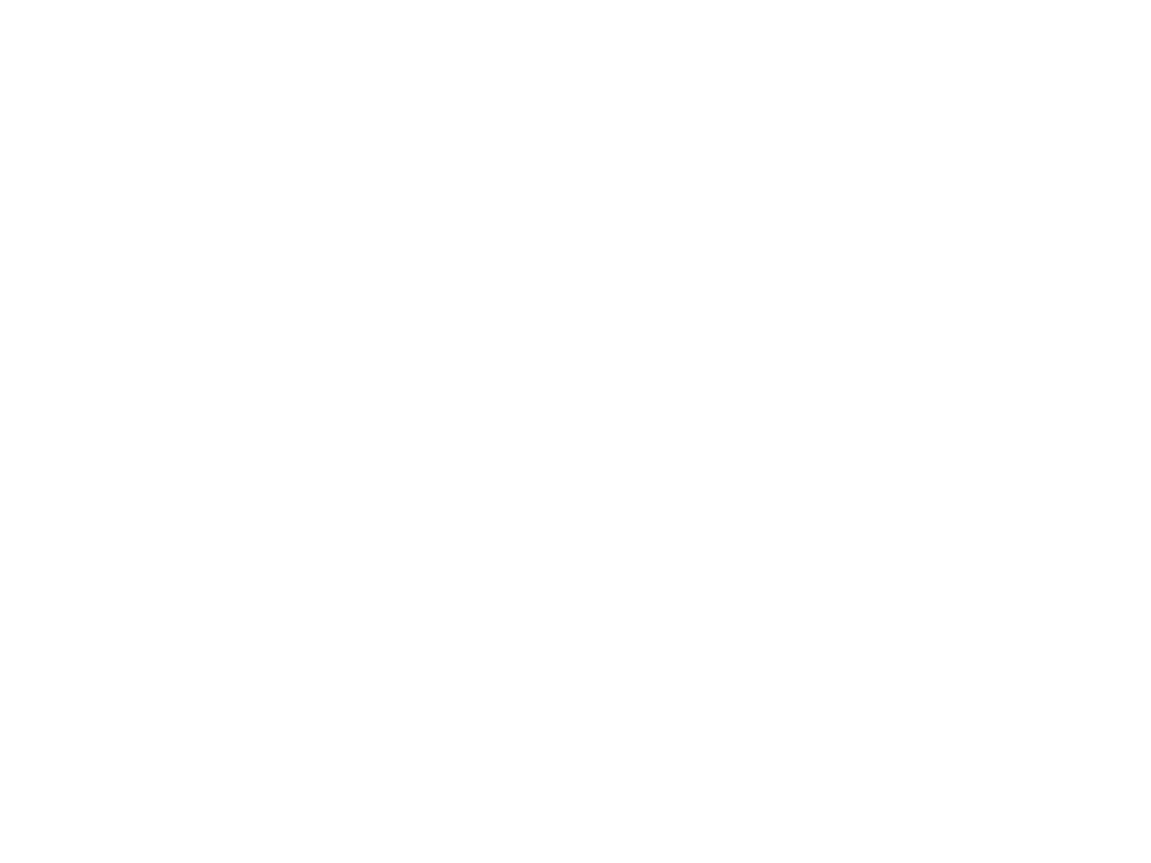

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


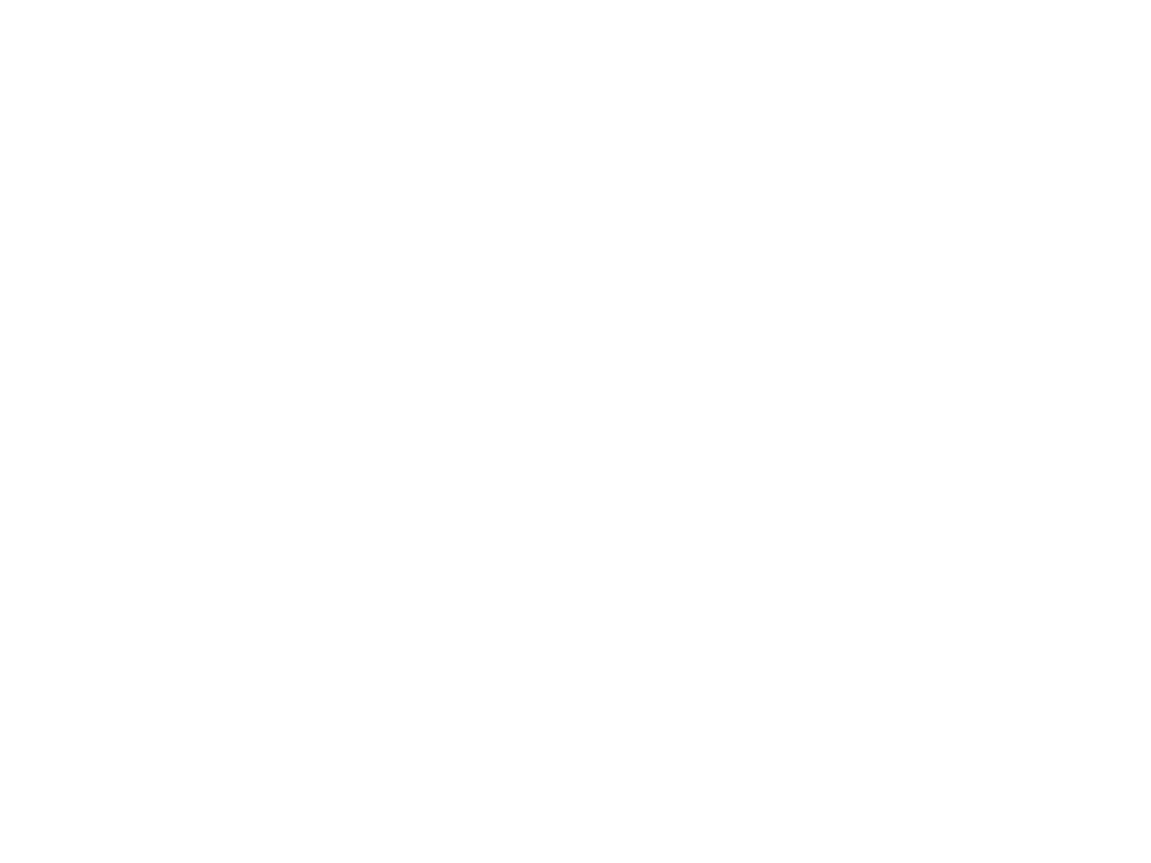

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
16000/22328   4.485     -331.8       0.9322      0.0005204     0.4362          2      
16100/22328   4.485     -360.7       0.9379      0.0005204     0.4361          2      
16200/22328   4.485     -339.1        0.939      0.0005204     0.4357          2      
16300/22328   4.395     -337.3       0.9352      0.0005204     0.4359          2      
16400/22328   4.395      -354        0.9296      0.0005204     0.4357          2      
16500/22328   4.307     -321.4       0.9452      0.0005204     0.4342          2      
16600/22328   4.307     -347.1       0.9284      0.0005204      0.434          2      
16700/22328   4.307     -350.3       0.9262      0.000

<IPython.core.display.Javascript object>


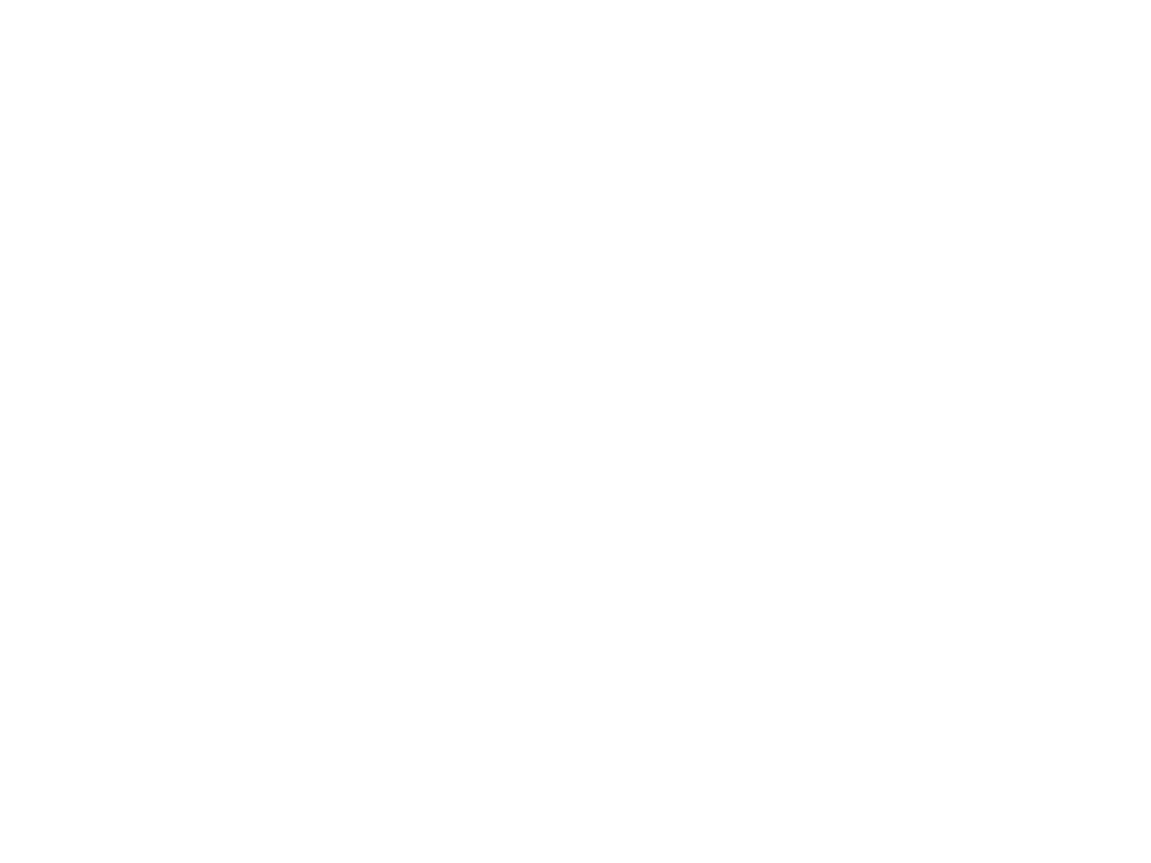

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


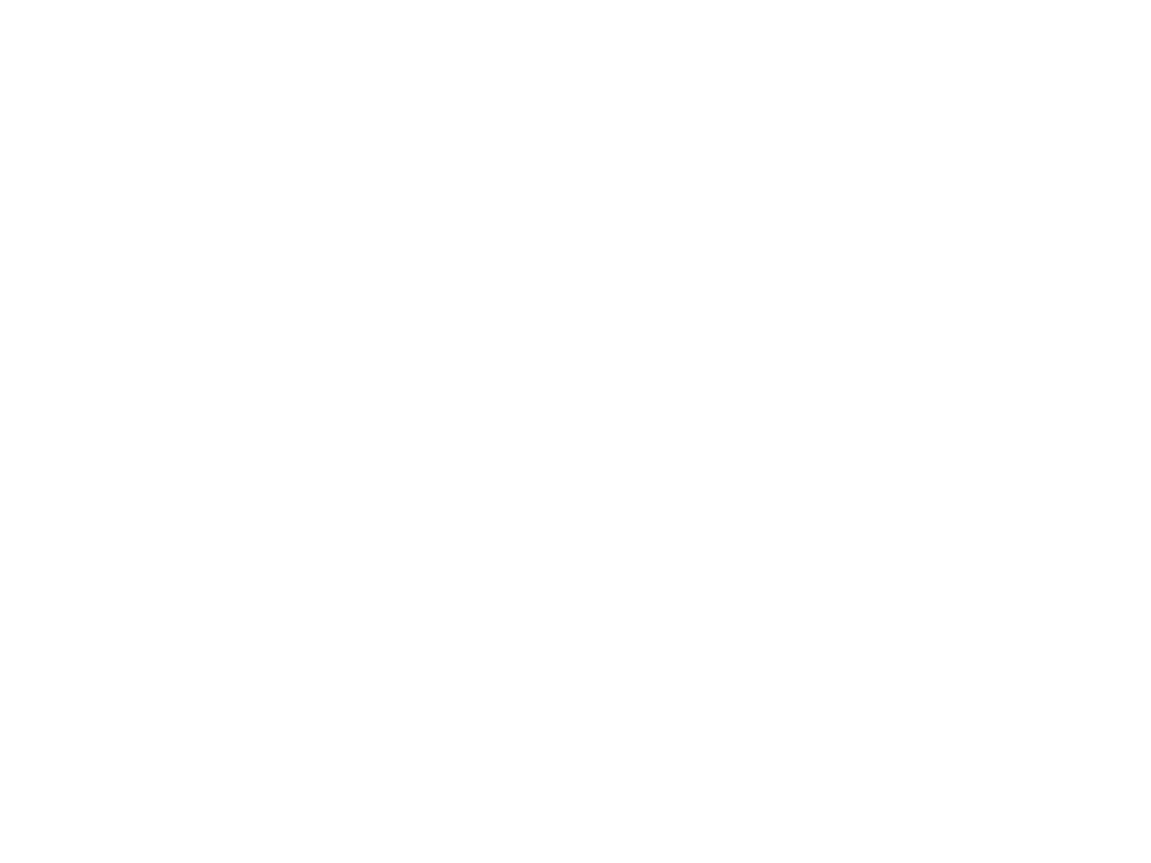

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


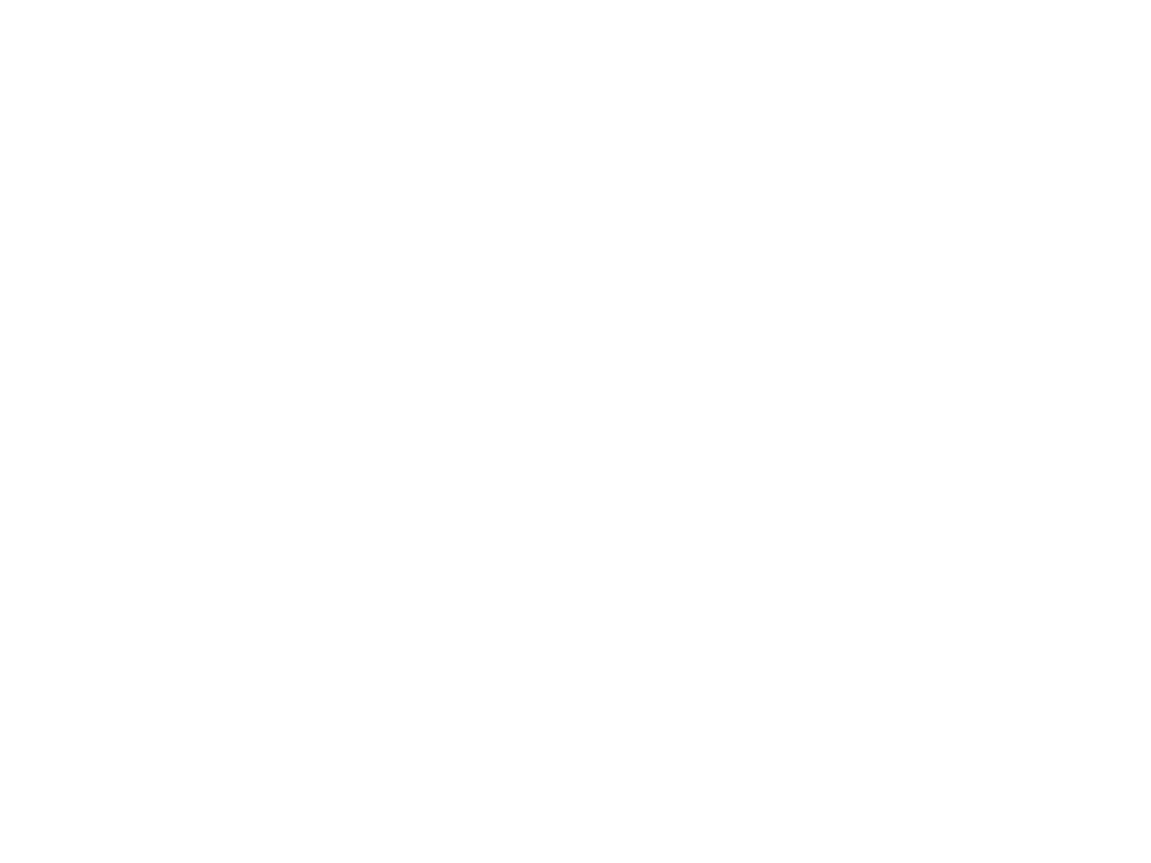

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


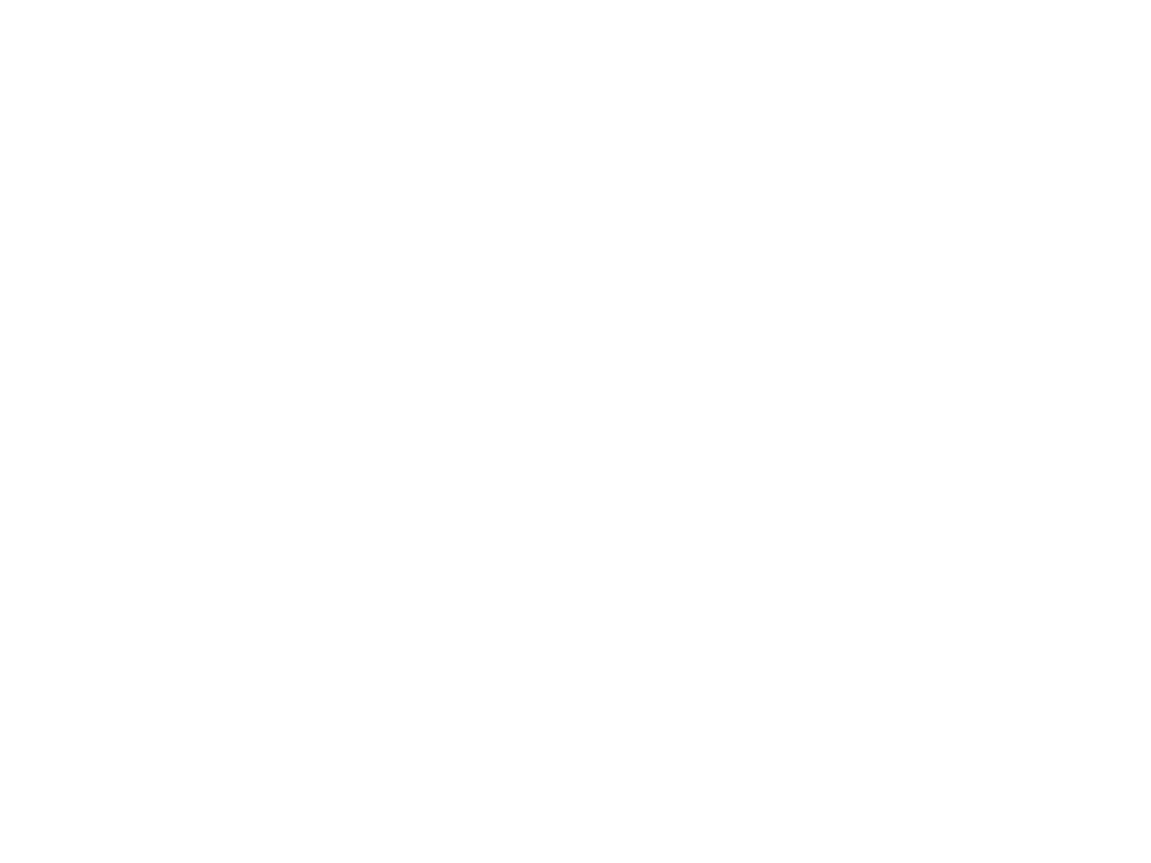

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


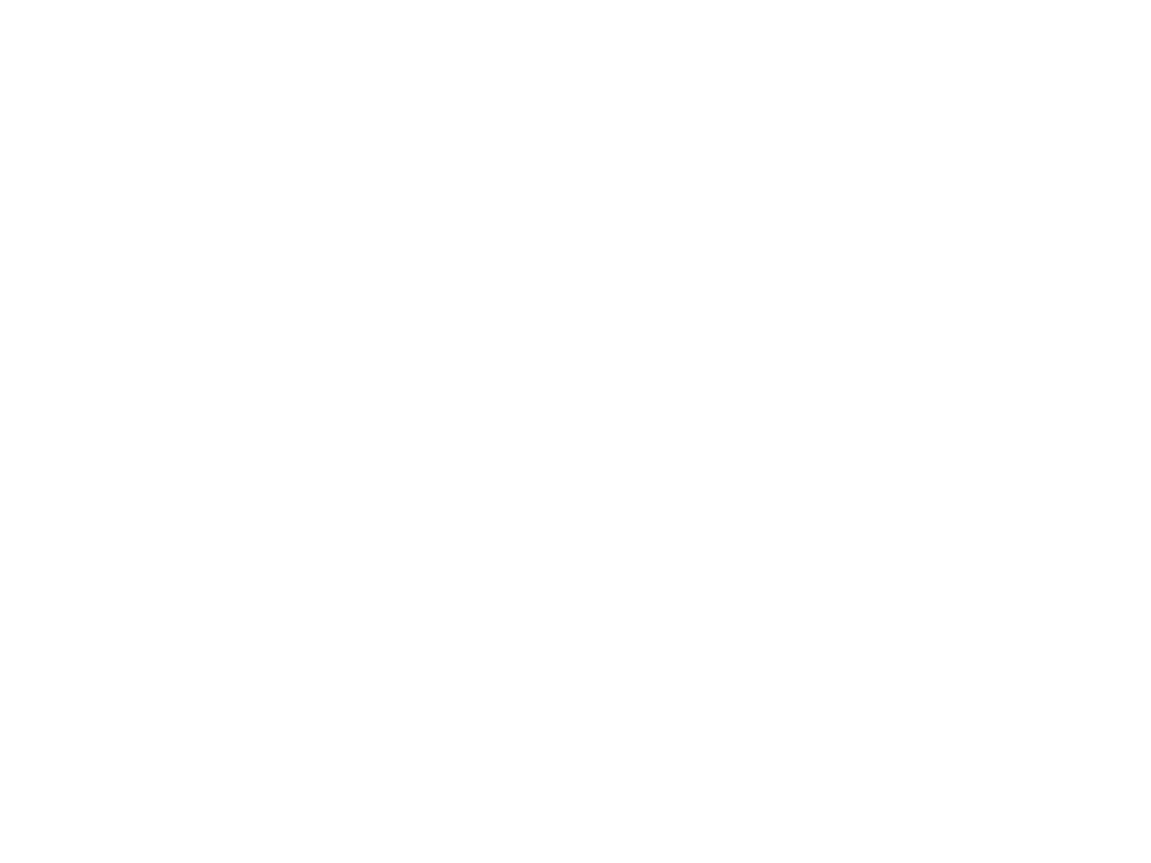

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
17000/22328   4.221     -375.1       0.9438      0.0004996     0.4335          2      
17100/22328   4.137     -393.7       0.9483      0.0004996     0.4337          2      
17200/22328   4.137     -343.8       0.9255      0.0004996     0.4336          2      
17300/22328   4.054     -350.1       0.9421      0.0004996     0.4327          2      
17400/22328   4.054     -356.5       0.9316      0.0004996      0.433          2      
17500/22328   4.054     -318.9       0.9271      0.0004996     0.4337          2      
17600/22328   3.973     -325.1       0.8699      0.0004996     0.4313          2      
17700/22328   3.973      -368        0.9427      0.000

<IPython.core.display.Javascript object>


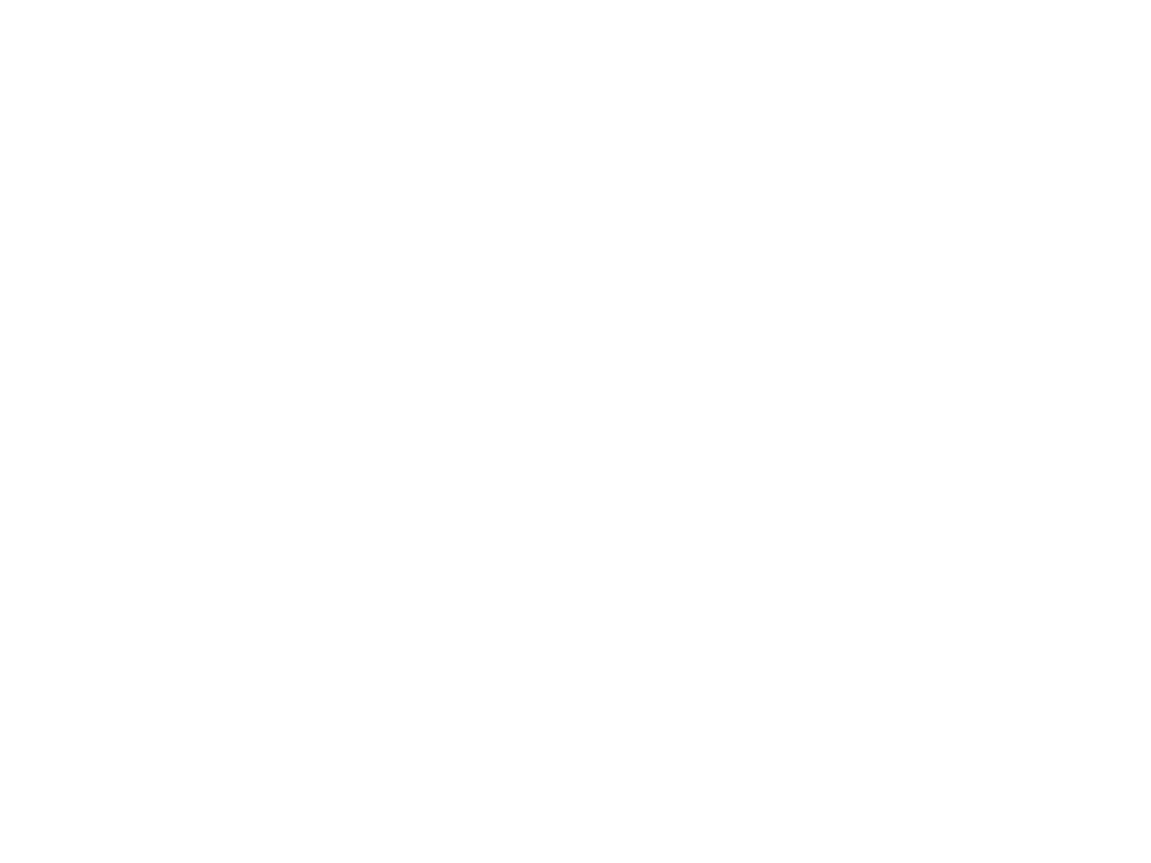

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


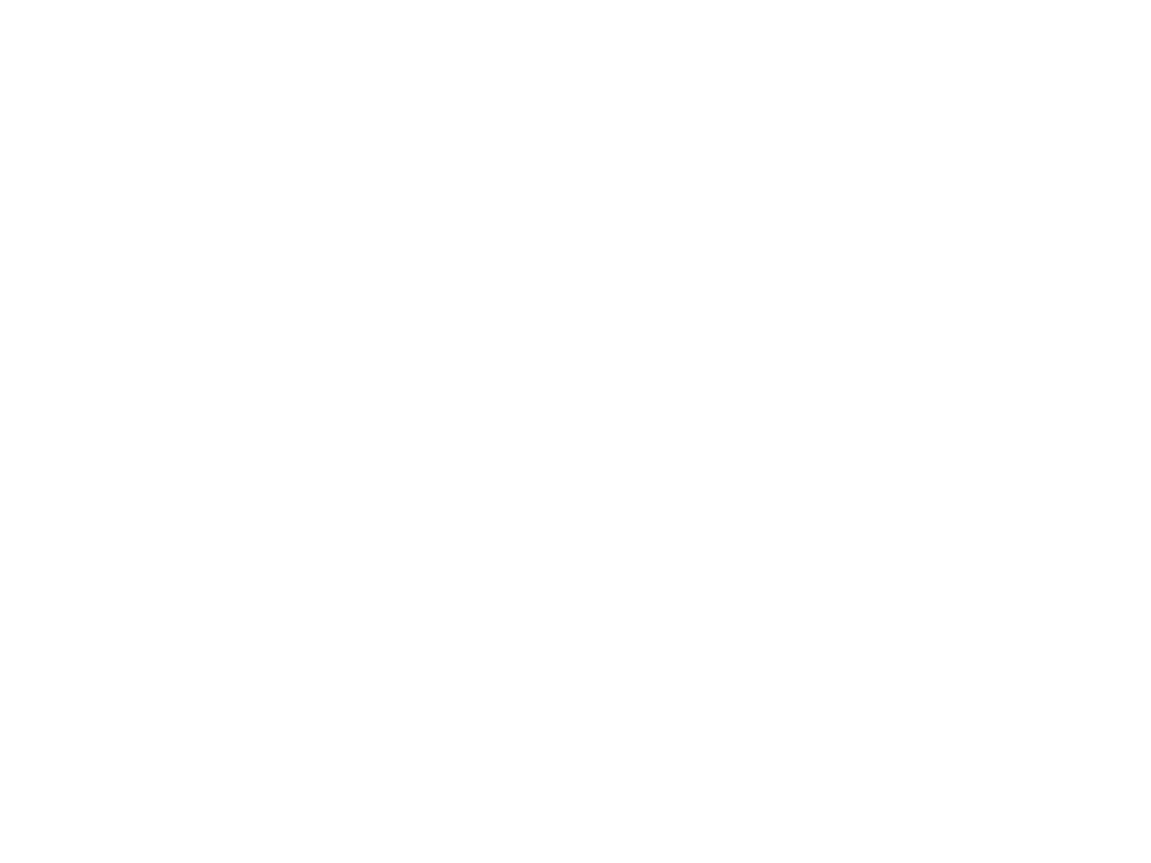

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


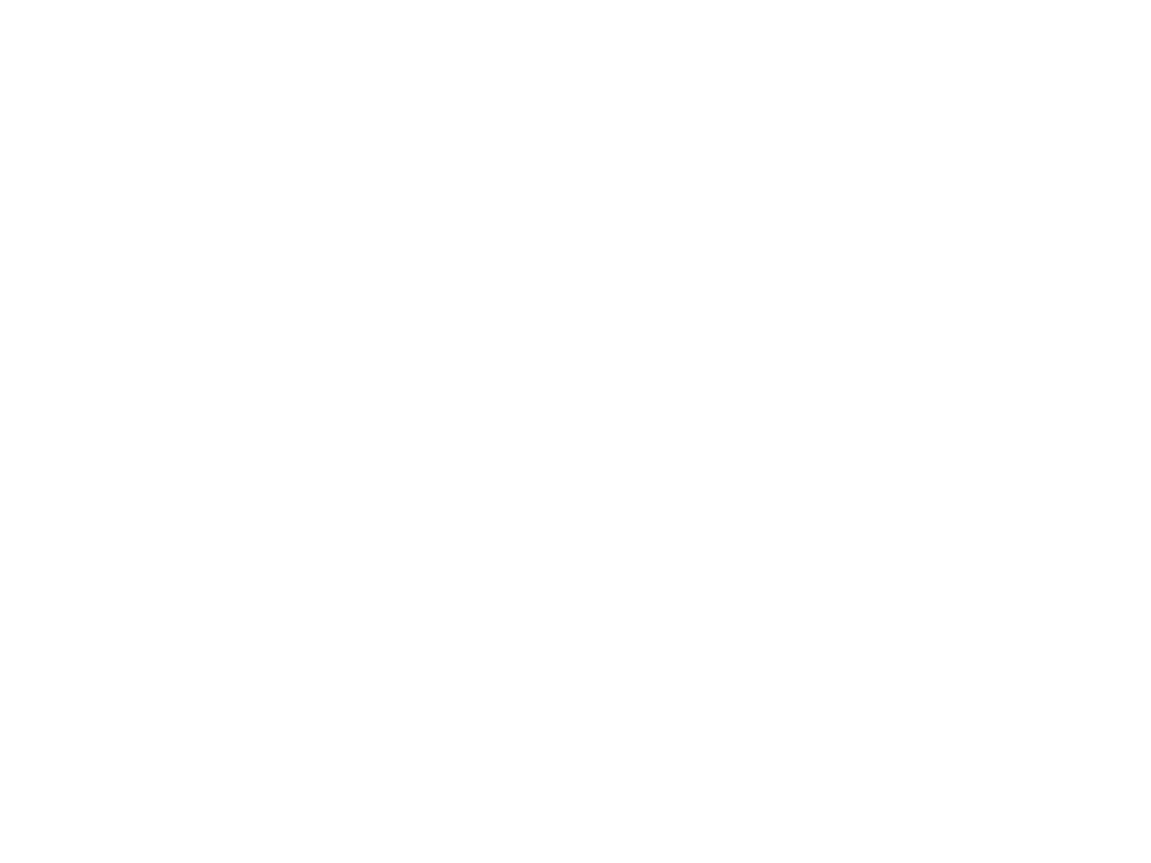

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


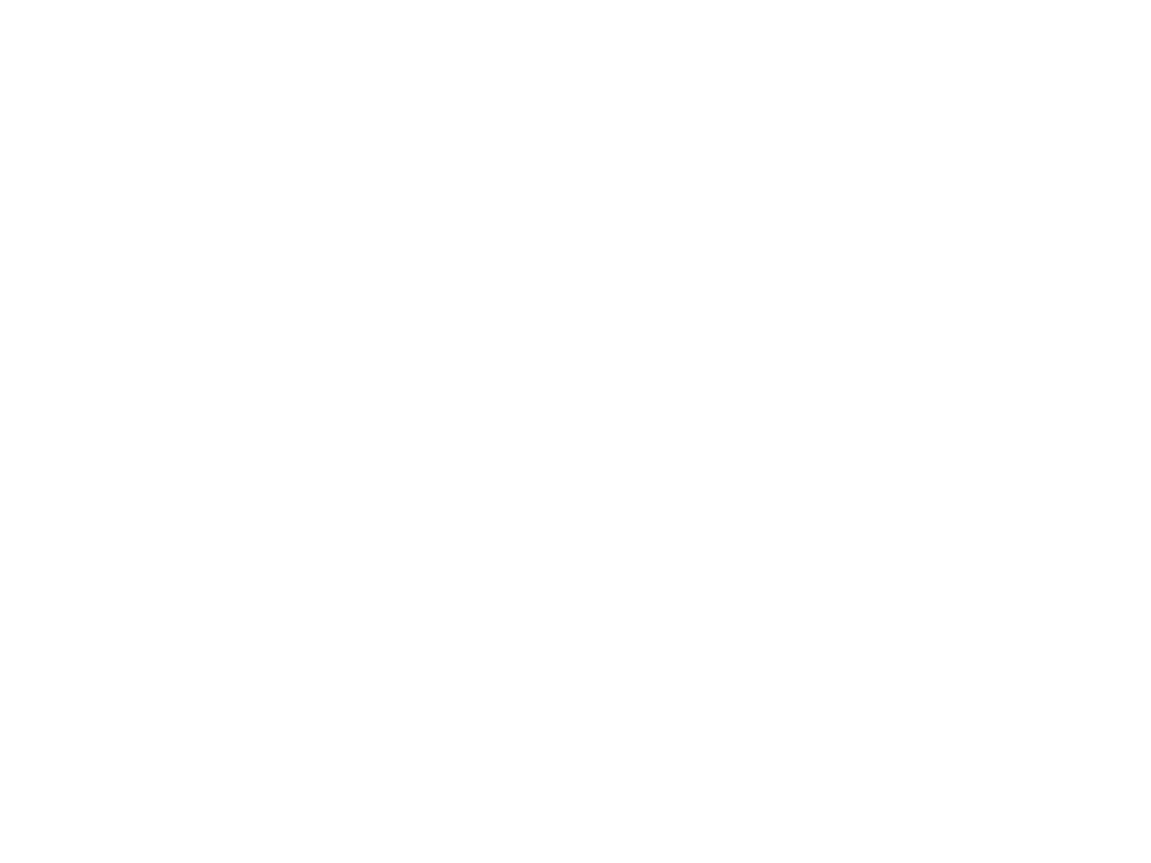

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


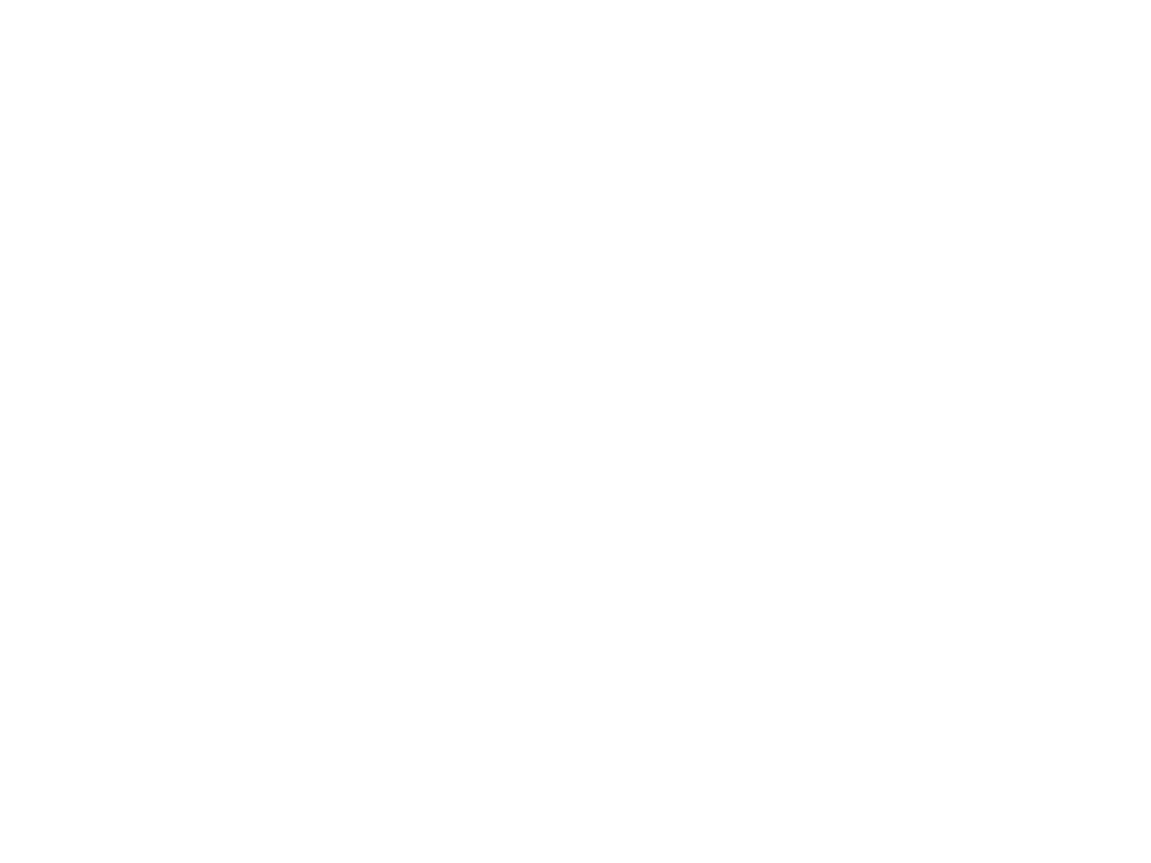

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf

Tunneling rate decreased.
Change in tunneling rate (temp = 1): -0.016992956178648516
Change in tunneling rate (temp = 3.89): 0.06878446216739698
Slowing down annealing schedule and resetting temperature.
Annealing steps: 266 --> 292
Temperature: 3.89 --> 3.89

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
18000/22328   3.894     -334.9       0.8562      0.0004796     0.4315          2      
18100/22328   3.894     -307.3       0.7456      0.0004796      0.431          2      
18200/22328   3.816     -350.3       0.9479      0.0004796     0.4302          2      
18300/22328   3.816     -346.3       0.8894      0.0004796     0.4306          2      
18400/22328   3.739     -355.3       0.9428      0.00

<IPython.core.display.Javascript object>


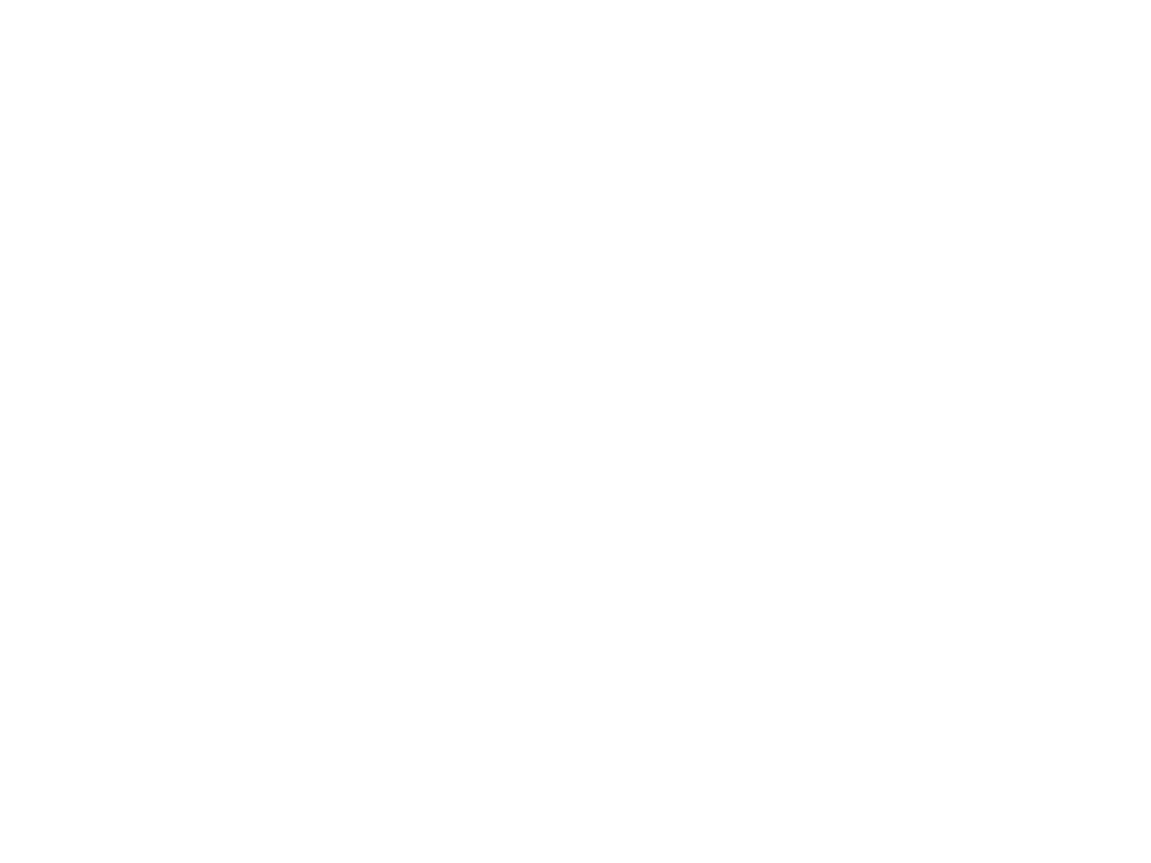

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


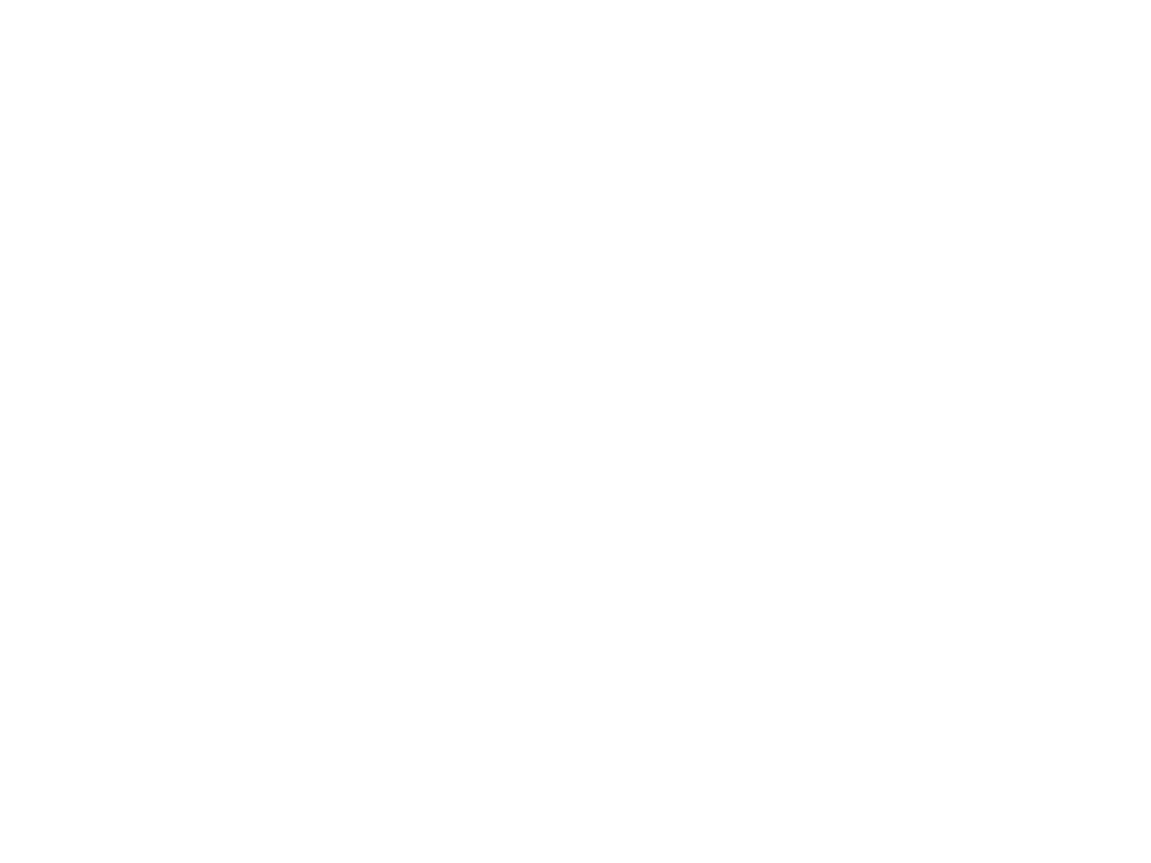

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


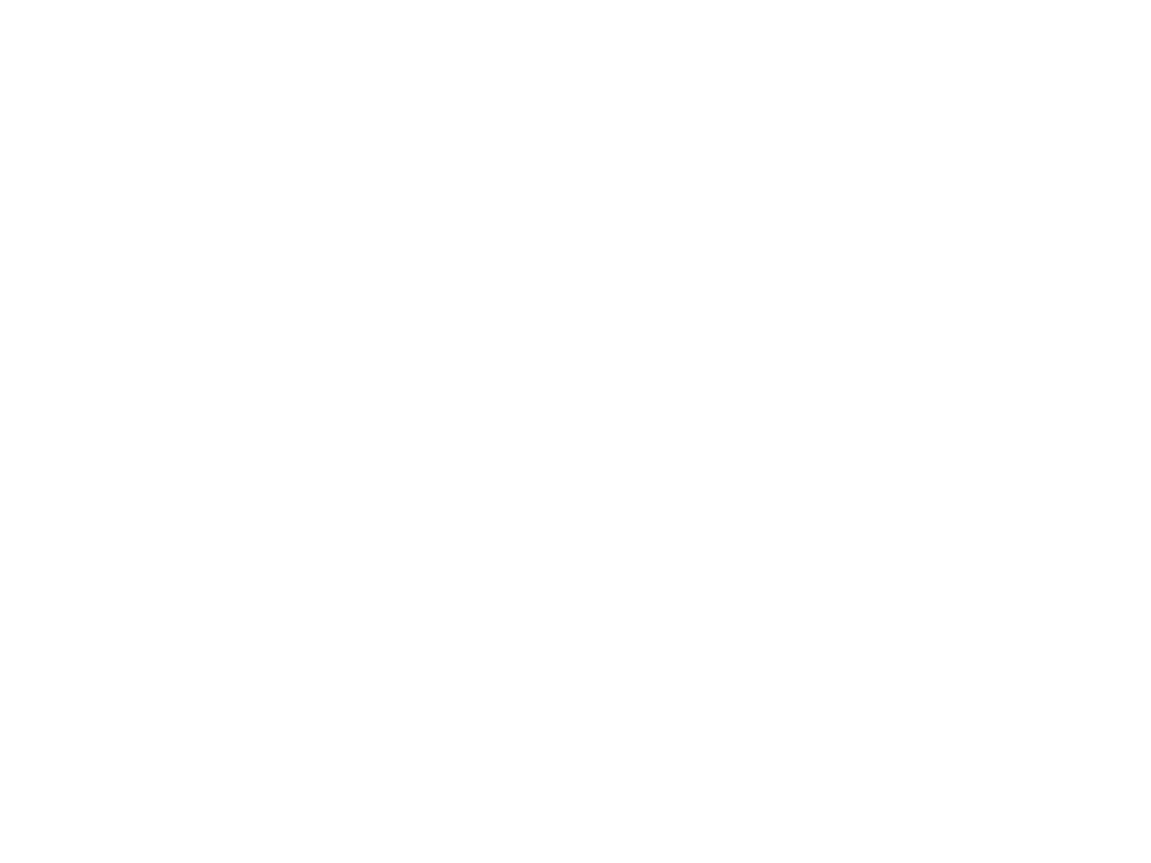

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


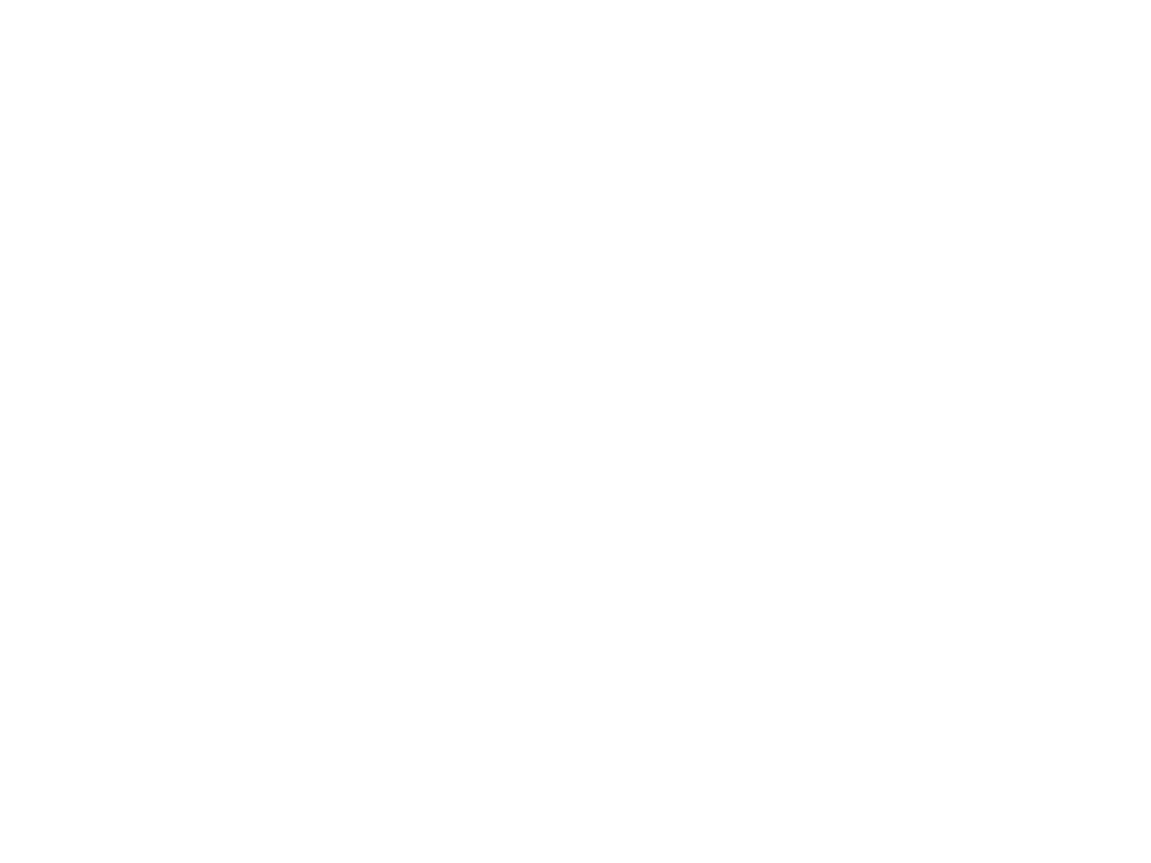

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


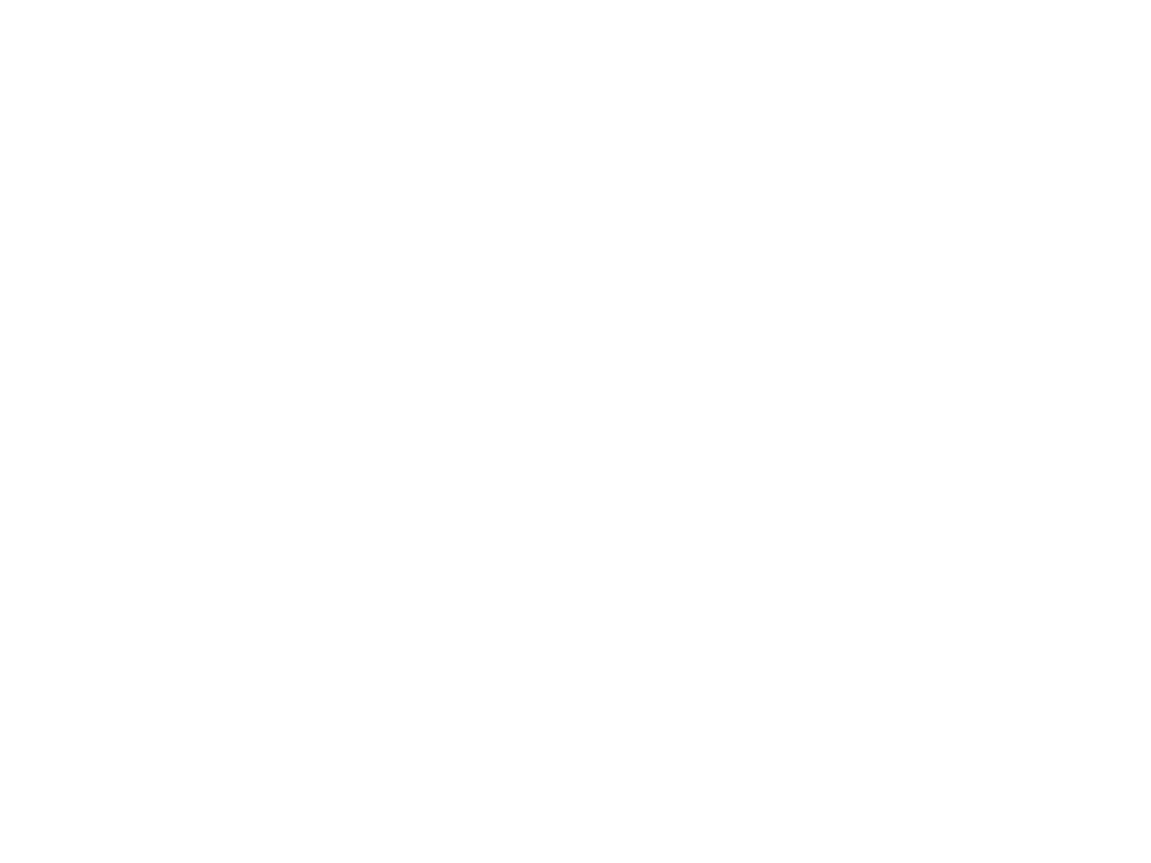

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
19000/22328   3.591     -334.4        0.931      0.0004604     0.4289          2      
19100/22328   3.591     -332.8       0.9246      0.0004604     0.4285          2      
19200/22328   3.591     -290.6       0.6684      0.0004604     0.4253          2      
19300/22328   3.519     -350.6       0.9321      0.0004604      0.427          2      
19400/22328   3.519     -326.9       0.9039      0.0004604     0.4265          2      
19500/22328   3.519     -309.2        0.924      0.0004604     0.4267          2      
19600/22328   3.449     -333.2       0.9184      0.0004604     0.4268          2      
19700/22328   3.449     -347.9       0.9282      0.000

<IPython.core.display.Javascript object>


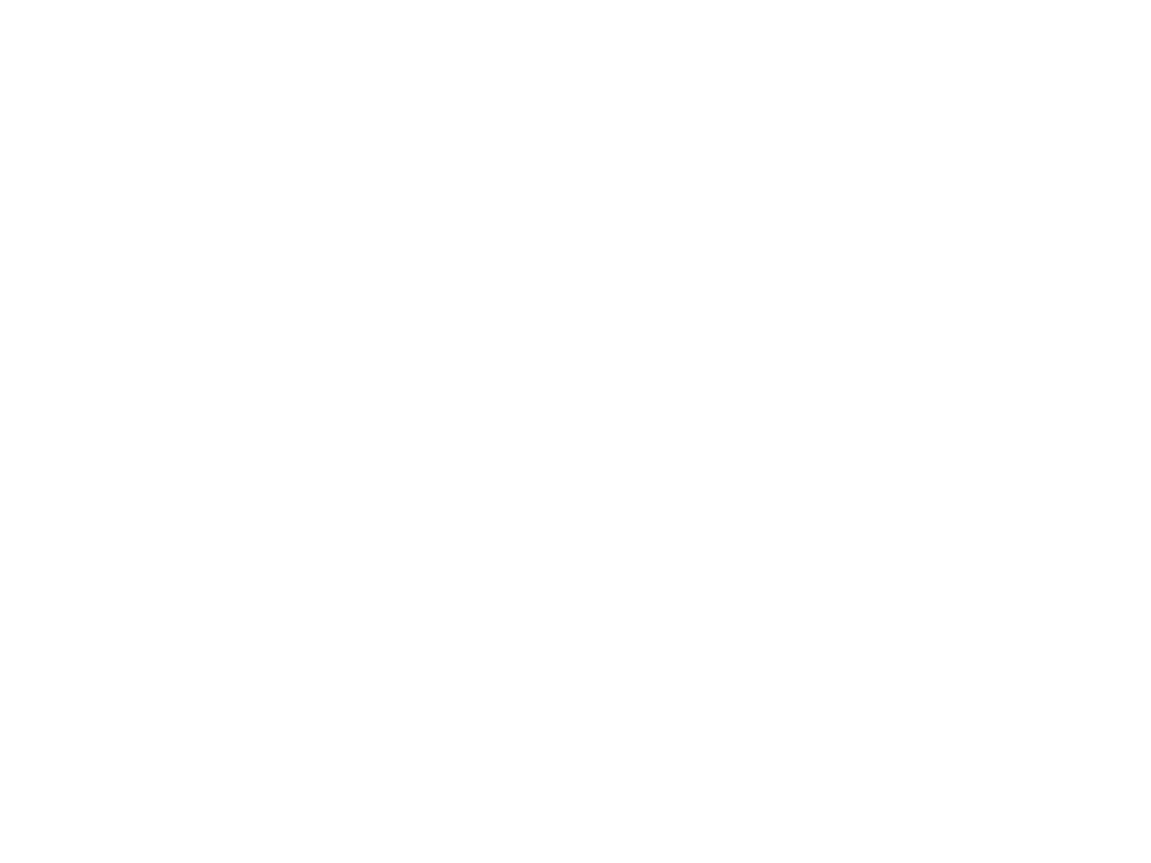

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


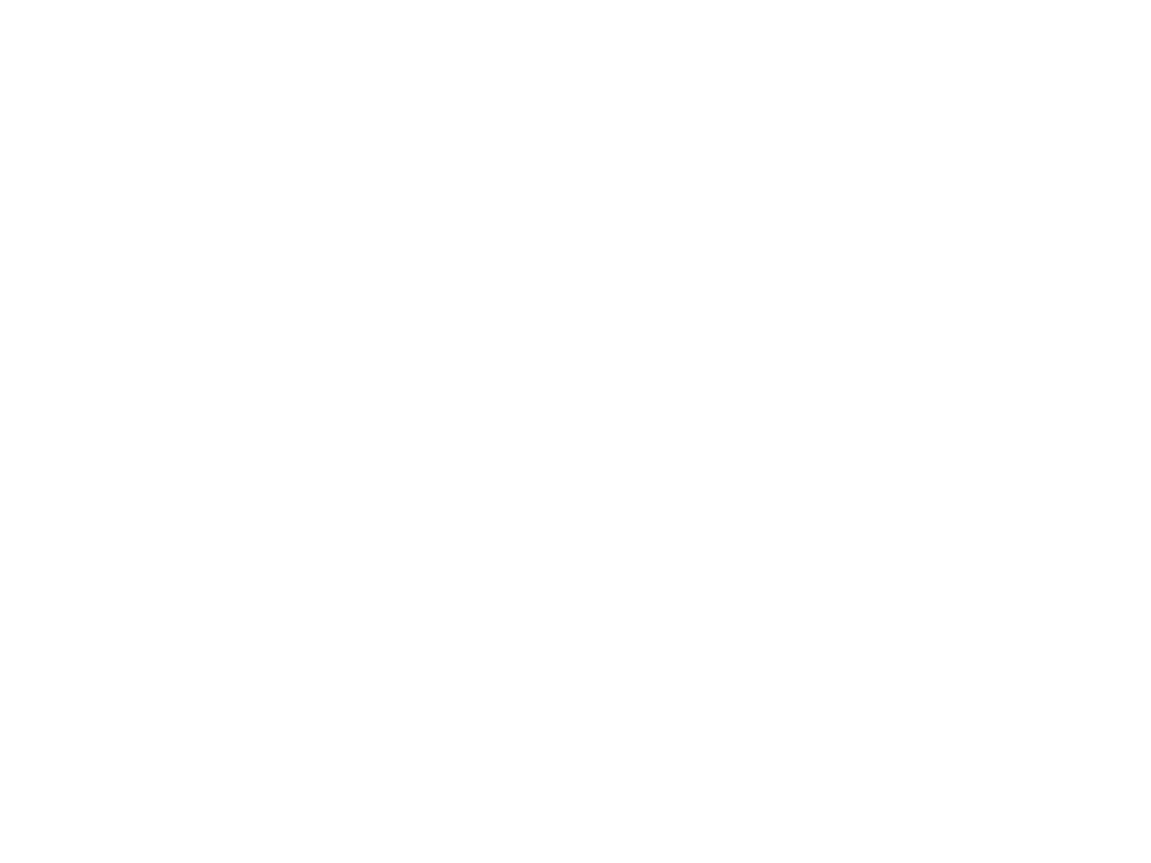

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


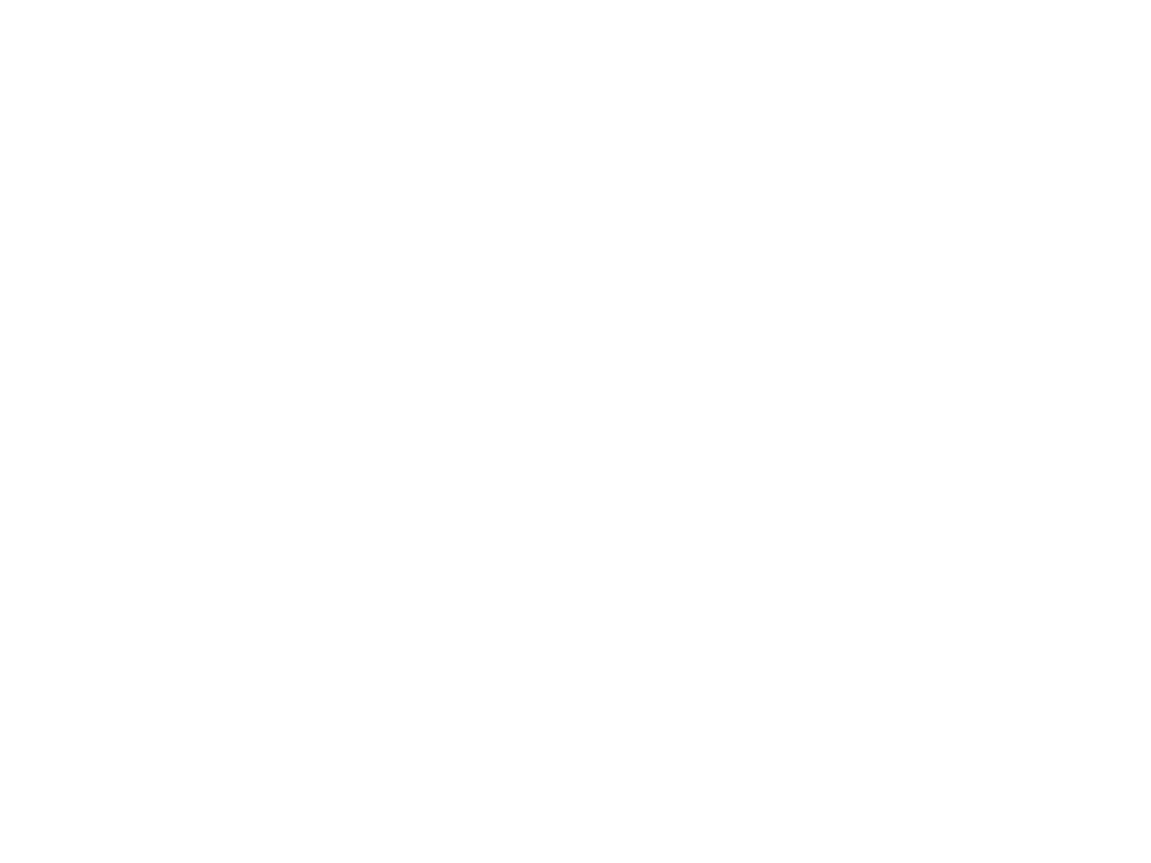

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


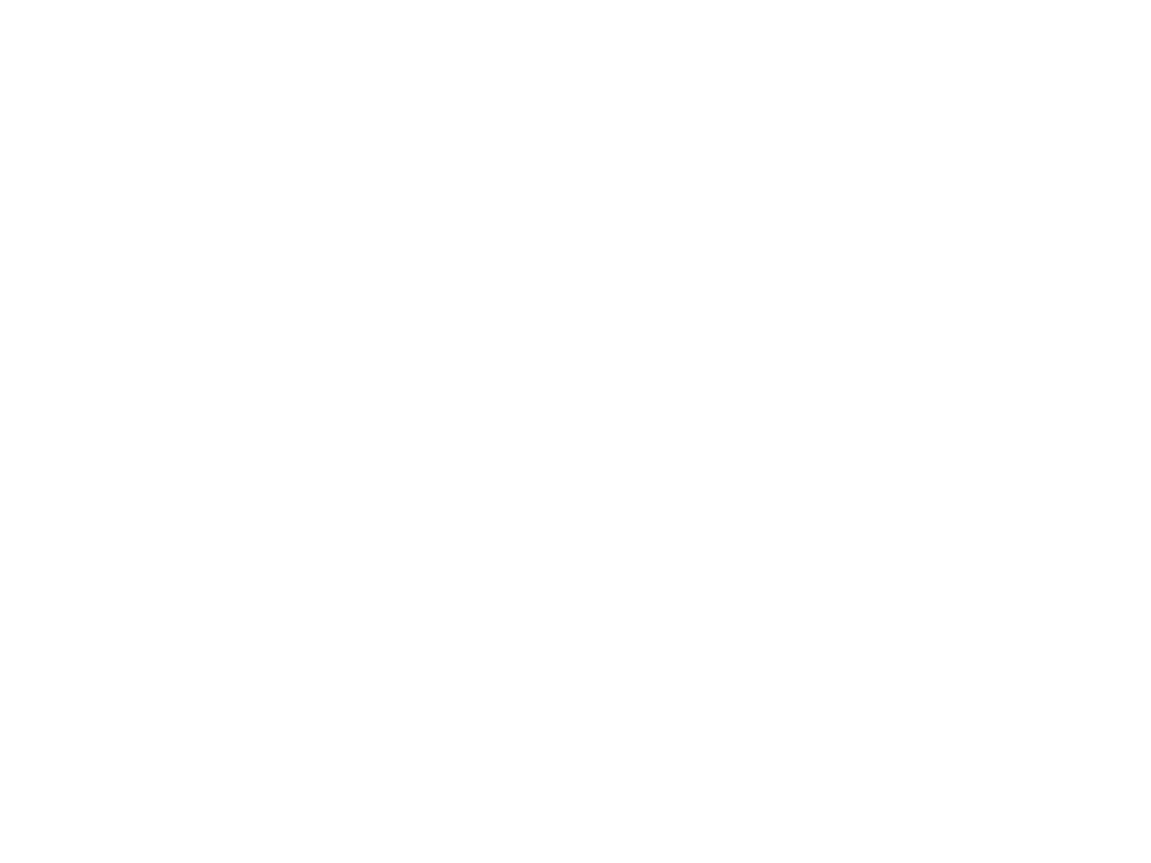

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


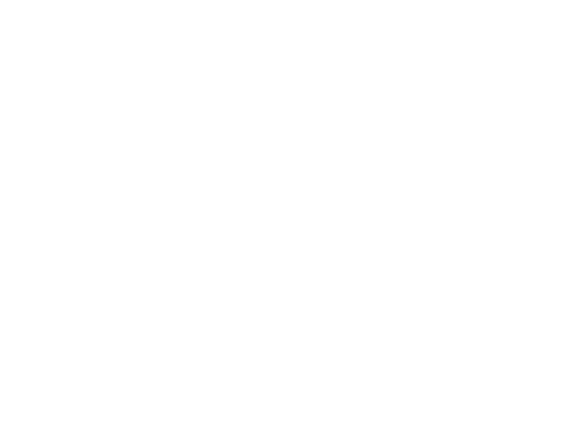

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
20000/22328    3.38     -348.5       0.9173      0.000442      0.4261          2      
20100/22328    3.38     -321.2       0.9011      0.000442      0.4267          2      
20200/22328   3.312     -328.9       0.8873      0.000442      0.4257          2      
20300/22328   3.312     -343.8       0.9083      0.000442      0.4256          2      
20400/22328   3.312     -332.9        0.911      0.000442      0.4256          2      
20500/22328   3.246     -334.7        0.908      0.000442      0.4258          2      
20600/22328   3.246     -345.9       0.9317      0.000442      0.4253          2      
20700/22328   3.246     -355.6       0.9002      0.000

<IPython.core.display.Javascript object>


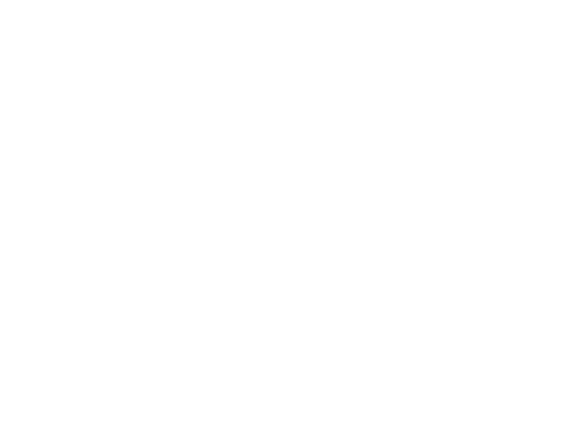

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


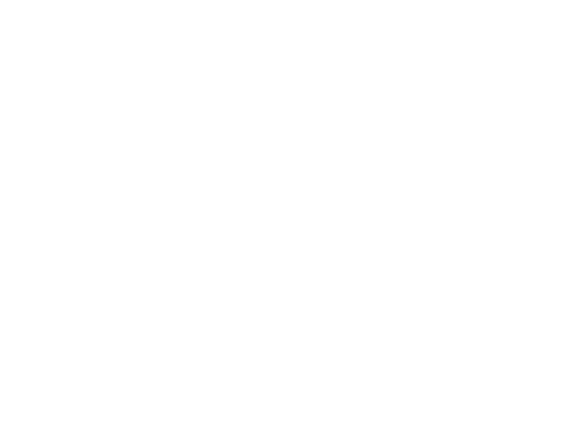

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


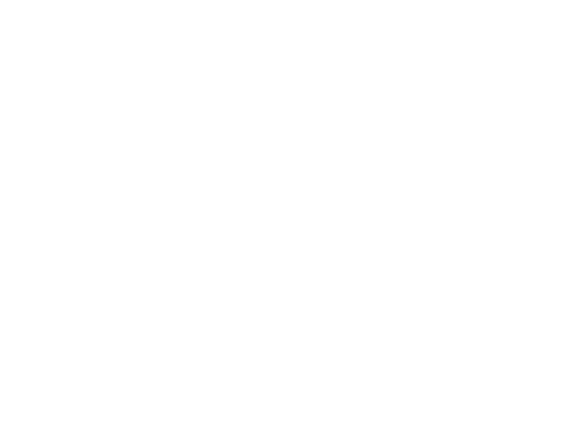

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


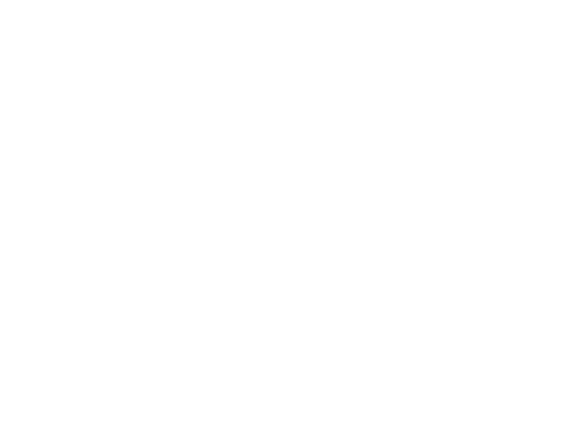

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


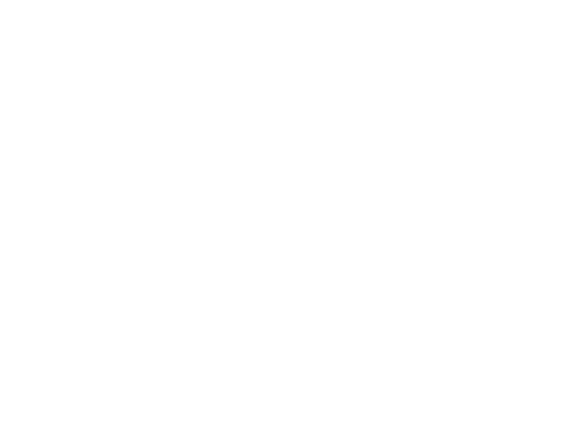

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf

Tunneling rate decreased.
Change in tunneling rate (temp = 1): 0.05200065944420254
Change in tunneling rate (temp = 3.18): 0.12749589035171438
Slowing down annealing schedule and resetting temperature.
Annealing steps: 292 --> 321
Temperature: 3.18 --> 3.18

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
21000/22328   3.181     -311.6       0.7542      0.0004243     0.4239          2      
21100/22328   3.181     -316.8       0.8351      0.0004243     0.4255          2      
21200/22328   3.118     -344.3       0.9339      0.0004243     0.4246          2      
21300/22328   3.118     -334.4       0.8585      0.0004243      0.424          2      
21400/22328   3.118     -372.4       0.9324      0.0004

<IPython.core.display.Javascript object>


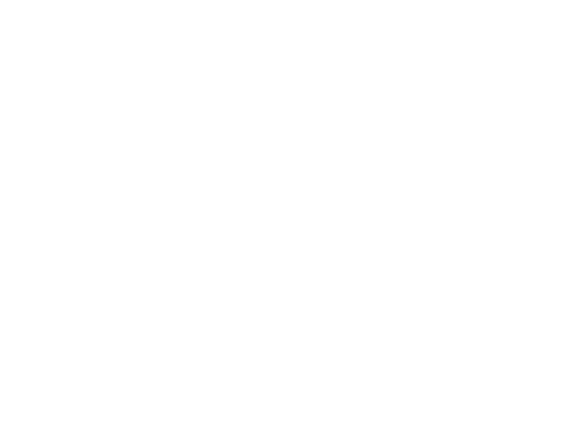

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_lowT.pdf


<IPython.core.display.Javascript object>


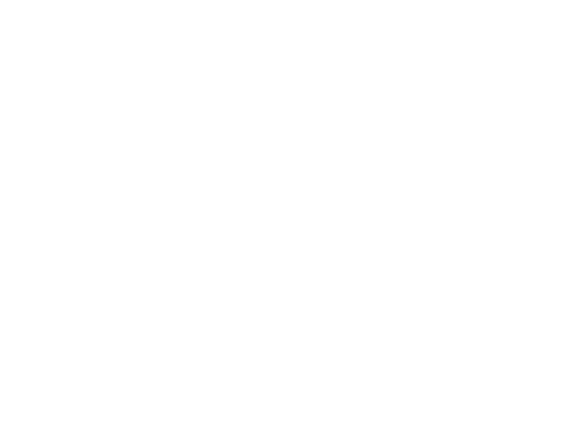

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_steps_highT.pdf


<IPython.core.display.Javascript object>


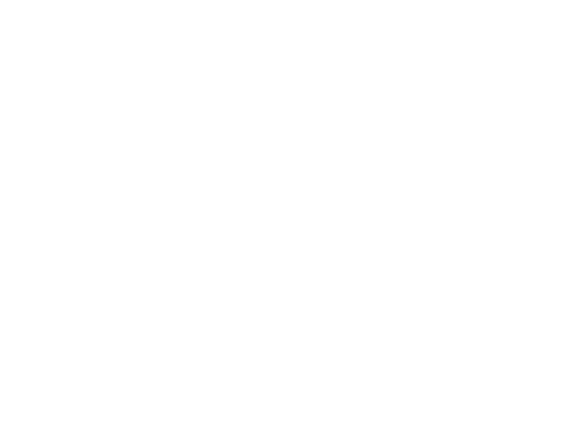

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_lowT.pdf


<IPython.core.display.Javascript object>


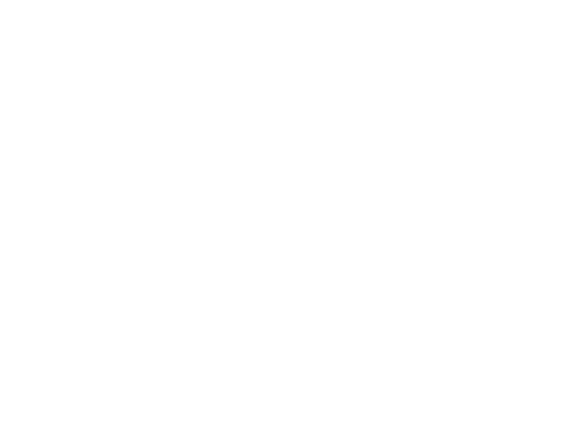

Saving figure to: ../../log_mog_tf/run_376/figures/tr_ar_dist_temps_highT.pdf


<IPython.core.display.Javascript object>


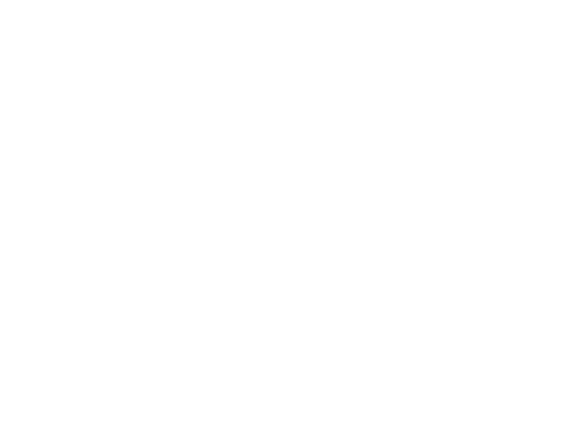

Saving figure to: ../../log_mog_tf/run_376/figures/annealing_schedule.pdf
---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
22000/22328   2.994     -337.6       0.9231      0.0004073      0.422          2      
22100/22328   2.994      -370        0.8894      0.0004073     0.4217          2      
22200/22328   2.934     -317.5       0.8991      0.0004073     0.4217          2      
22300/22328   2.934     -341.2       0.9048      0.0004073     0.4219          2      


In [10]:
model.train(20000)

In [11]:
target_samples = model.distribution.get_samples(500)

In [13]:
trajectories, losses, px = model.generate_trajectories(temp=1., 
                                                       num_samples=10, 
                                                       num_steps=250)

RuntimeError: Attempted to use a closed Session.

In [ ]:
idxs = [rand_traj(trajectories) for _ in range(5)]
nums = np.arange(len(idxs))
labels = ['trajectory ' + str(i) for i in nums]
for num, idx in enumerate(idxs):
    fig, ax = plt.subplots()
    _ = ax.plot(target_samples[:,0], target_samples[:,1], 
                marker='o', ls='', alpha=0.75, color='slategrey')
    #for i in range(3):
    #for num, idx in enumerate(idxs):
    _ = ax.plot(trajectories[:, idx, 0], trajectories[:, idx, 1], 
                marker='.', ls='-', alpha=0.5, color=colors[num])#, label=labels[num], color=colors[num])
    #_ = ax.plot(trajectories[:, idxs[0], 0], trajectories[:, idxs[0], 1], marker='.', ls='-', alpha=0.5)#, label=labels[num], color=colors[num])
    #ax.legend(loc='lower left')
    fig.tight_layout()
    plt.show()
    #plt.savefig(f'../log_mog_tf/run_327/figures/trajectory_{num}.pdf', dpi=400, bbox_inches='tight')

## Testing dynamics

In [20]:
step = 1
t = model.dynamics._format_time(step, tile=tf.shape(model.x)[0])
grad1 = model.dynamics.grad_energy(model.x, aux=None)
S1 = model.dynamics.VNet([model.x, grad1, t, None])

In [21]:
sv1 = 0.5 * model.dynamics.eps * S1[0]
tv1 = S1[1]
fv1 = model.dynamics.eps * S1[2]

In [24]:
from utils.dynamics import safe_exp
prod_sv1 = tf.multiply(model.z, safe_exp(sv1, name='sv1F'))
prod_fv1 = tf.multiply(safe_exp(fv1, name='fv1F'), grad1)
v_h = prod_sv1 + 0.5 * model.dynamics.eps * (-prod_fv1 + tv1)

In [28]:
model.sess.run(v_h, feed_dict={model.x: samples, model.dynamics.temperature: 1.}).shape

(100, 2)

In [17]:
model.sess.run(tf.global_variables_initializer())

In [18]:
model.sess.run(vnet, feed_dict={model.x: samples, model.dynamics.temperature: 1.})

[array([[-0.16493094,  0.10004426],
        [-0.13154358,  0.34069416],
        [-0.24086183, -0.24672726],
        [-0.1714805 ,  0.02355536],
        [-0.2740885 , -0.08008911],
        [-0.1496959 , -0.14191352],
        [-0.1682138 ,  0.46480742],
        [-0.1827162 , -0.25866538],
        [-0.15540472,  0.17021209],
        [-0.30985868,  0.6359689 ],
        [-0.15949534,  0.2735524 ],
        [-0.1476932 , -0.22506686],
        [-0.33706862, -0.63749194],
        [-0.0975752 ,  0.2984231 ],
        [-0.12189759,  0.3065236 ],
        [-0.35338894,  0.7086532 ],
        [-0.28831613,  0.5056133 ],
        [-0.35117045, -0.33869362],
        [-0.07468105, -0.00434444],
        [-0.18142277,  0.36199695],
        [-0.19999573,  0.5598908 ],
        [-0.2114325 ,  0.5344103 ],
        [-0.19055694,  0.29619583],
        [-0.17987587, -0.18405293],
        [-0.37052068, -0.41144934],
        [-0.11247279,  0.29201078],
        [-0.36042774,  0.5787242 ],
        [-0.22568433,  0.581

In [22]:
model._restore_model()

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999
Model restored.



In [12]:
model.train(10)

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999
Model restored.

---------------------------------------------------------------------------------------
    STEP       TEMP      LOSS      ACCEPT RATE      LR        STEP SIZE    TRAJ LEN   
---------------------------------------------------------------------------------------
40000/40010   1.006      1311       1.71e-06     0.0001954     0.5804          3      


In [23]:
trajectories, loss_arr, accept_arr = model.generate_trajectories()

In [26]:
#trajectories[:, 0, :]
trajectories[:20,0, :]

array([[ 1.6270784 , -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887],
       [ 1.62707841, -0.20419887]])

In [38]:
_samples = model.distribution.get_samples(200)
trajectories = []
for step in range(100):
    _samples = model.distribution.get_samples(200)
    trajectories.append(np.copy(_samples))
    feed_dict = {model.x: _samples,
                 model.dynamics.temperature: 1.}
    loss, _samples, px = model.sess.run([
        model.loss,
        model.output[0],
        model.px,
    ], feed_dict=feed_dict)

#  _, loss_, model.samples, px_, lr_, = model.sess.run([
#_, loss_, _samples, px_, lr_, = model.sess.run([
#    model.train_op,
#    model.loss,
#    model.output[0],
#    model.px,
#    model.learning_rate
#], feed_dict=feed_dict)

In [39]:
trajectories = np.array(trajectories)
np.array(trajectories).shape

(100, 200, 2)

In [40]:
trajectories[:20, 0, :]

array([[ 0.22690701,  1.0176681 ],
       [ 1.48269341,  0.25152916],
       [ 0.7373572 ,  0.0962187 ],
       [-0.30741802,  1.37695288],
       [-0.05400104,  1.7095782 ],
       [ 0.18060045,  1.61676309],
       [ 1.45003324, -0.02905049],
       [ 1.44096197, -0.04440846],
       [ 1.19382557,  0.46499048],
       [-0.16094446,  1.17674708],
       [ 0.93810046,  0.04642486],
       [ 0.16703731,  1.32915737],
       [ 1.47148989, -0.09602996],
       [ 0.07907255,  1.59149825],
       [-0.0442573 ,  1.23372342],
       [-0.08131032,  1.22208512],
       [ 1.93999446,  0.01150151],
       [-0.16744005,  1.46965841],
       [ 1.47258882, -0.05190585],
       [-0.21334952,  1.34552779]])

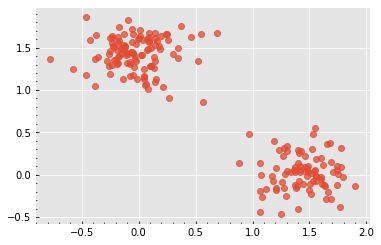

In [57]:
#for i in range(10):
fig, ax = plt.subplots()
ax.plot(_samples[:,0], _samples[:,1], ls='', marker='o', alpha=0.75)
#ax.plot(trajectories[:50, 9, 0], trajectories[:50, 9, 1], ls='-', marker='', alpha=0.6)
plt.savefig('../log_mog_tf/run_22_diag_271/figures/distribution.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [46]:
model.global_step.eval(model.sess)

40001

In [61]:
model.arrangement = 'axes'

In [62]:
model._generate_plots(model.global_step.eval(model.sess))

Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_steps_lowT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_steps_highT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_temps_lowT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/tr_ar_dist_temps_highT.pdf
Saving figure to: ../log_mog_tf/run_22_diag_271/figures/annealing_schedule.pdf


In [32]:

_samples1 = model.sess.run([
    model.output[0]
], feed_dict={model.x: _samples, model.dynamics.temperature: 1.})
#_samples

In [33]:
_samples

array([[-0.04825972,  1.6681467 ],
       [-1.1017684 ,  1.4772418 ],
       [ 1.9032845 ,  1.8739713 ],
       [ 0.952036  , -1.4666694 ],
       [-1.3941865 ,  2.493881  ],
       [-0.18121843, -1.3036962 ],
       [-1.361677  ,  2.0898554 ],
       [-1.7863096 ,  2.6423538 ],
       [ 2.5584097 , -1.5798473 ],
       [ 2.1330292 , -1.0426351 ],
       [ 0.4785167 ,  1.3442143 ],
       [-0.8349031 ,  1.2927455 ],
       [-1.2139485 ,  0.7711269 ],
       [-1.4965838 ,  1.2853804 ],
       [ 2.4092393 ,  2.7996662 ],
       [ 0.8232765 ,  0.2041724 ],
       [ 1.2944108 , -1.527963  ],
       [-2.1198728 ,  0.2927999 ],
       [ 2.013573  , -0.8611102 ],
       [ 0.12205063,  0.802365  ],
       [ 0.29903266,  2.6345344 ],
       [ 0.80823004, -1.1293293 ],
       [-1.5458711 ,  0.2832795 ],
       [-1.0067353 ,  2.0859966 ],
       [-0.32478535,  0.9064286 ],
       [ 2.2341614 , -0.47455287],
       [-0.14755844, -0.44172037],
       [ 0.9511992 , -0.14620894],
       [-0.30935544,

In [34]:
_samples1

[array([[-0.04825972,  1.6681467 ],
        [-1.1017684 ,  1.4772418 ],
        [ 1.9032845 ,  1.8739713 ],
        [ 0.952036  , -1.4666694 ],
        [-1.3941865 ,  2.493881  ],
        [-0.18121843, -1.3036962 ],
        [-1.361677  ,  2.0898554 ],
        [-1.7863096 ,  2.6423538 ],
        [ 2.5584097 , -1.5798473 ],
        [ 2.1330292 , -1.0426351 ],
        [ 0.4785167 ,  1.3442143 ],
        [-0.8349031 ,  1.2927455 ],
        [-1.2139485 ,  0.7711269 ],
        [-1.4965838 ,  1.2853804 ],
        [ 2.4092393 ,  2.7996662 ],
        [ 0.8232765 ,  0.2041724 ],
        [ 1.2944108 , -1.527963  ],
        [-2.1198728 ,  0.2927999 ],
        [ 2.013573  , -0.8611102 ],
        [ 0.12205063,  0.802365  ],
        [ 0.29903266,  2.6345344 ],
        [ 0.80823004, -1.1293293 ],
        [-1.5458711 ,  0.2832795 ],
        [-1.0067353 ,  2.0859966 ],
        [-0.32478535,  0.9064286 ],
        [ 2.2341614 , -0.47455287],
        [-0.14755844, -0.44172037],
        [ 0.9511992 , -0.146

In [8]:
model.train(10)

Restoring previous model from: ../log_mog_tf/run_22_diag_271/model.ckpt-39999
INFO:tensorflow:Restoring parameters from ../log_mog_tf/run_22_diag_271/model.ckpt-39999


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [50,2] rhs shape= [20,2]
	 [[Node: save/Assign_86 = Assign[T=DT_FLOAT, _class=["loc:@XNet/linear_t/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](XNet/linear_t/W/Adam_1, save/RestoreV2:86)]]

Caused by op 'save/Assign_86', defined at:
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-73ba78d2c186>", line 1, in <module>
    model.train(10)
  File "/Users/saforem2/ANL/l2hmc/l2hmc/mog_model.py", line 881, in train
    saver = tf.train.Saver(max_to_keep=3)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1284, in __init__
    self.build()
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1296, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1333, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 422, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 113, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 219, in assign
    validate_shape=validate_shape)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/Users/saforem2/miniconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [50,2] rhs shape= [20,2]
	 [[Node: save/Assign_86 = Assign[T=DT_FLOAT, _class=["loc:@XNet/linear_t/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](XNet/linear_t/W/Adam_1, save/RestoreV2:86)]]


### Less old

In [ ]:
for key in model.tunneling_rates_highT.keys():
    #print(f'Step num: {key[0]}')
    #print(f'Temp: {key[1]}')
    model.steps_arr.append(key[0])
    model.temp_arr.append(key[1])
    #model.temp_arr.append(key[1])

In [ ]:
for idx in range(len(model.steps_arr)):
    model.steps_arr[idx] += 1

In [ ]:
model.steps_arr

In [ ]:
for key, val in model.tunneling_rates.items():
    model.tunneling_rates_avg.append(val[0])
    model.tunneling_rates_err.append(val[1])
for key, val in model.tunneling_rates_highT.items():
    model.tunneling_rates_avg_highT.append(val[0])
    model.tunneling_rates_err_highT.append(val[1])
    
for key, val in model.acceptance_rates.items():
    model.acceptance_rates_avg.append(val[0])
    model.acceptance_rates_err.append(val[1])
for key, val in model.acceptance_rates_highT.items():
    model.acceptance_rates_avg_highT.append(val[0])
    model.acceptance_rates_err_highT.append(val[1])
    
for key, val in model.distances.items():
    model.distances_avg.append(val[0])
    model.distances_err.append(val[1])
for key, val in model.distances_highT.items():
    model.distances_avg_highT.append(val[0])
    model.distances_err_highT.append(val[1])

In [ ]:
model._save_variables()

In [ ]:
model._init_params(params)

In [ ]:
model._load_variables()

In [ ]:
model.steps_arr

In [ ]:
model.tunneling_rates

In [ ]:
import os

In [ ]:
model.__dict__.keys()

In [ ]:
get_vals_as_arr = lambda _dict: np.array(list(_dict.values()))
tr = get_vals_as_arr(model.tunneling_rates)
ar = get_vals_as_arr(model.acceptance_rates)
dr = get_vals_as_arr(model.distances)
#np.array(list(model.tunneling_rates.values()))

In [ ]:
for key in model.attrs_dict.keys():
    in_file = model.info_dir + key + '.npy'
    if os.path.isfile(in_file):
        setattr(model, key, np.load(in_file))
        print(f'Set model.{key} to values read in from: {in_file}')
        #print(model.key == np.load(in_file))

In [ ]:
model.sess.run(tf.global_variables_initializer())

In [ ]:
attrs_dict = model.attrs_dict

In [ ]:
attrs_dict['steps_arr']

In [ ]:
model.train(params['num_training_steps'], plot=True)

## OLD

In [ ]:
#trajectories, loss_arr, px_arr = model.generate_trajectories(num_samples=100, num_steps=100, temperature=1.)

#config = tf.ConfigProto(log_device_placement=True)
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#model.build_graph()

In [ ]:
def calc_avg_distance1(trajectories):
    distances_arr = []
    for trajectory in trajectories:
        distance_arr = []
        for idx in range(1, len(trajectory)):
            diff = trajectory[idx] - trajectory[idx-1]
            dist = np.sqrt(np.dot(diff, diff.T))
            distance_arr.append(dist)
        distances_arr.append(sum(distance_arr))
    return np.mean(distances_arr)

def calc_avg_distance2(trajectories):
    dist = lambda d: np.sqrt(np.dot(d, d.T))
    #distances_arr = np.mean([[dist(d) for d in [t[:-1, :] - t[1:, :] for t in trajectories]]
    #for trajectory in trajectories:
        diff = trajectory[:-1, :] - trajectory[1:, :]
        distance = sum([np.sqrt(np.dot(d, d.T)) for d in diff])
        distances_arr.append(distance)
    return np.mean(distances_arr)

In [ ]:
%timeit avg_dist = avg_distance_traveled(trajectories.transpose([1,0,2]))
#print(avg_dist)

%timeit avg_dist1 = calc_avg_distance1(trajectories.transpose([1,0,2]))
#print(avg_dist1)

%timeit avg_dist2 = calc_avg_distance2(trajectories.transpose([1,0,2]))
#print(avg_dist2)

distances = np.array([np.sqrt(np.dot(disp, disp.T)) for disp in displacements])

In [ ]:
model.train(params['num_training_steps'], config=config, plot=True)

config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
model.build_graph()
model.train(params['num_training_steps'], config=config, plot=False)